# Lab 10 - Metaheuristics

Information on group members:

1) 150284, Sofya Aksenyuk <br>
2) 150281, Uladzimir Ivashka

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

1) Given below is a benchmark objective function to be maximized. It can be parameterized to be 2, 3, 4, or 5 dimensional (M parameter). Implement any heuristic shown during the lecture to find the optimum. Your study should involve:
 - sensitivity analysis concerning the number of objectives involved;
 - sensitivity analysis concerning different ways of parameterizing your algorithm (e.g., population size in an evolutionary algorithm);   
 - for each experimental setting, the method should be run multiple times, and the obtained results should be averaged;
 - consider presenting the results using tables and plots. 

In [2]:
def getF(P):
    M = len(P)
    refPoints = [
 [[0.7, 0.3], [0.2, 0.2], [0.3, 0.6], [0.7, 0.9], [0.35, 0.35], [0.6, 0.6], [0.2, 0.9]], #M = 2
 [[0.7, 0.3, 0.5], [0.2, 0.2, 0.1], [0.3, 0.6, 0.9], [0.7, 0.9, 0.2], [0.35, 0.35, 0.35], [0.6, 0.6, 0.6], [0.2, 0.9, 0.4]], #M = 3
 [[0.7, 0.3, 0.5, 0.9], [0.2, 0.2, 0.1, 0.2], [0.3, 0.6, 0.9, 0.5], [0.7, 0.9, 0.2, 0.4], [0.35, 0.35, 0.35, 0.35], [0.6, 0.6, 0.6, 0.6], [0.2, 0.9, 0.4, 0.1]], #M = 4
 [[0.7, 0.3, 0.5, 0.9, 0.2], [0.2, 0.2, 0.1, 0.2, 0.6], [0.3, 0.6, 0.9, 0.5, 0.1], [0.7, 0.9, 0.2, 0.4, 0.9], [0.35, 0.35, 0.35, 0.35, 0.2], [0.6, 0.6, 0.6, 0.6, 0.9], [0.2, 0.9, 0.4, 0.1, 0.5]] #M = 5
    ]
    
    PP = np.array(P)
    v = 2.5*np.exp(-(5*np.linalg.norm(PP - np.array(refPoints[M-2][0])))**2)
    v += 1.0*np.exp(-(6*np.linalg.norm(PP - np.array(refPoints[M-2][1])))**2)
    v += 1.5*np.exp(-(6*np.linalg.norm( PP - np.array(refPoints[M-2][2])))**2)
    v += 1.2*np.exp(-(3*np.linalg.norm( PP - np.array(refPoints[M-2][3])))**2)
    v += 1.7*np.exp(-(14*np.linalg.norm( PP - np.array(refPoints[M-2][4])))**2)
    v += 1.4*np.exp(-(6.5*np.linalg.norm( PP - np.array(refPoints[M-2][5])))**2)
    v += 2.0*np.exp(-(10.0*np.linalg.norm( PP - np.array(refPoints[M-2][6])))**2)
    return v

print(getF([0.7, 0.3, 0.5]))

2.5343274543723906


In [3]:
def generate_population(popsize, dims=None):
    population = []
    if dims is None:
        for dim in [2, 3, 4, 5]:
            population += [np.random.normal(size=dim) for _ in range(popsize//4)]
    else:
        population += [np.random.normal(size=dims) for _ in range(popsize)]
        
    return sorted(population, key=getF, reverse=True)

In [4]:
def change_dimensions(gen):
    if np.random.randint(0, 100) < 10:
        if len(gen) == 2:
            gen.append(np.random.normal())
        elif len(gen) == 5:
            gen.pop(np.random.choice(range(len(gen))))
        else:
            if np.random.randint(0, 100) < 50:
                gen.append(np.random.normal())
            else:
                gen.pop(np.random.choice(range(len(gen))))
    return gen

In [5]:
def mutate(gen, prob=50, div=10, change_dim=False):
    gen = list(gen)
    for idx in range(len(gen)):
        if np.random.randint(0, 100) < prob:
            gen[idx] += np.random.normal() / div
    
    ## change dimensions
    if change_dim:
        gen = change_dimensions(gen)
    
    return np.array(gen)

In [6]:
def crossover(gen1, gen2):
    cut_point = max(len(gen1), len(gen2)) // 2
    gen1, gen2 = list(gen1), list(gen2)
    child = gen1[:cut_point] + gen2[cut_point:] if np.random.randint(0, 100) < 50 else gen2[:cut_point] + gen1[cut_point:]
    return np.array(child)

In [7]:
def tournament_selection(population, k):
    tournament = random.choices(population, k=k)
    return np.array(max(tournament, key=getF))

In [8]:
def evolve(population, popsize, tournament_size, _print=False, change_dim=False):
    bests = []
    prev_best_score = 0
    counter = 0
    
    while True:
        ## mutation of bad ones
        for bad_gen in population[int(0.9*popsize):popsize][::-1]:
            bad_gen = mutate(bad_gen, change_dim)
            population.append(bad_gen)
        ## crossover
        for _ in range(int(0.5*popsize)):
            parent1 = tournament_selection(population, tournament_size)
            parent2 = tournament_selection(population, tournament_size)
            child = crossover(parent1, parent2)
            population.append(child)
        ## mutation
        for _ in range(int(0.5*popsize)):
            winner = tournament_selection(population, tournament_size)
            winner = mutate(winner, change_dim)
            population.append(winner)
        ## some new random samples
        population += generate_population(int(0.1*popsize))

        population = sorted(population, key=getF, reverse=True)
        population = population[:popsize]
        
        best_score = getF(population[0])
        bests.append(best_score)
        if best_score == prev_best_score:
            counter += 1
        else:
            counter = 0
            prev_best_score = best_score
            
        if _print:
            print(f'Best gen: {population[0]}; score: {best_score}')
        
        if counter > 100:
            break
        
    return bests

## Example of evolution

### Population of mixed dimensions with change of dimensions in mutation

In [9]:
population = generate_population(100)
print(f'Best gen: {population[0]}, score: {getF(population[0])}')
_ = evolve(population, 100, 5, _print=True, change_dim=True)

Best gen: [0.16249393 0.89564664], score: 1.8560173611999966
Best gen: [0.16249393 0.89564664]; score: 1.8560173611999966
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.89564664]; score: 2.1185914554693515
Best gen: [0.22024594 0.

Best gen: [0.71413896 0.31421768]; score: 2.5554225360556893
Best gen: [0.71413896 0.31421768]; score: 2.5554225360556893
Best gen: [0.71413896 0.31105206]; score: 2.556675529807993
Best gen: [0.71413896 0.31105206]; score: 2.556675529807993
Best gen: [0.71413896 0.31105206]; score: 2.556675529807993
Best gen: [0.71413896 0.31105206]; score: 2.556675529807993
Best gen: [0.71413896 0.31105206]; score: 2.556675529807993
Best gen: [0.71413896 0.31105206]; score: 2.556675529807993
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.30861031]; score: 2.5569167133378254
Best gen: [0.71413896 0.308610

Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.31122767]; score: 2.5727219429188954
Best gen: [0.69865995 0.

Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.30987997]; score: 2.5728488178148403
Best gen: [0.69865995 0.

### Population of a singe dimension without change of dimensions in mutation (2D as an example)

In [10]:
population = generate_population(100, dims=2)
print(f'Best gen: {population[0]}, score: {getF(population[0])}')
_ = evolve(population, 100, 5, _print=True)

Best gen: [0.57870912 0.49640246], score: 1.8376210988207293
Best gen: [0.57870912 0.49640246]; score: 1.8376210988207293
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; score: 2.072682103411067
Best gen: [0.57870912 0.62900951]; sco

## Plots

In [11]:
df = pd.DataFrame([])

In [12]:
def plot_comparisons(df, dims=None):
    plt.rcParams["figure.figsize"] = (25,10)
    plt.rcParams.update({'font.size': 18, 'font.family': 'Tahoma'})
    
    results_avg = {}
    results_len = {}
    for popsize in tqdm(range(50, 250, 50)):
        if not dims:
            population = generate_population(popsize)
        else:
            population = generate_population(popsize, dims)
        for tournament_size in [1, 2, 5, 10]:
            temp_avg = []
            temp_len = []
            for _ in range(10):
                if not dims:
                    res = evolve(population, popsize, tournament_size, change_dim=True)
                else:
                    res = evolve(population, popsize, tournament_size)
                temp_avg.append(res[-1])
                temp_len.append(len(res))
            results_avg[(popsize, tournament_size)] = sum(temp_avg) / len(temp_avg)
            results_len[(popsize, tournament_size)] = sum(temp_len) / len(temp_len)  

    label = 'mixed dims' if not dims else f'{dims}D'
    plt.bar(height=list(results_avg.values()), x=range(len(results_avg)))
    plt.title(f"Best fitness comparison, {label}")
    plt.xlabel("Parameters (popsize, k)")
    plt.ylabel("Best fitness value")
    plt.xticks(range(len(results_avg)), labels=list(results_avg.keys()), rotation = 90)
    plt.show()

    plt.bar(height=list(results_len.values()), x=range(len(results_len)))
    plt.title(f"No. of iterations comparison, {label}")
    plt.xlabel("Parameters (popsize, k)")
    plt.ylabel("No. of iterations")
    plt.xticks(range(len(results_len)), labels=list(results_len.keys()), rotation = 90)
    plt.show()
    
    df_temp = pd.DataFrame({f'Parameters {label}': list(results_avg.keys()),
                            f'Best fitness {label}':  list(results_avg.values()),
                            f'Iterations {label}': list(results_len.values())})
    return df_temp

### Population of mixed dimensions with change of dimensions in mutation

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [42:06<00:00, 631.61s/it]


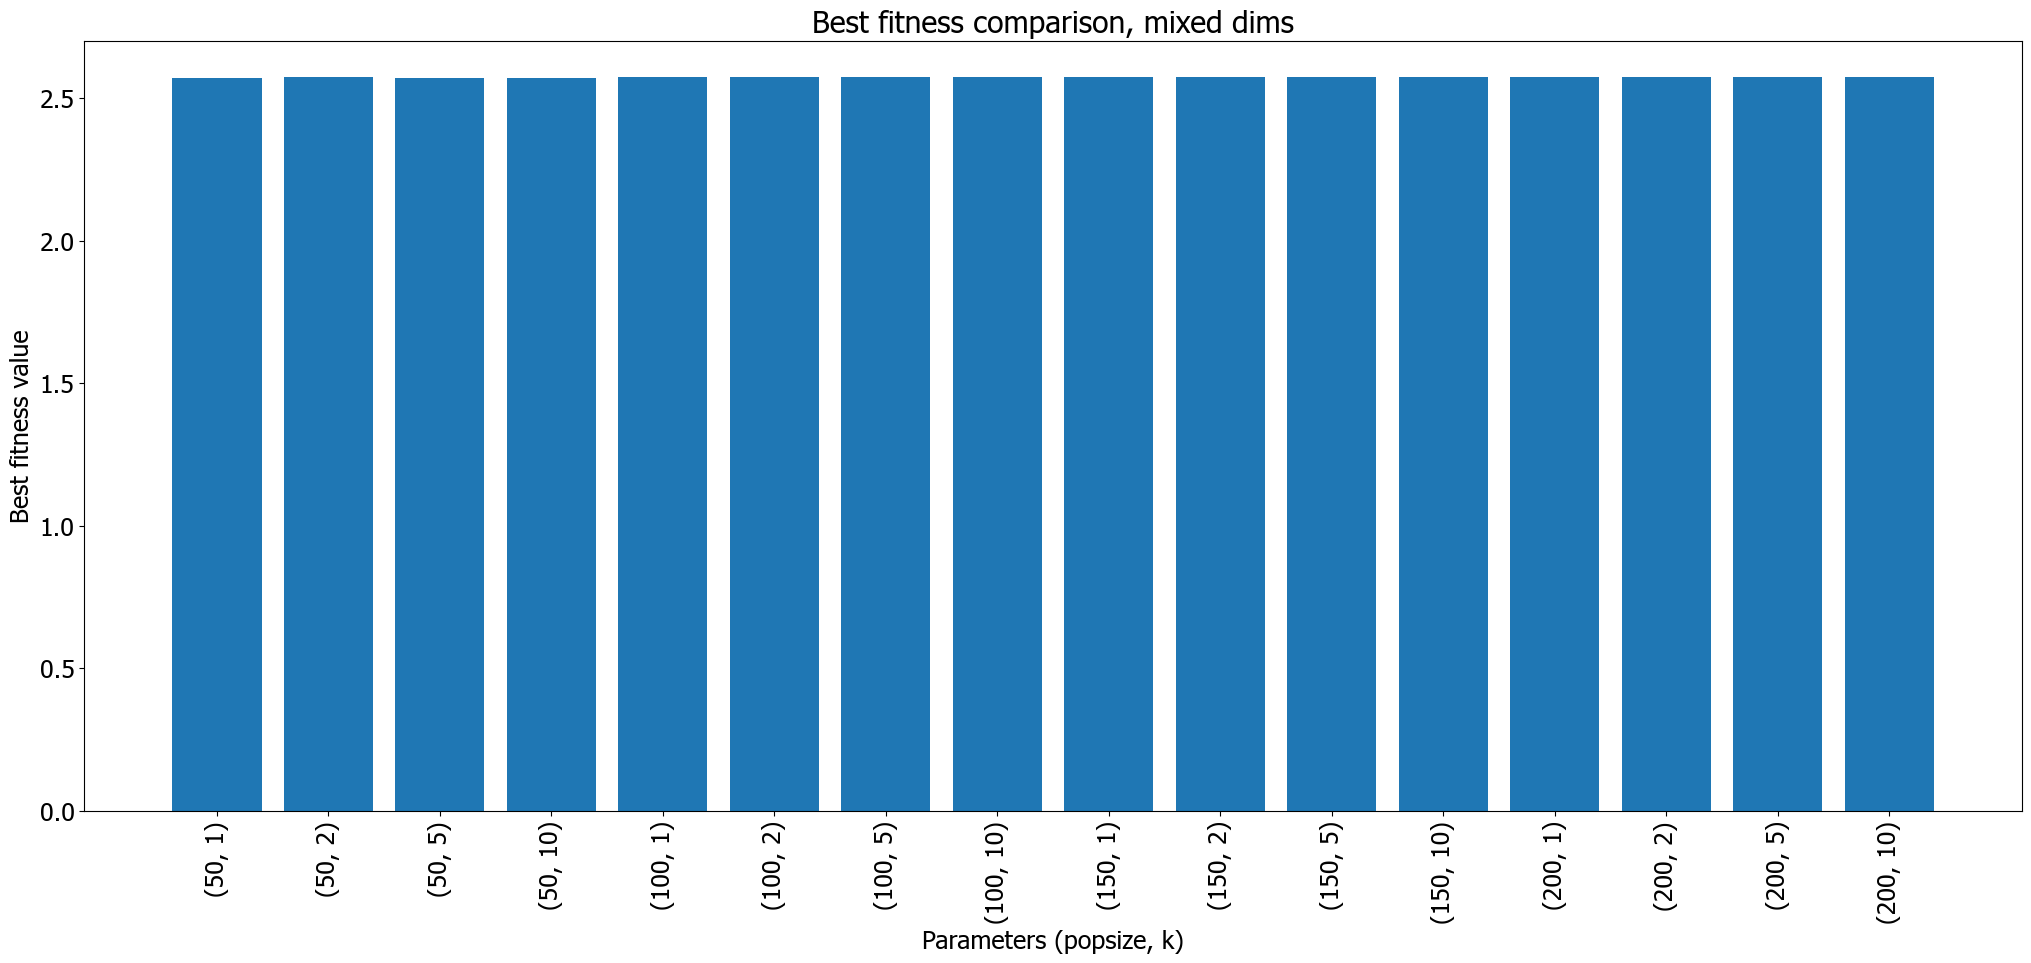

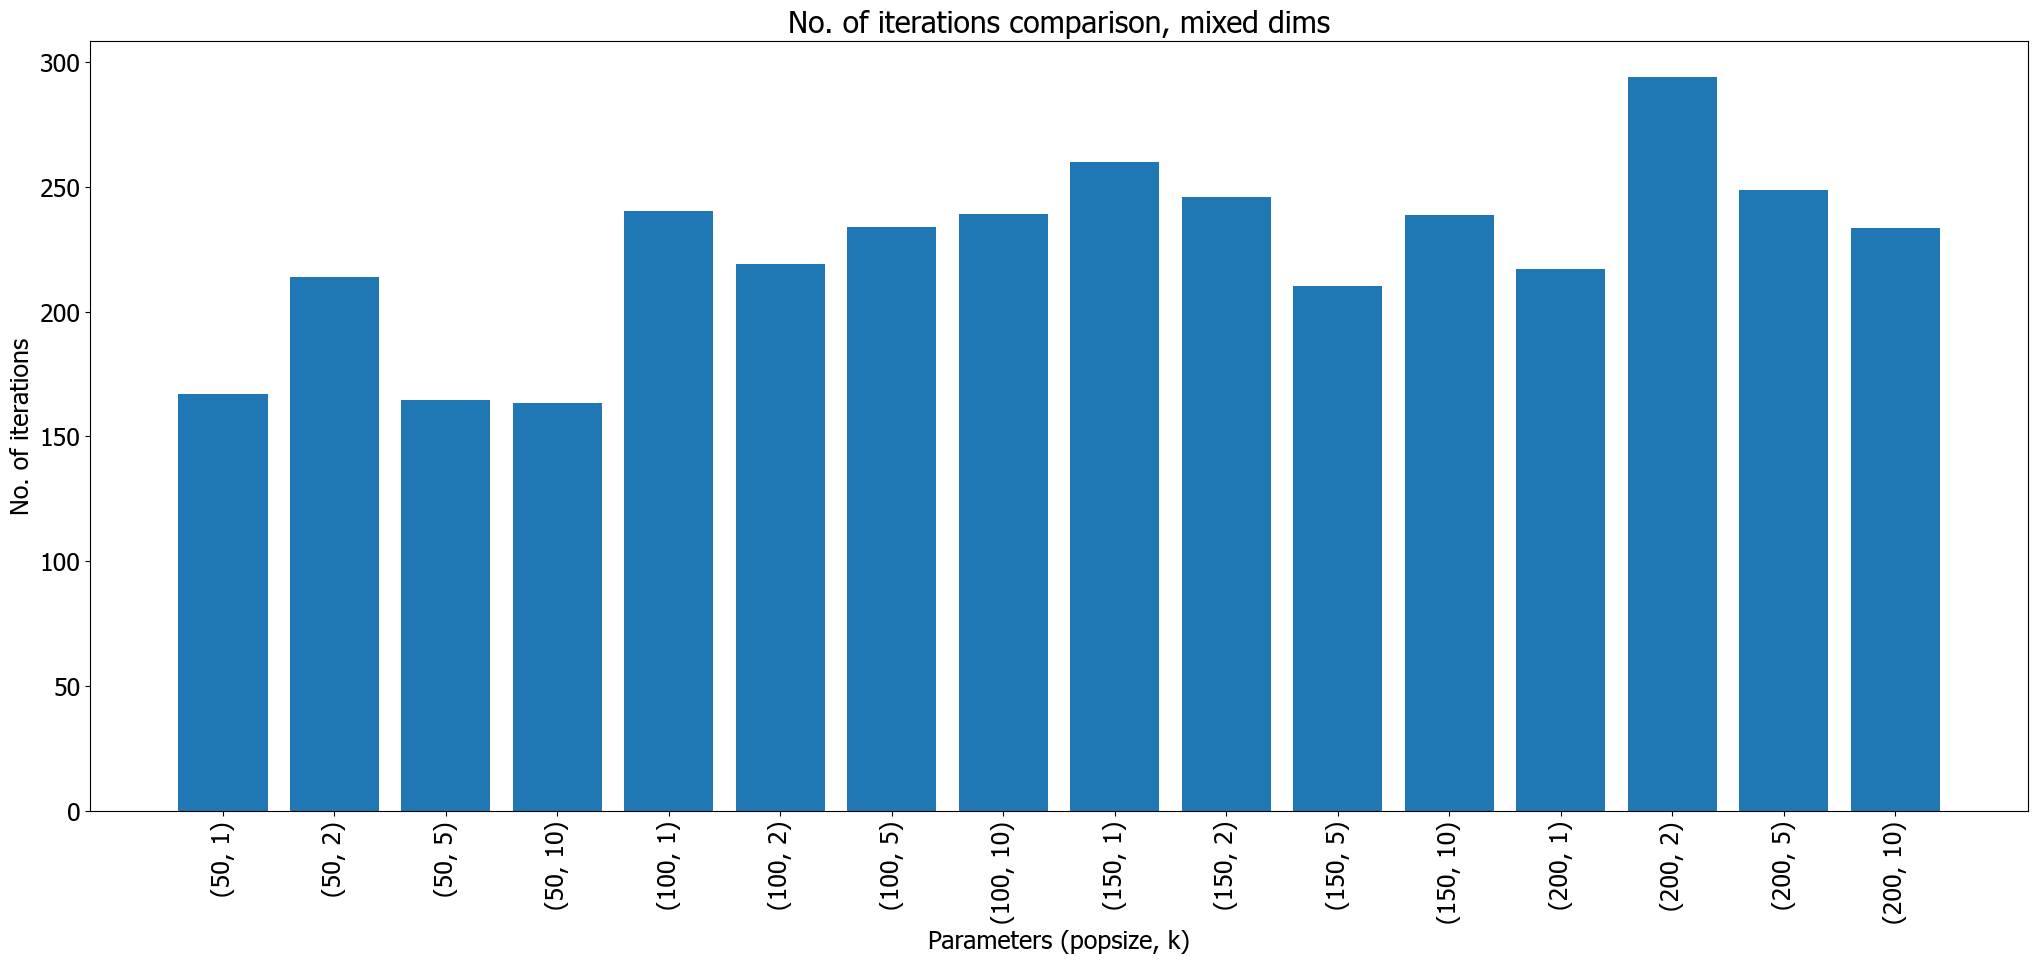

In [13]:
df_temp = plot_comparisons(df=df)
df = pd.concat([df, df_temp], axis=1)

In [14]:
df

Parameters mixed dims  Best fitness mixed dims  Iterations mixed dims
0                (50, 1)                 2.572099                  167.0
1                (50, 2)                 2.572474                  213.7
2                (50, 5)                 2.572232                  164.6
3               (50, 10)                 2.571771                  163.2
4               (100, 1)                 2.572753                  240.2
5               (100, 2)                 2.572485                  218.9
6               (100, 5)                 2.572703                  233.9
7              (100, 10)                 2.572609                  239.0
8               (150, 1)                 2.572839                  260.1
9               (150, 2)                 2.572803                  246.0
10              (150, 5)                 2.572726                  210.4
11             (150, 10)                 2.572783                  238.6
12              (200, 1)                 2.572839                  217.2
13              (200, 2)                 2.572836                  293.8
14              (200, 5)                 2.572831                  248.7
15             (200, 10)                 2.572783                  233.6

### Population of a singe dimension without change of dimensions in mutation

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [20:18<00:00, 304.72s/it]


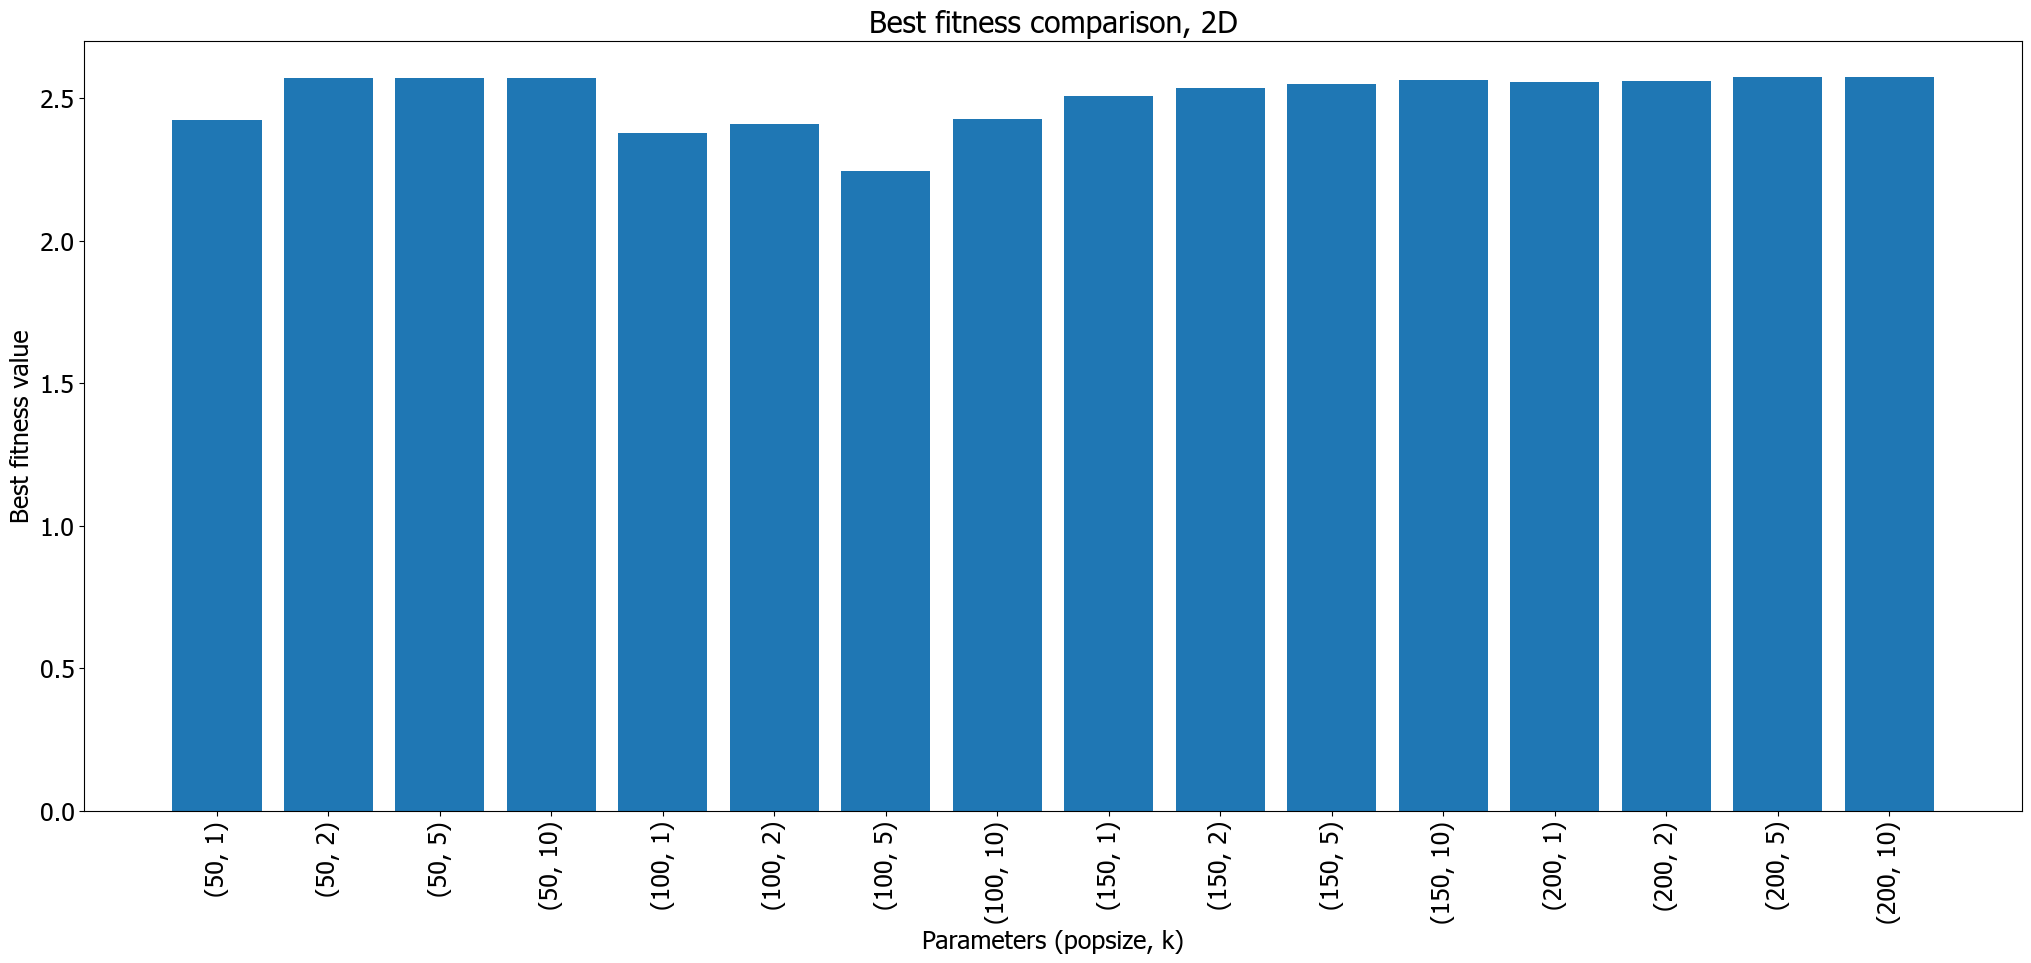

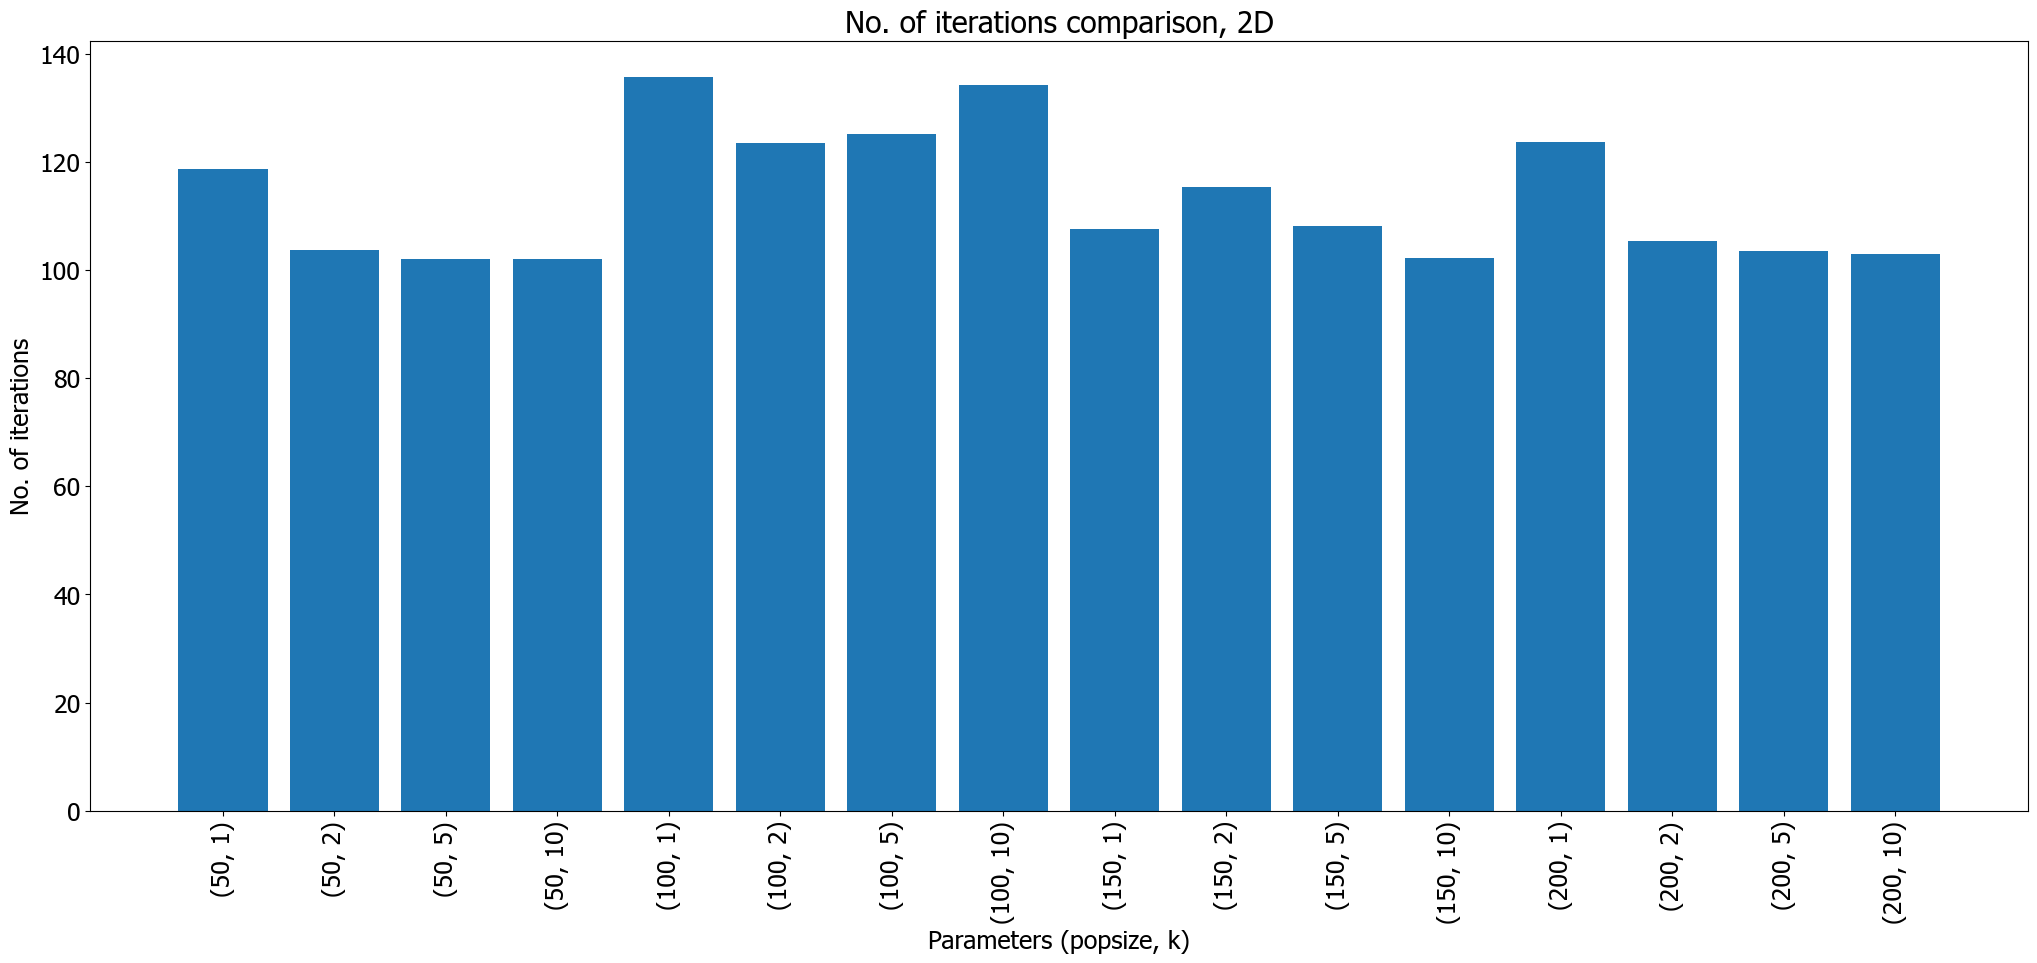

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [21:17<00:00, 319.34s/it]


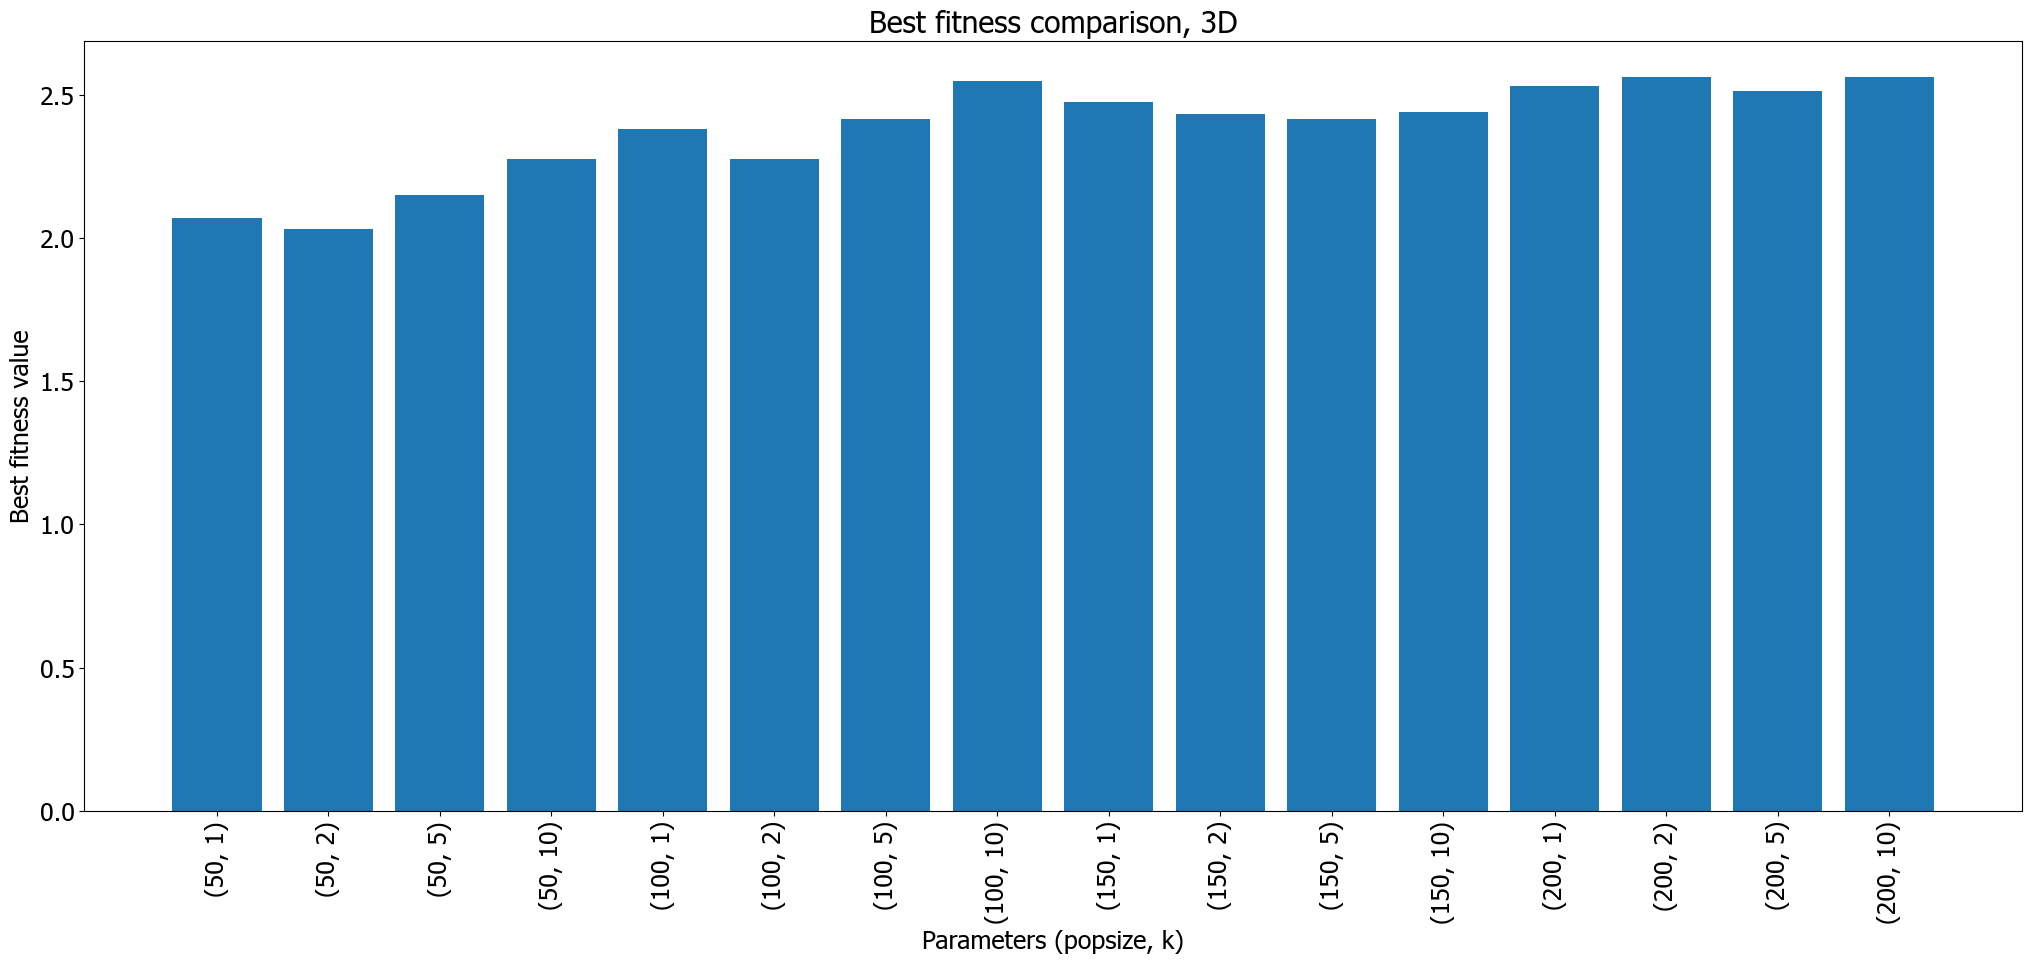

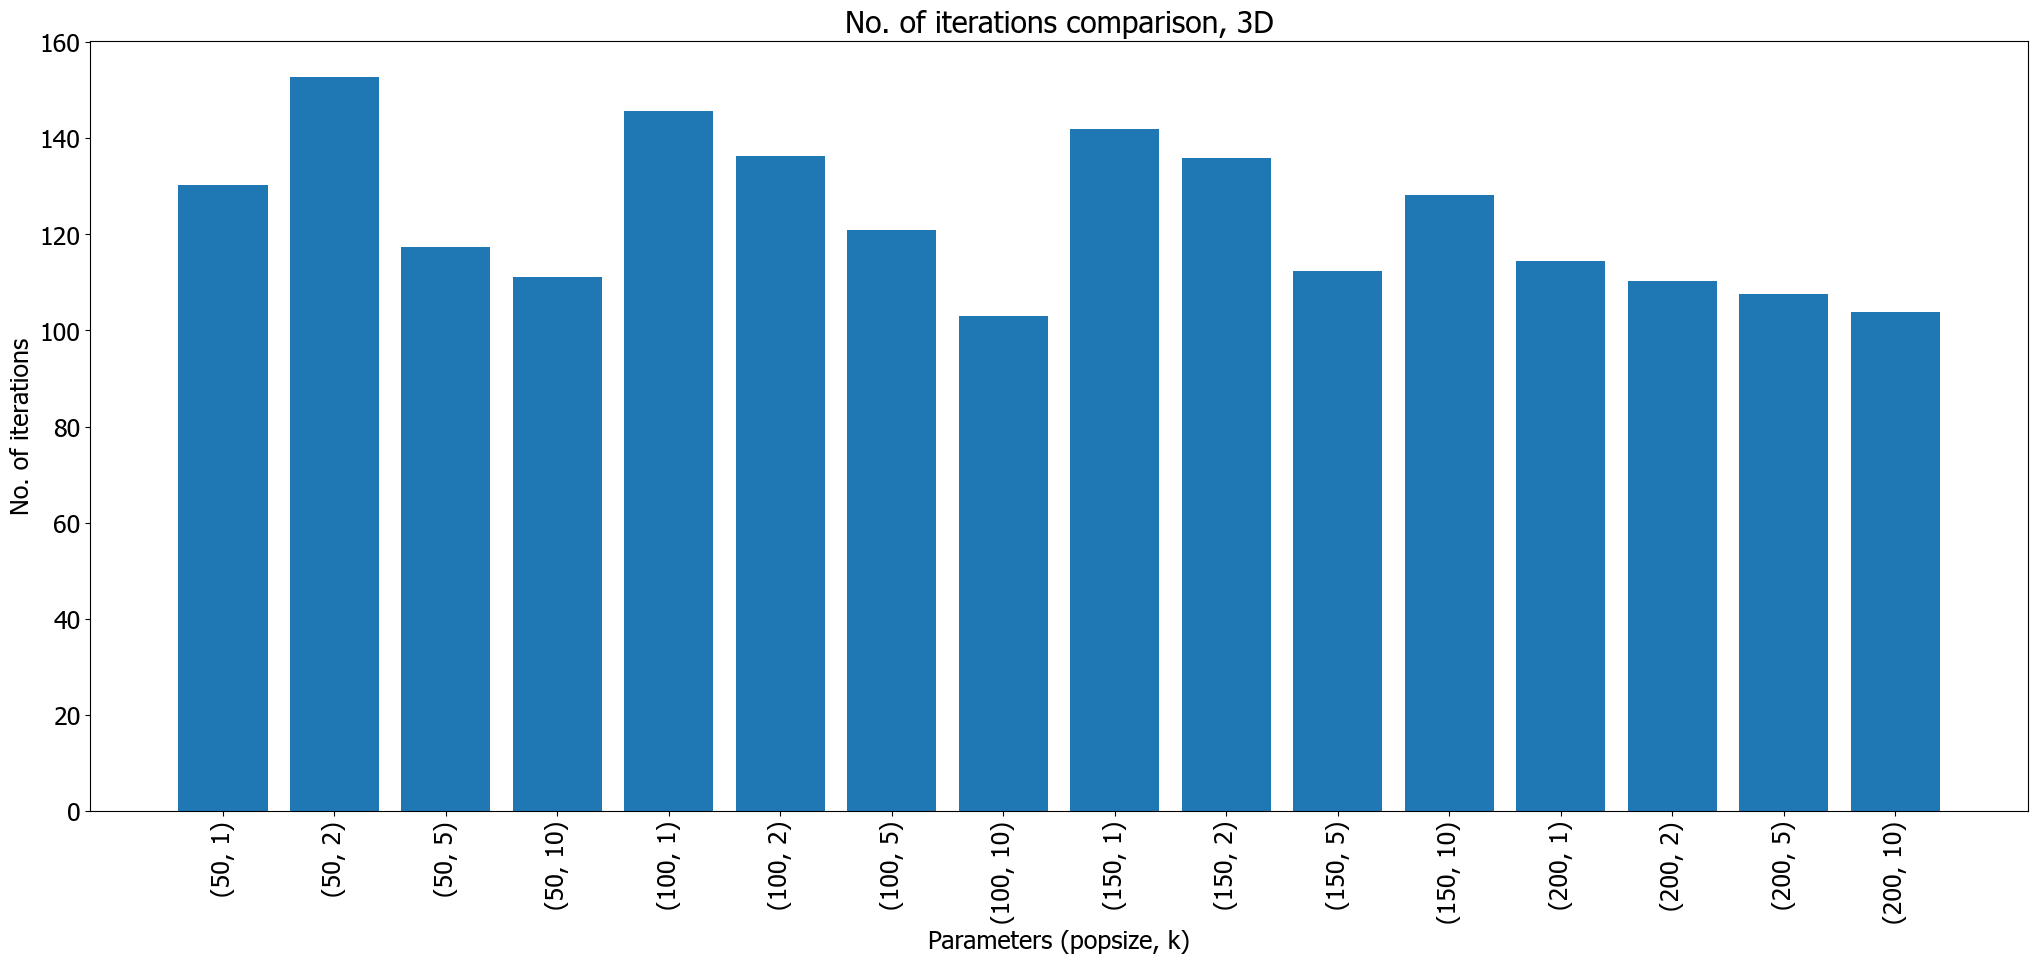

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [21:06<00:00, 316.50s/it]


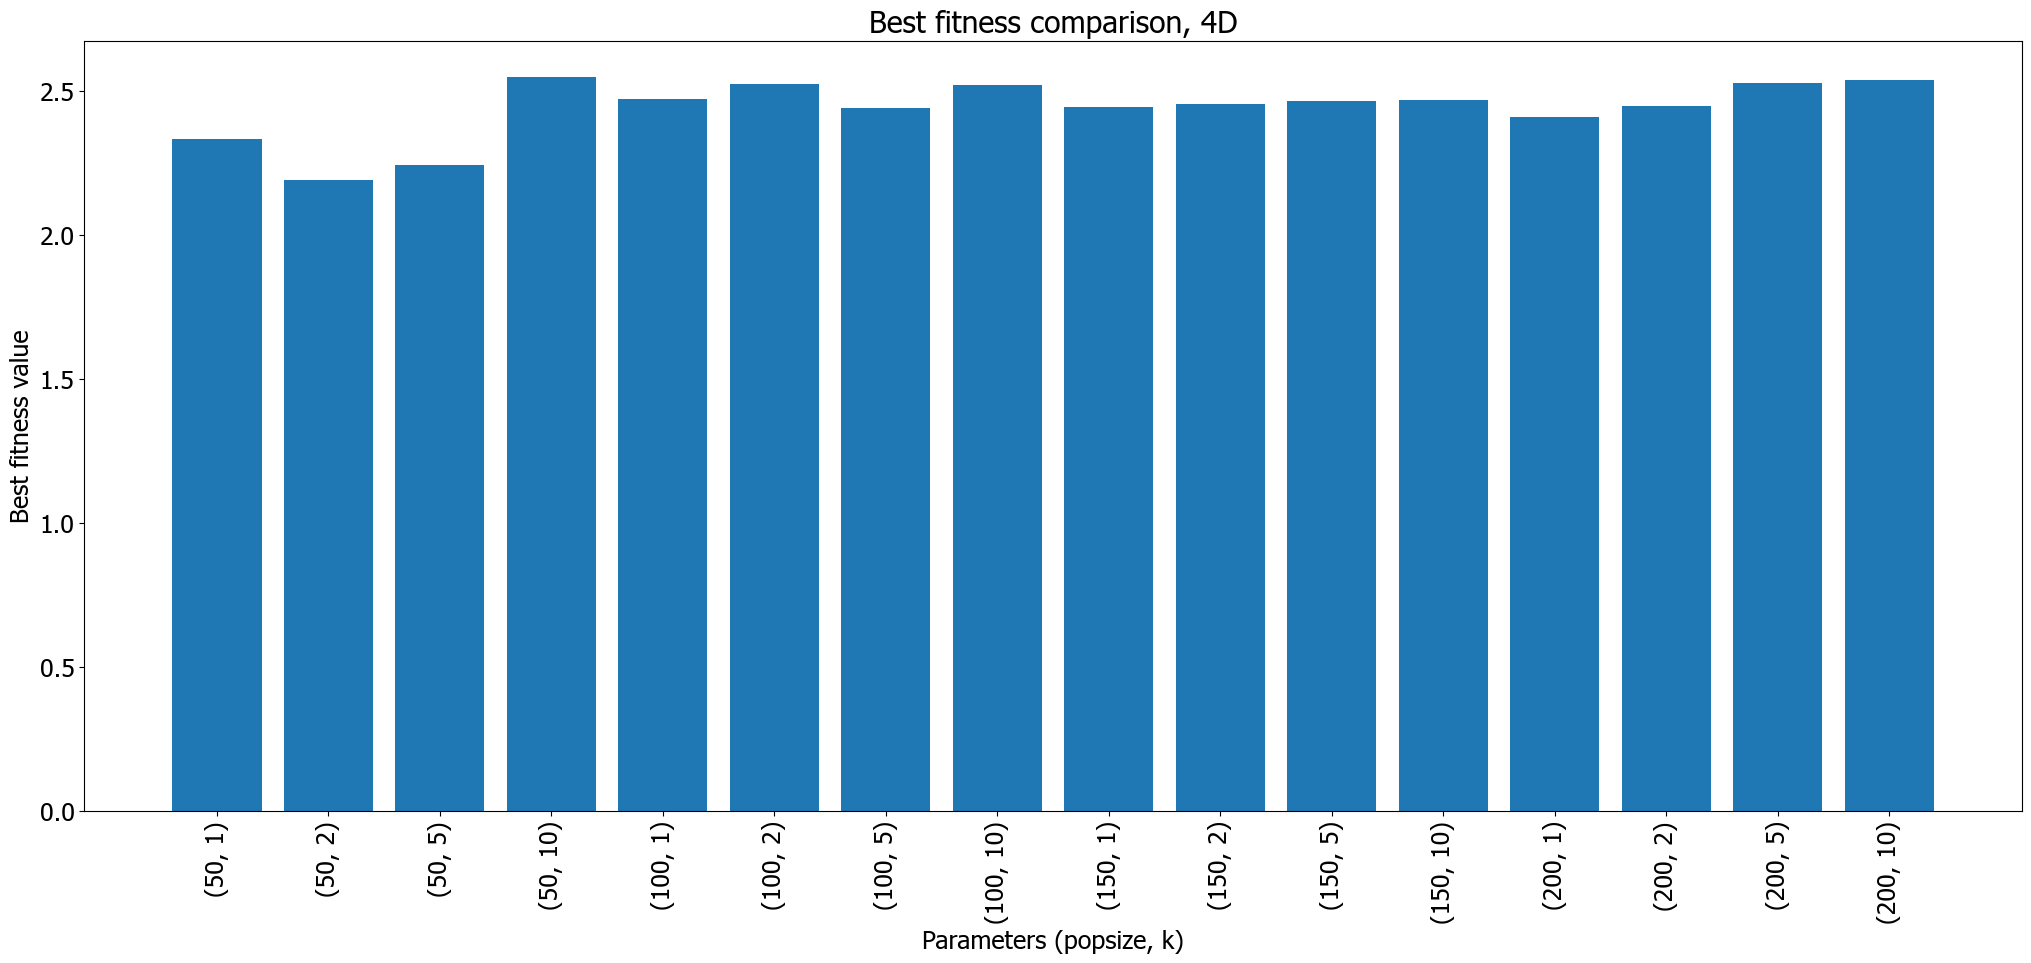

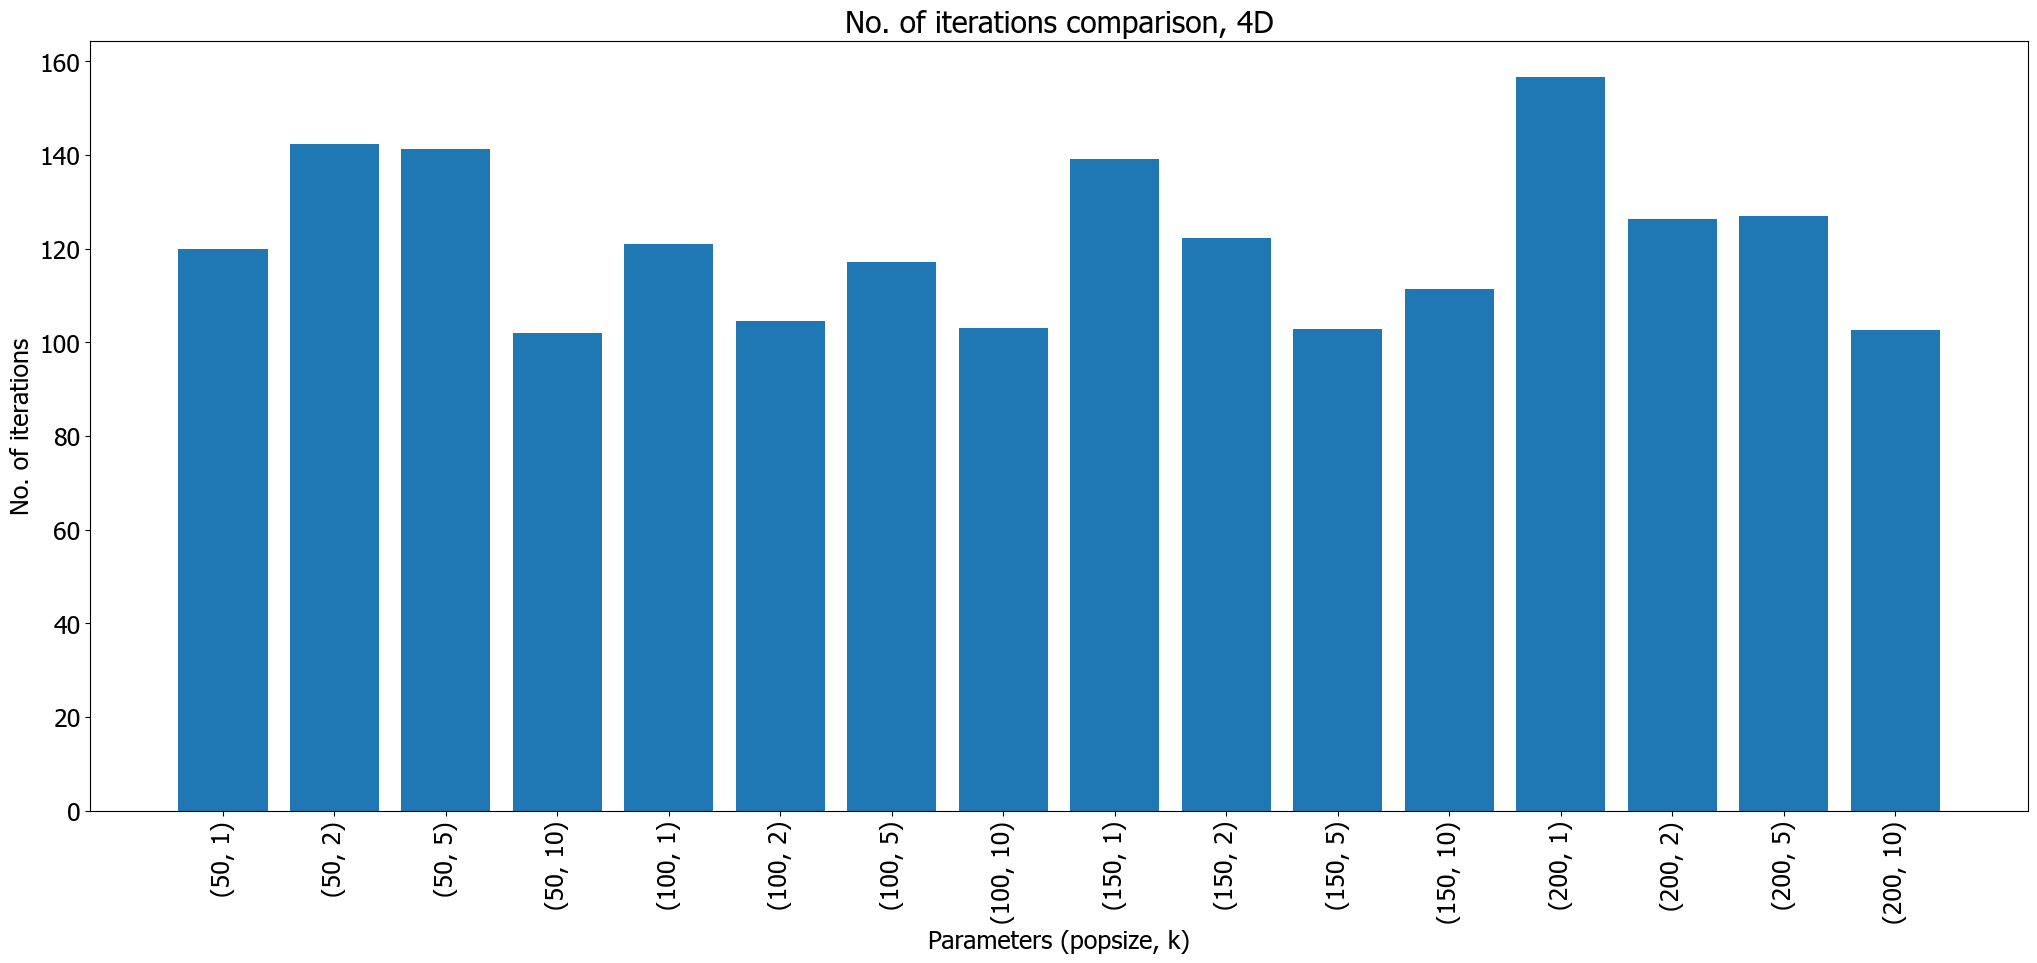

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [22:05<00:00, 331.34s/it]


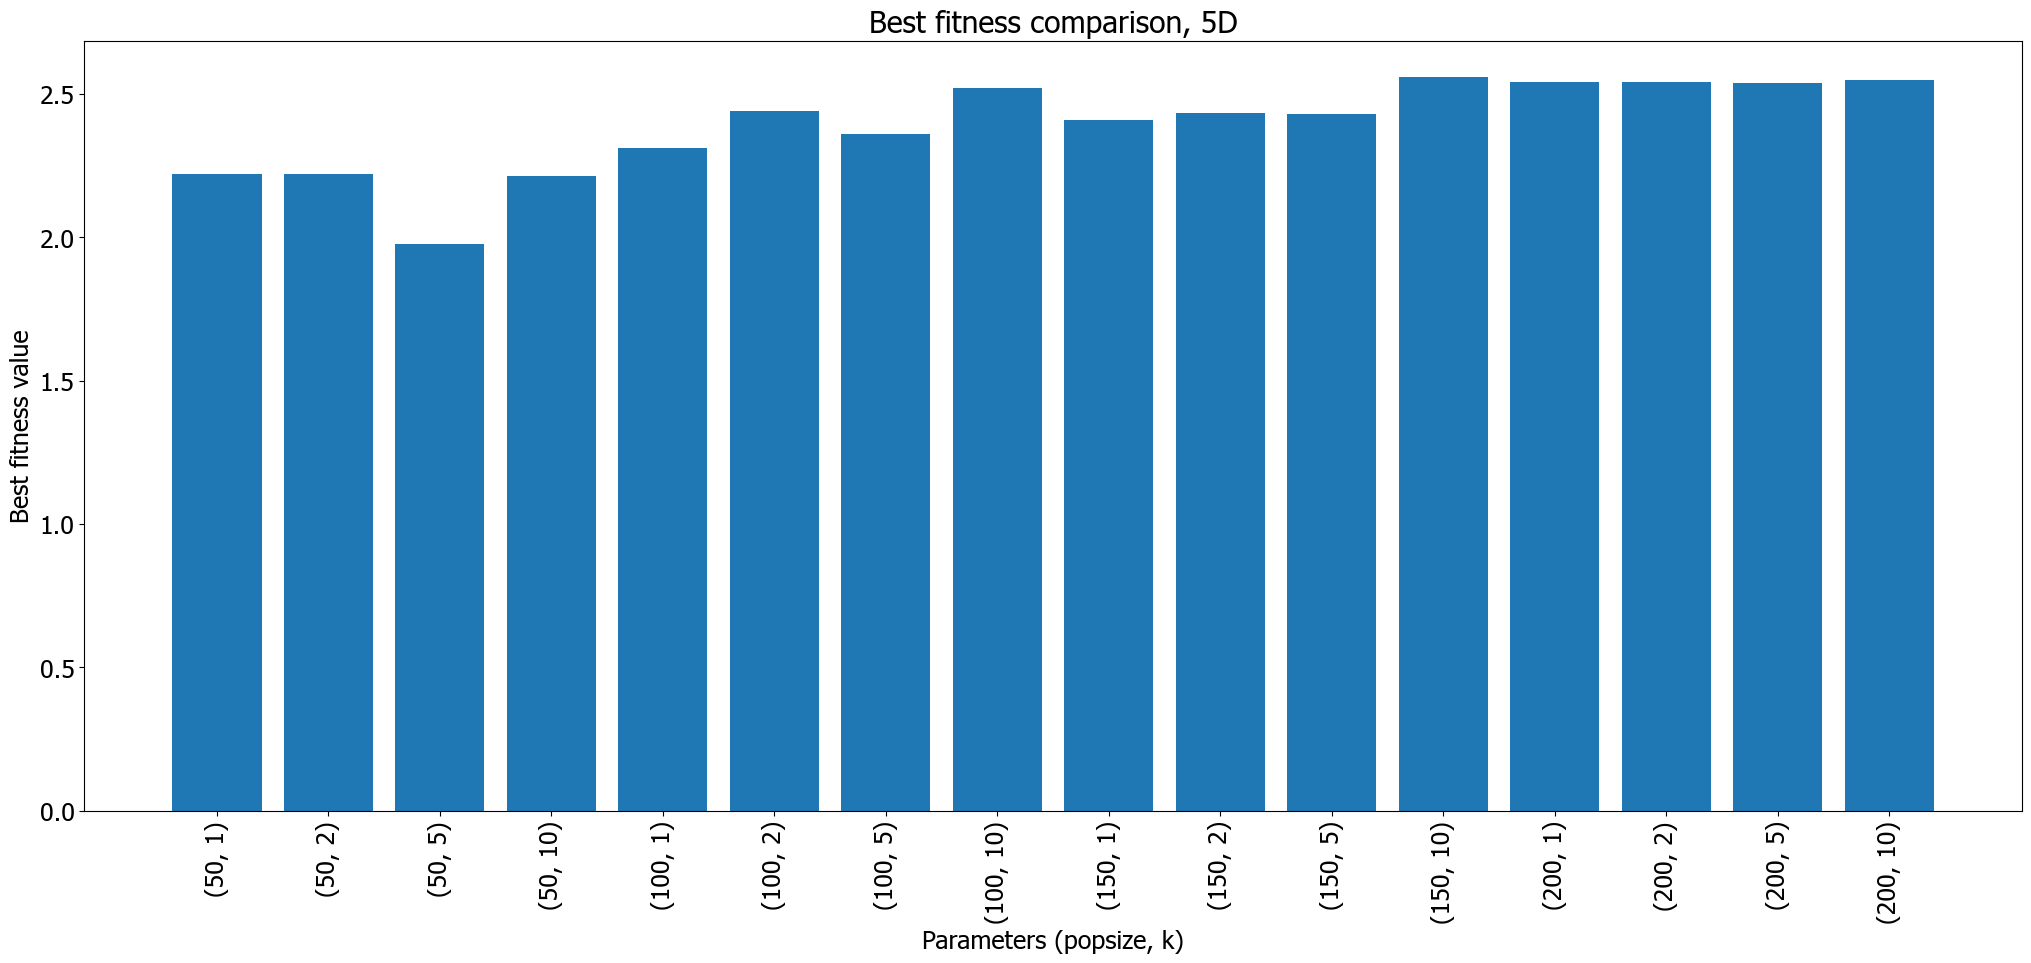

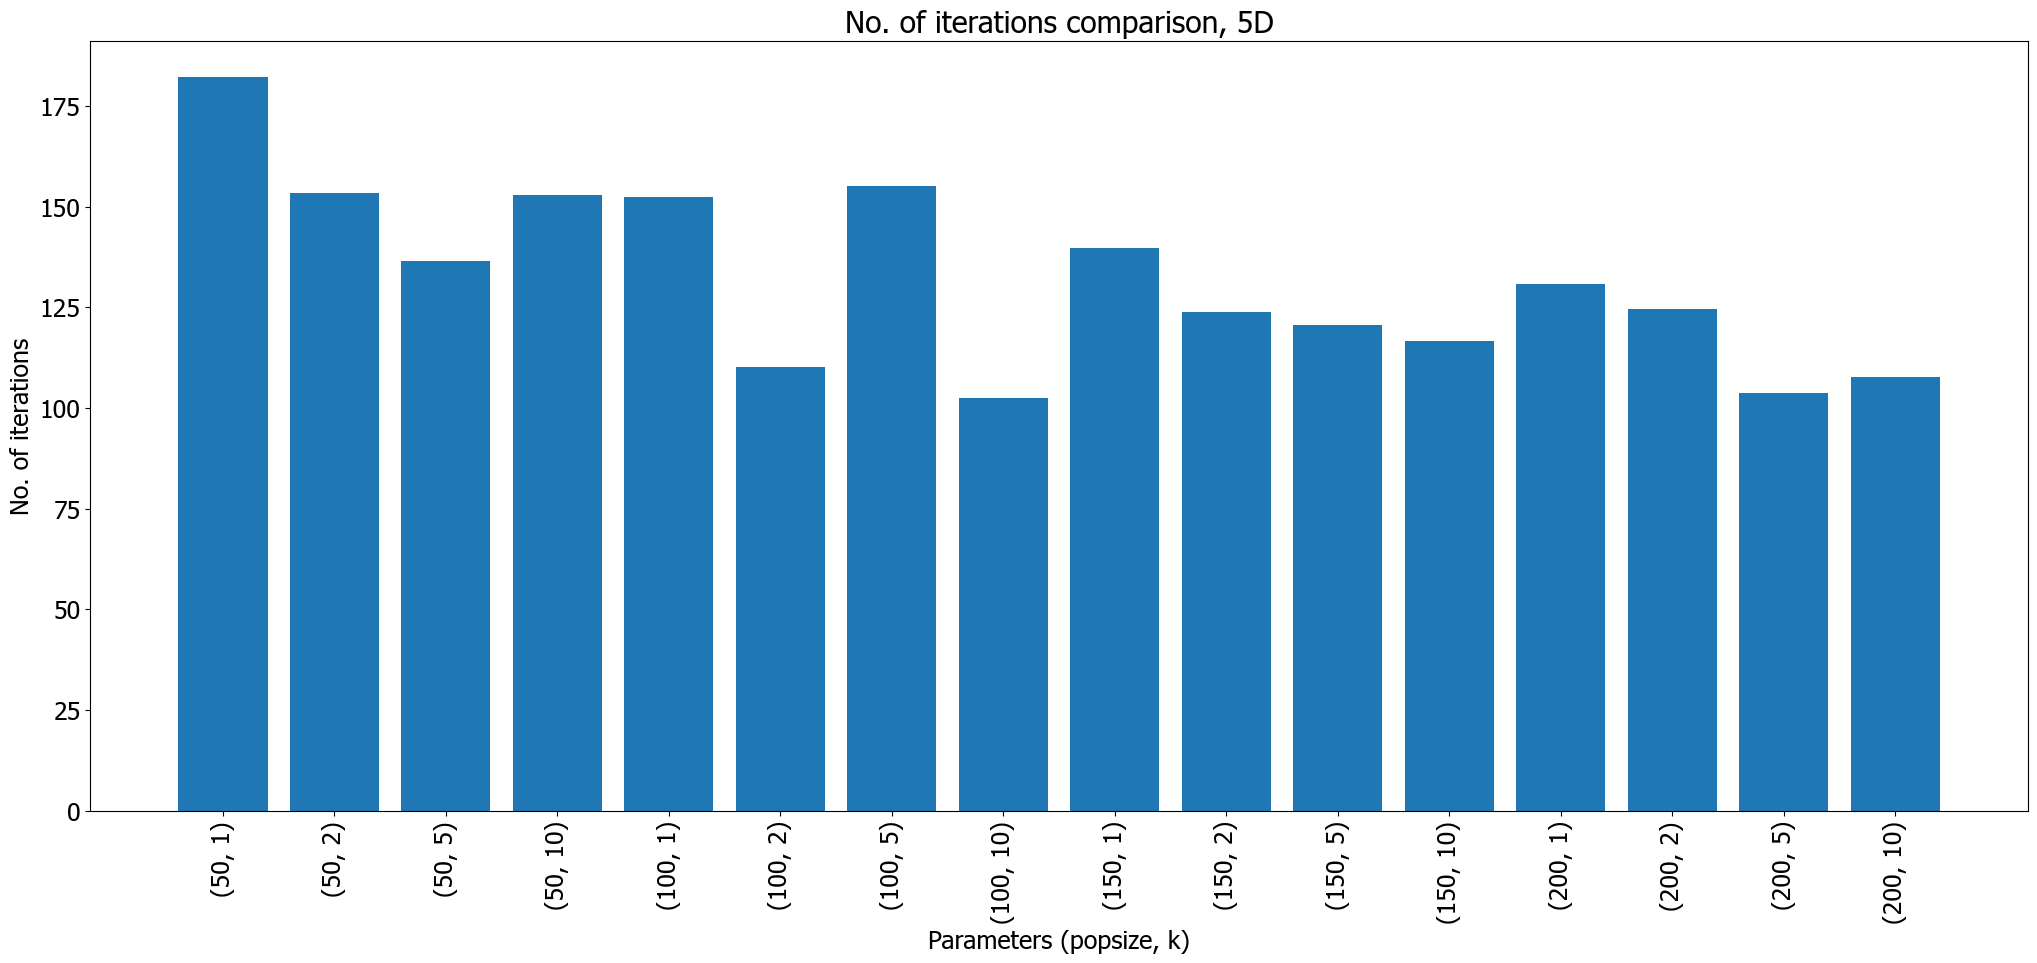

In [15]:
for dim in range(2, 6):
    df_temp = plot_comparisons(df, dim)
    df = pd.concat([df, df_temp], axis=1)

In [16]:
df

Parameters mixed dims  Best fitness mixed dims  Iterations mixed dims  \
0                (50, 1)                 2.572099                  167.0   
1                (50, 2)                 2.572474                  213.7   
2                (50, 5)                 2.572232                  164.6   
3               (50, 10)                 2.571771                  163.2   
4               (100, 1)                 2.572753                  240.2   
5               (100, 2)                 2.572485                  218.9   
6               (100, 5)                 2.572703                  233.9   
7              (100, 10)                 2.572609                  239.0   
8               (150, 1)                 2.572839                  260.1   
9               (150, 2)                 2.572803                  246.0   
10              (150, 5)                 2.572726                  210.4   
11             (150, 10)                 2.572783                  238.6   
12              (200, 1)                 2.572839                  217.2   
13              (200, 2)                 2.572836                  293.8   
14              (200, 5)                 2.572831                  248.7   
15             (200, 10)                 2.572783                  233.6   

   Parameters 2D  Best fitness 2D  Iterations 2D Parameters 3D  \
0        (50, 1)         2.421950          118.7       (50, 1)   
1        (50, 2)         2.572166          103.6       (50, 2)   
2        (50, 5)         2.572166          102.0       (50, 5)   
3       (50, 10)         2.572166          102.0      (50, 10)   
4       (100, 1)         2.377773          135.6      (100, 1)   
5       (100, 2)         2.409922          123.5      (100, 2)   
6       (100, 5)         2.243520          125.1      (100, 5)   
7      (100, 10)         2.426253          134.2     (100, 10)   
8       (150, 1)         2.505649          107.6      (150, 1)   
9       (150, 2)         2.537076          115.3      (150, 2)   
10      (150, 5)         2.549279          108.2      (150, 5)   
11     (150, 10)         2.564389          102.2     (150, 10)   
12      (200, 1)         2.556187          123.6      (200, 1)   
13      (200, 2)         2.560163          105.3      (200, 2)   
14      (200, 5)         2.572617          103.5      (200, 5)   
15     (200, 10)         2.572617          103.0     (200, 10)   

    Best fitness 3D  Iterations 3D Parameters 4D  Best fitness 4D  \
0          2.068911          130.3       (50, 1)         2.333243   
1          2.032668          152.7       (50, 2)         2.188085   
2          2.147977          117.4       (50, 5)         2.243236   
3          2.275386          111.1      (50, 10)         2.545728   
4          2.379755          145.7      (100, 1)         2.472010   
5          2.276762          136.4      (100, 2)         2.521331   
6          2.415446          121.0      (100, 5)         2.439718   
7          2.546262          103.0     (100, 10)         2.519614   
8          2.473216          141.9      (150, 1)         2.443675   
9          2.433891          135.9      (150, 2)         2.454604   
10         2.414072          112.4      (150, 5)         2.464903   
11         2.439341          128.3     (150, 10)         2.468528   
12         2.531470          114.4      (200, 1)         2.408965   
13         2.560042          110.3      (200, 2)         2.445352   
14         2.511060          107.6      (200, 5)         2.526423   
15         2.560292          103.9     (200, 10)         2.537441   

    Iterations 4D Parameters 5D  Best fitness 5D  Iterations 5D  
0           119.9       (50, 1)         2.221048          182.1  
1           142.3       (50, 2)         2.221174          153.3  
2           141.4       (50, 5)         1.978642          136.5  
3           102.1      (50, 10)         2.213248          152.8  
4           121.0      (100, 1)         2.313324          152.3  
5           104.5

In [17]:
def popsize_influence(dims=None):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({'font.size': 18, 'font.family': 'Tahoma'})

    for popsize in range(50, 250, 50):
        results = {}
        iters = []
        if not dims:
            population = generate_population(popsize)
        else:
            population = generate_population(popsize, dims)
        for tournament_size in [1, 2, 5, 10]:
            if not dims:
                res = evolve(population, popsize, tournament_size, change_dim=True)
            else:
                res = evolve(population, popsize, tournament_size)
            results[str(tournament_size)] = res
            iters.append(len(res))

        for size, res in results.items():
            plt.plot(res, label=f"Tournament size: {size}")
        plt.title(f"Population size of {popsize}")
        plt.xlabel(f"No. of generations, total: {max(iters)}")
        plt.ylabel("Fitness value")
        plt.legend()
        plt.xlim(0, 20)
        plt.show()

##### Note: (x-axis is limited to be seen better)

### Population of mixed dimensions with change of dimensions in mutation

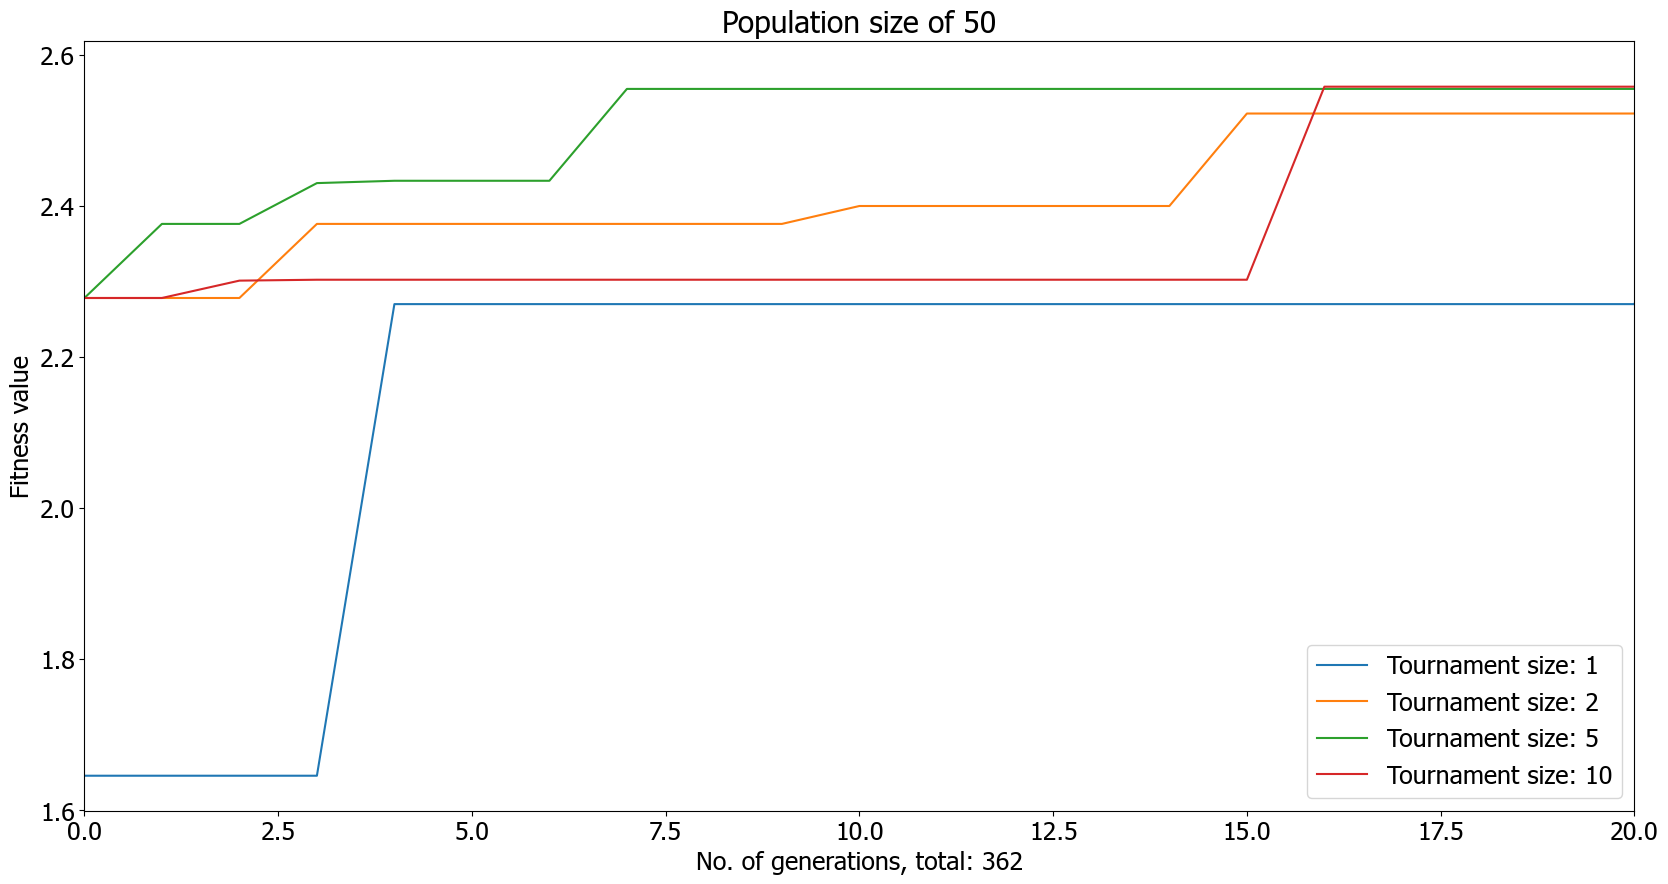

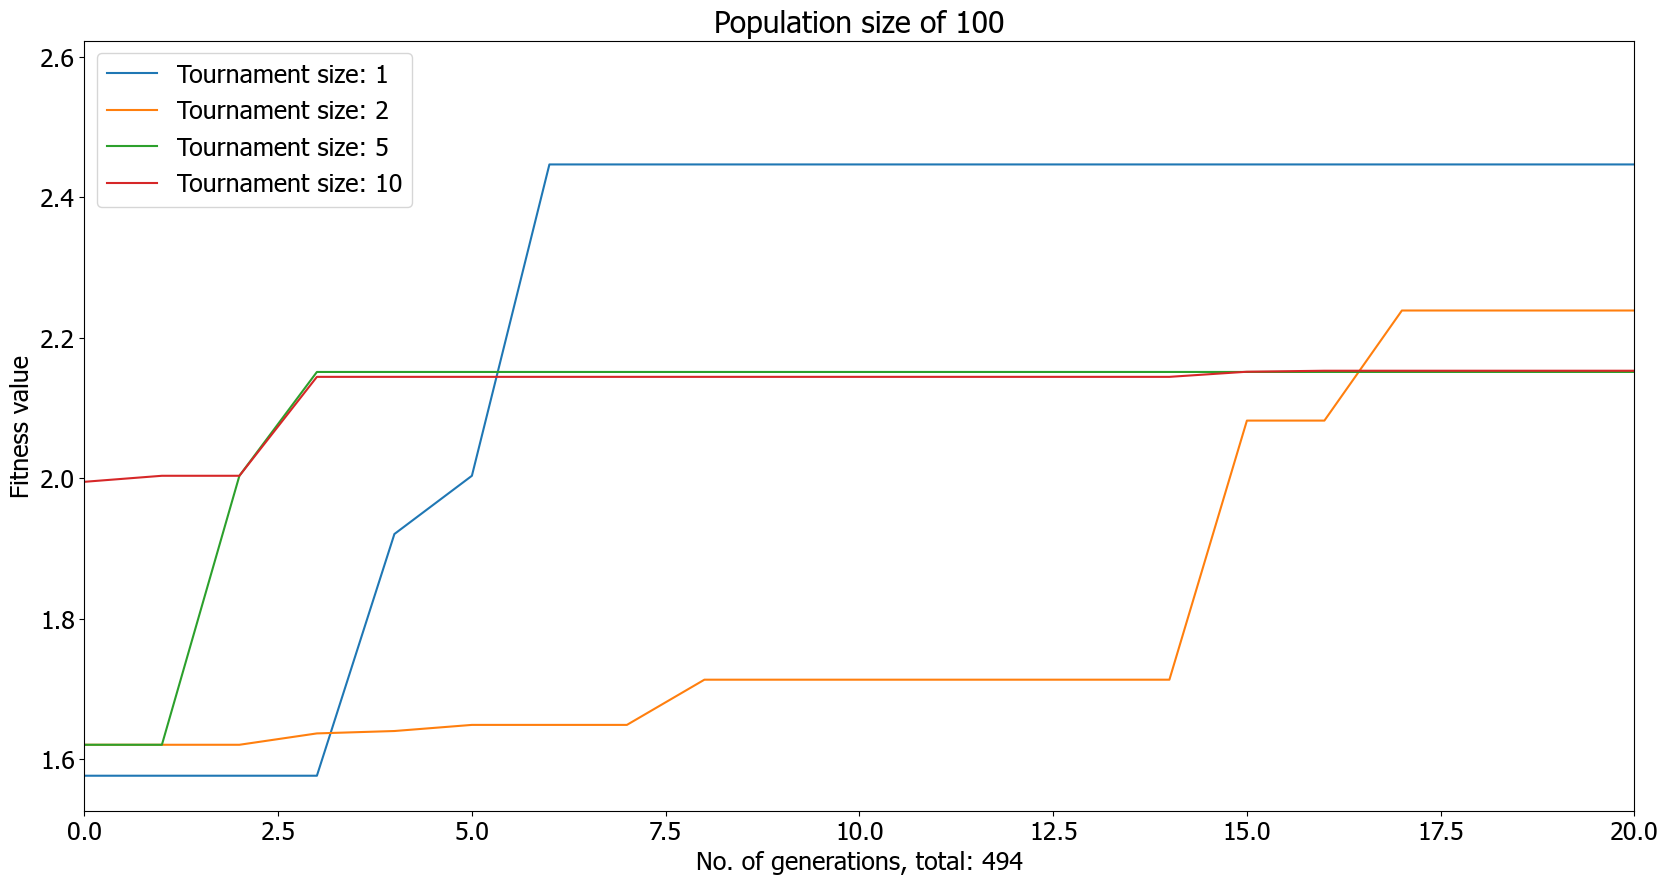

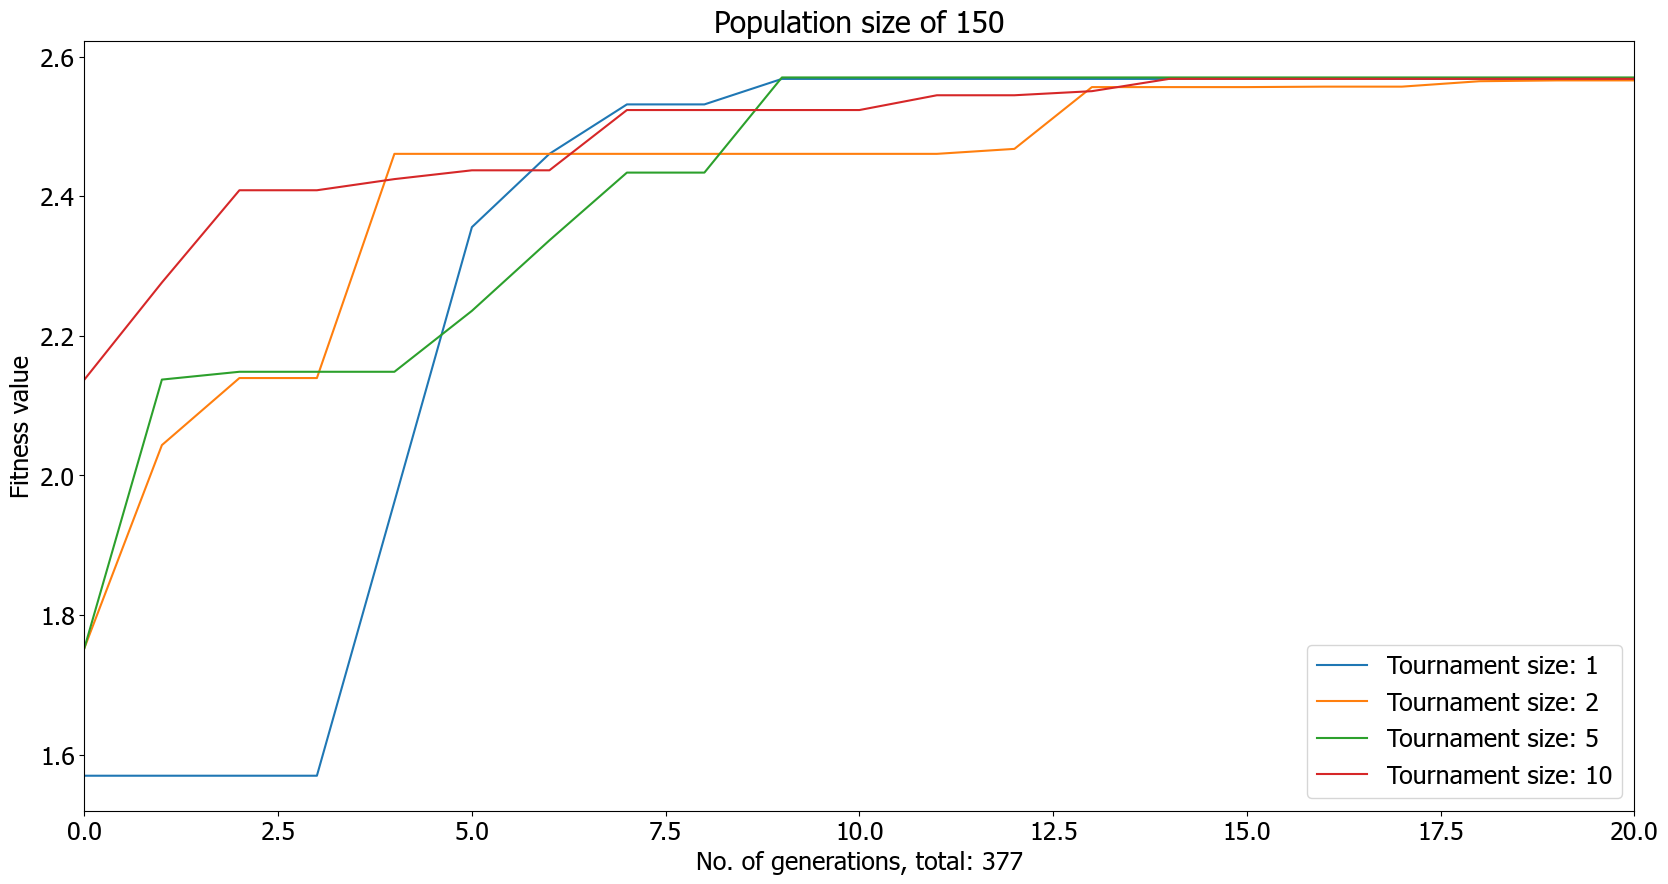

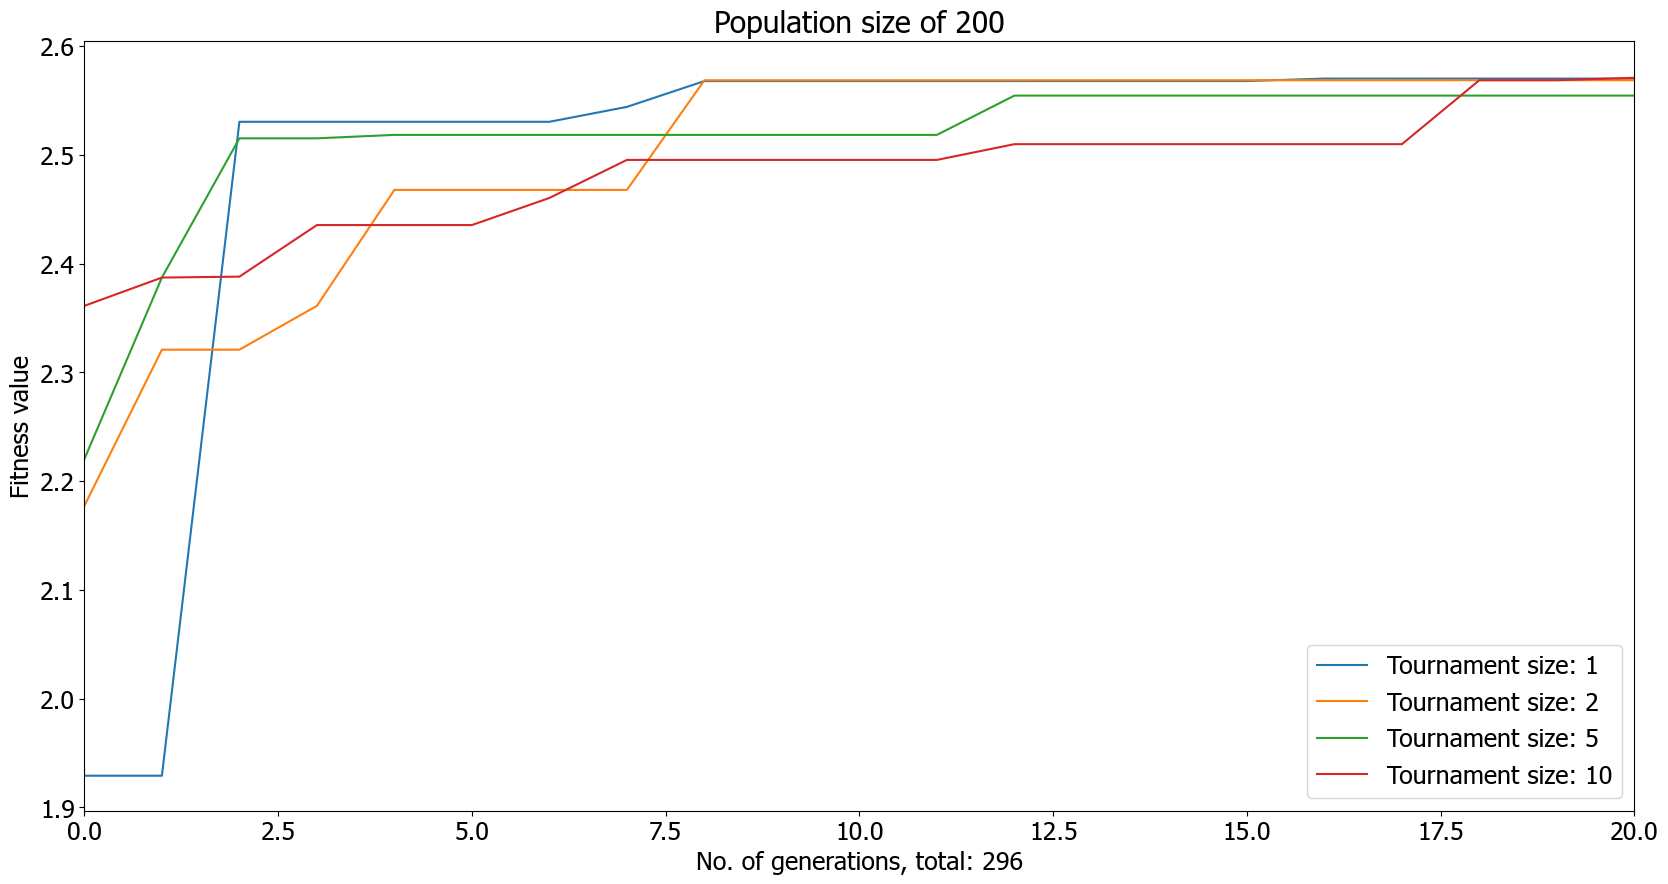

In [18]:
popsize_influence()

### Population of single dimension without change of dimensions in mutation

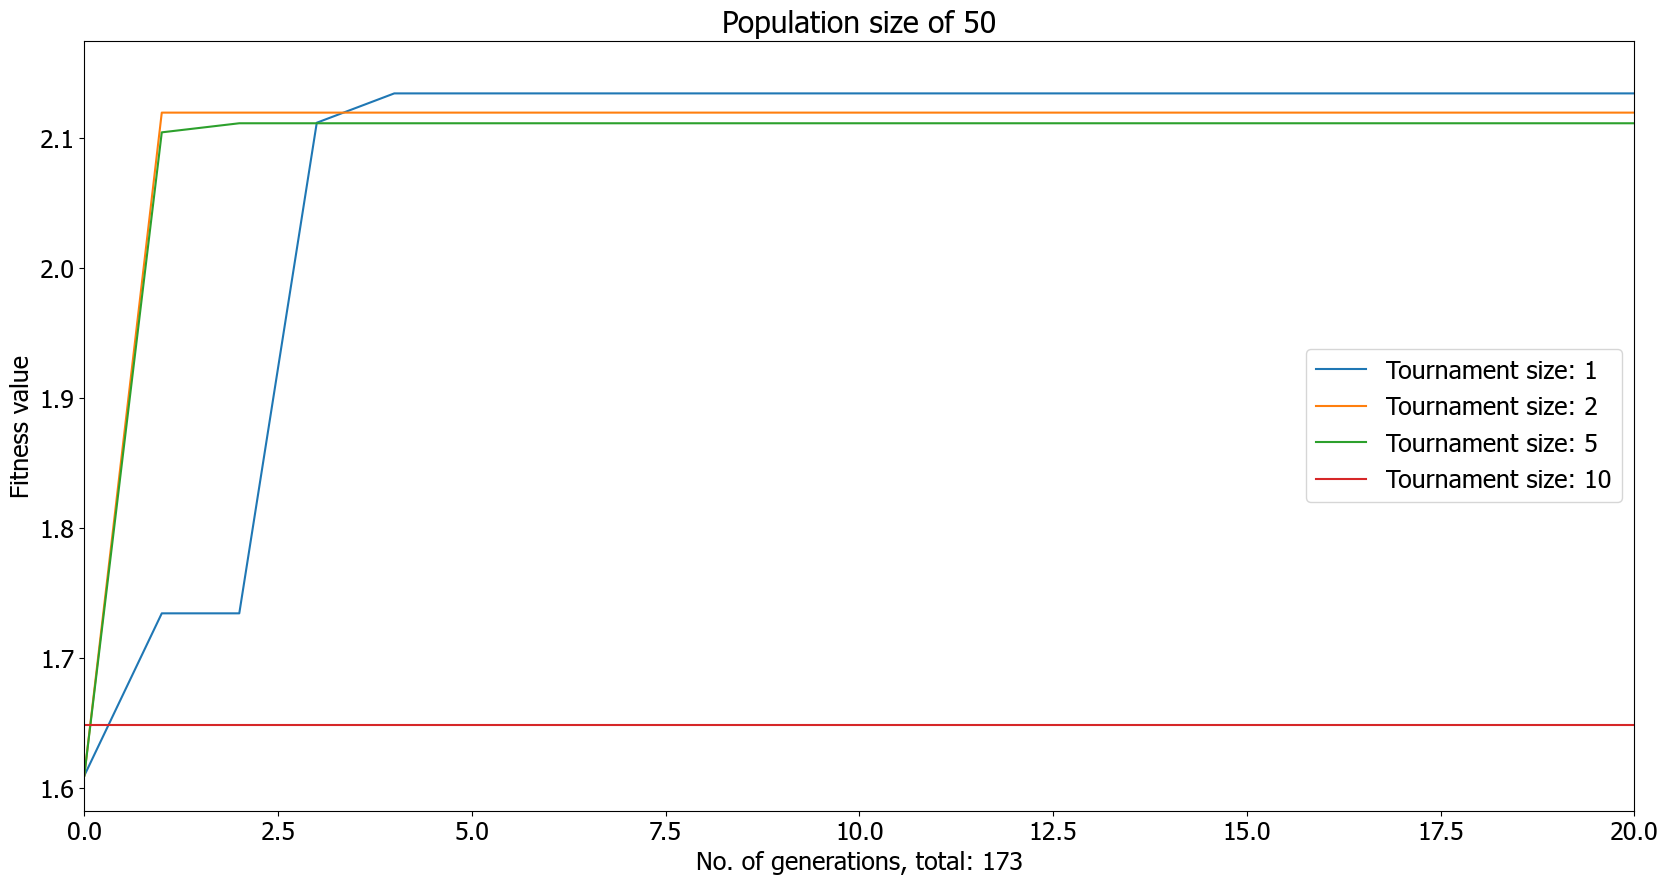

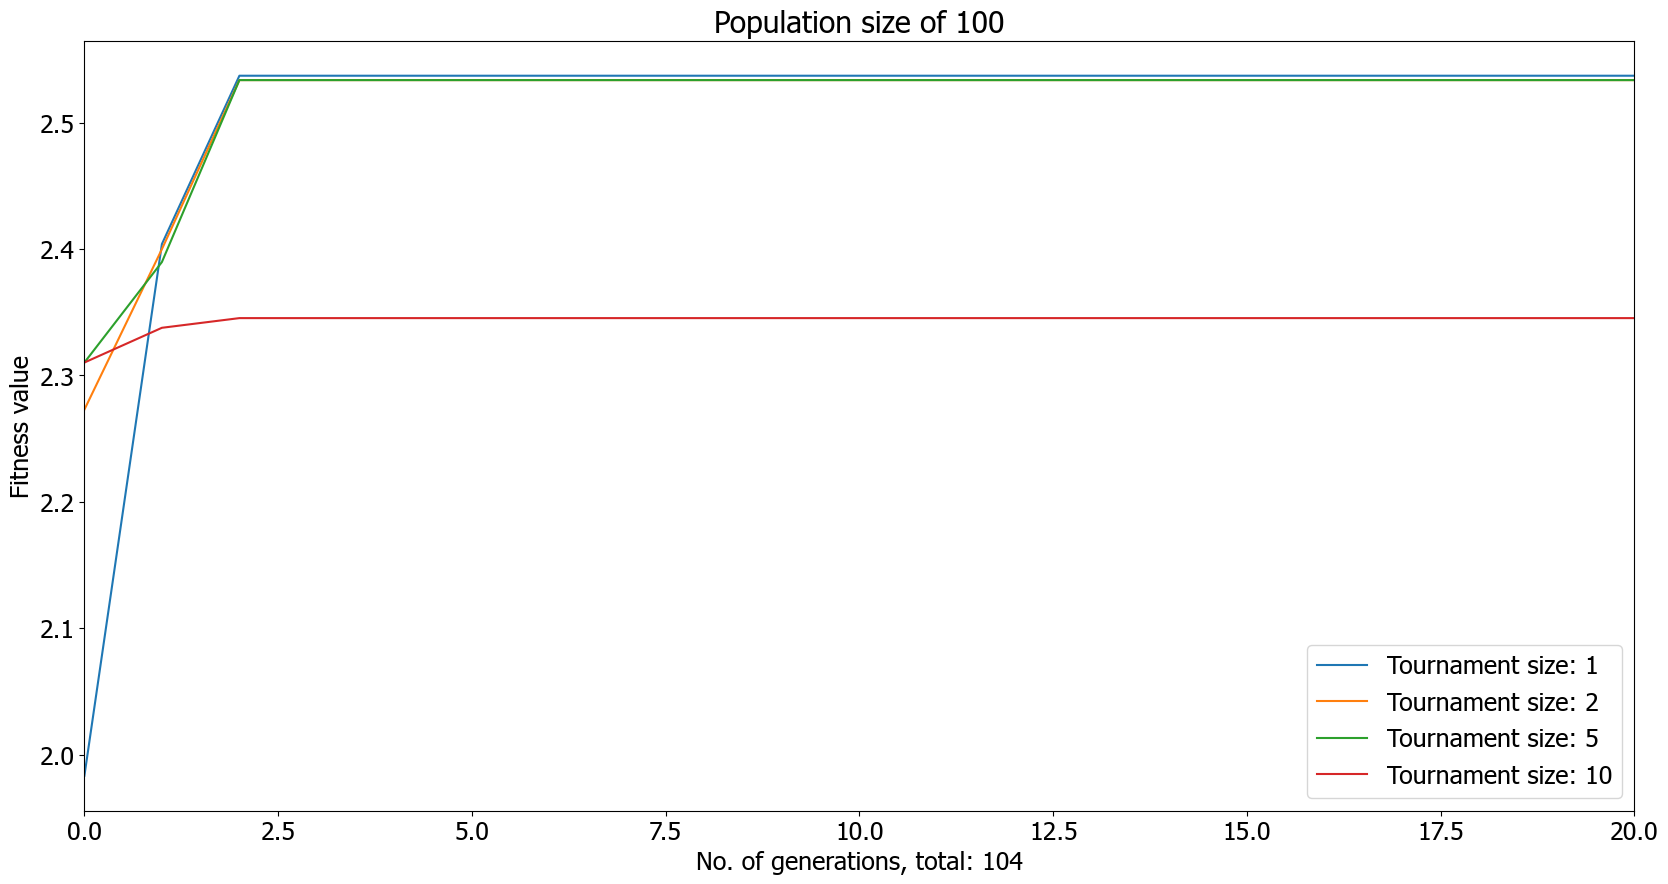

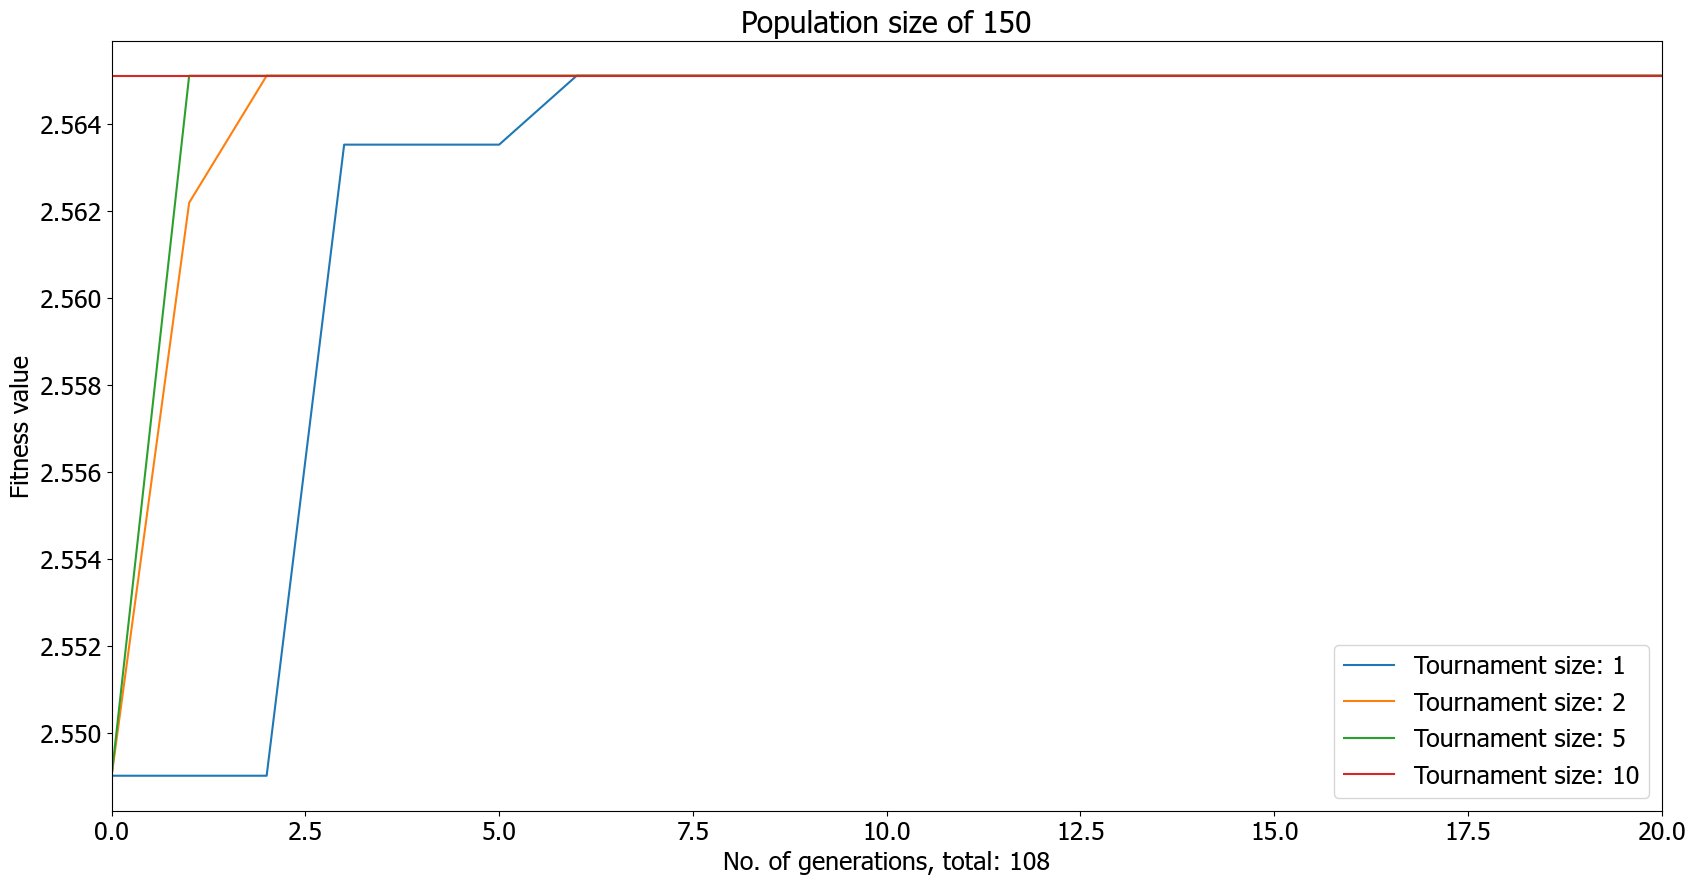

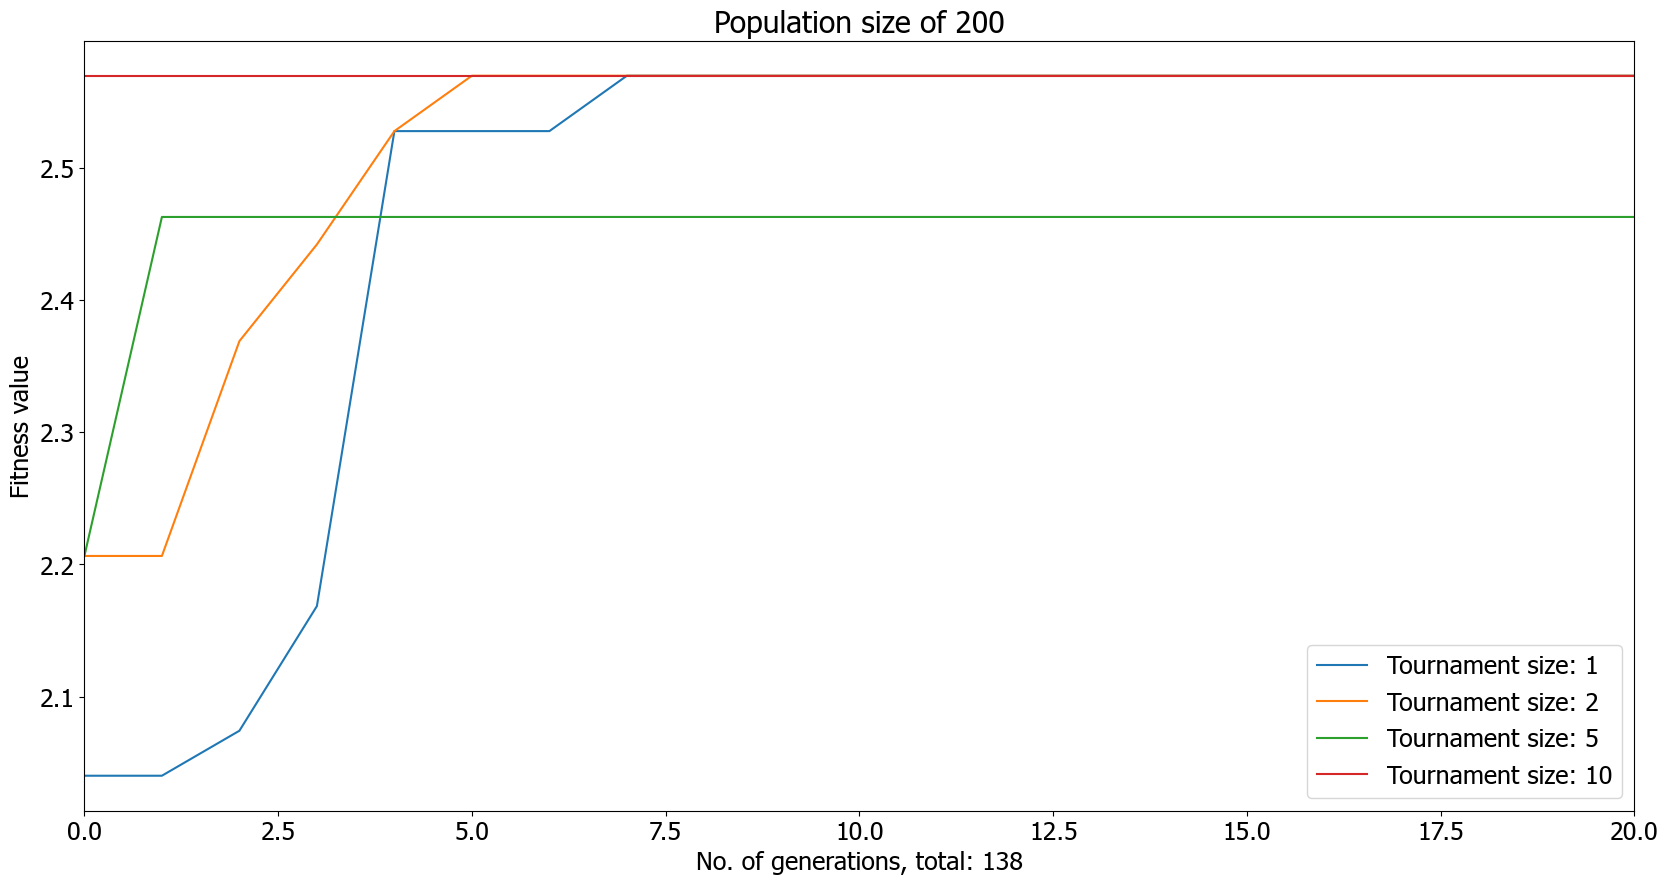

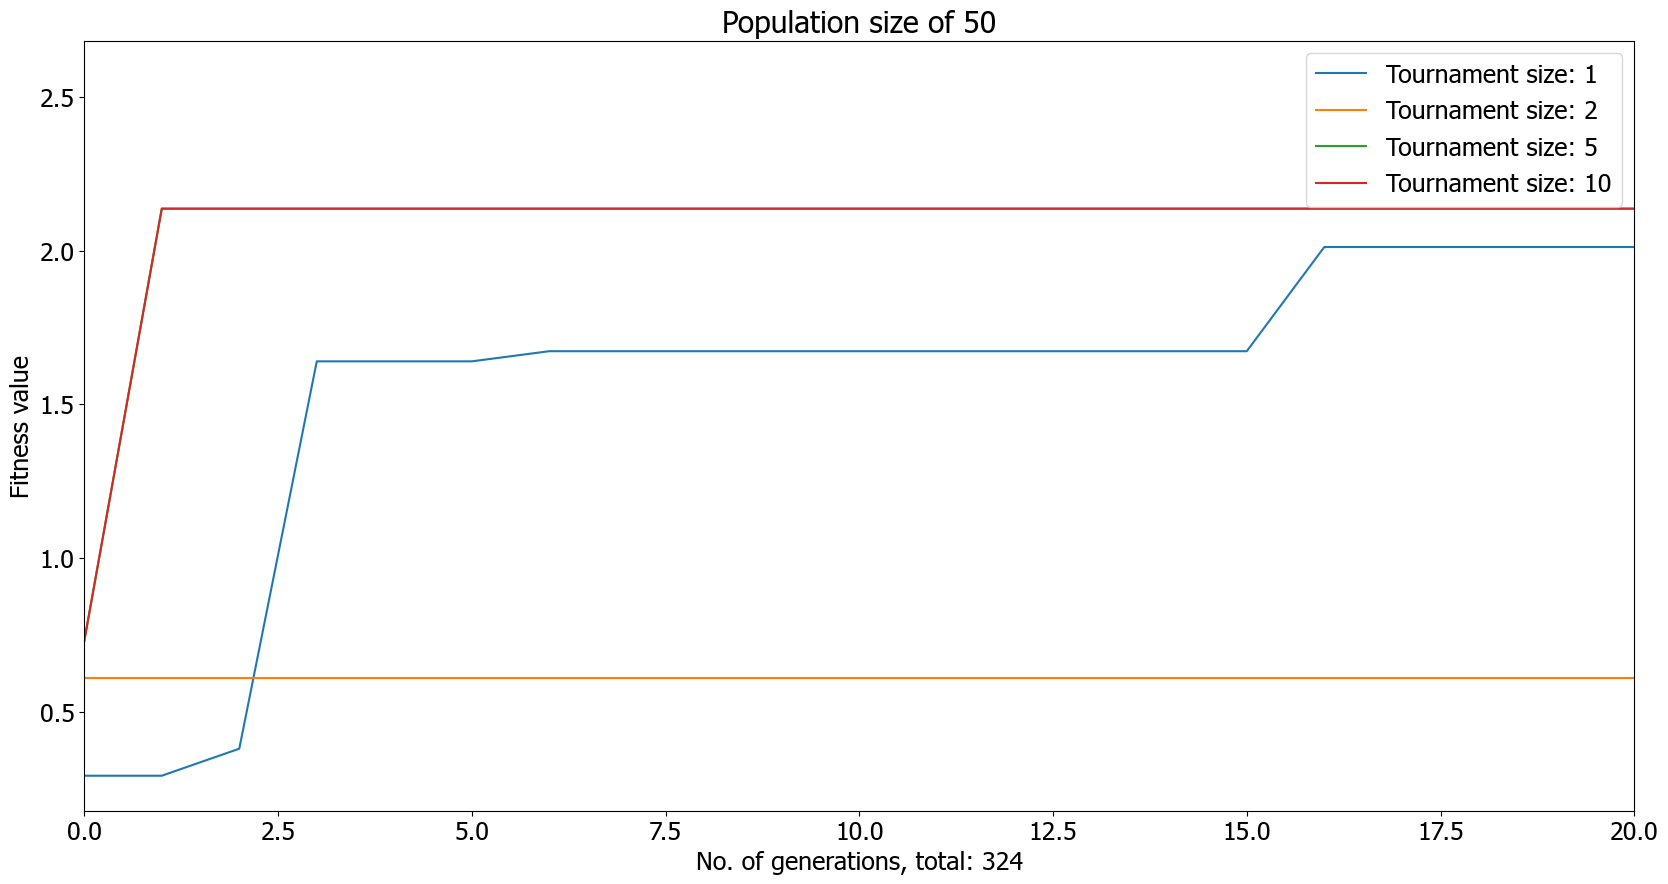

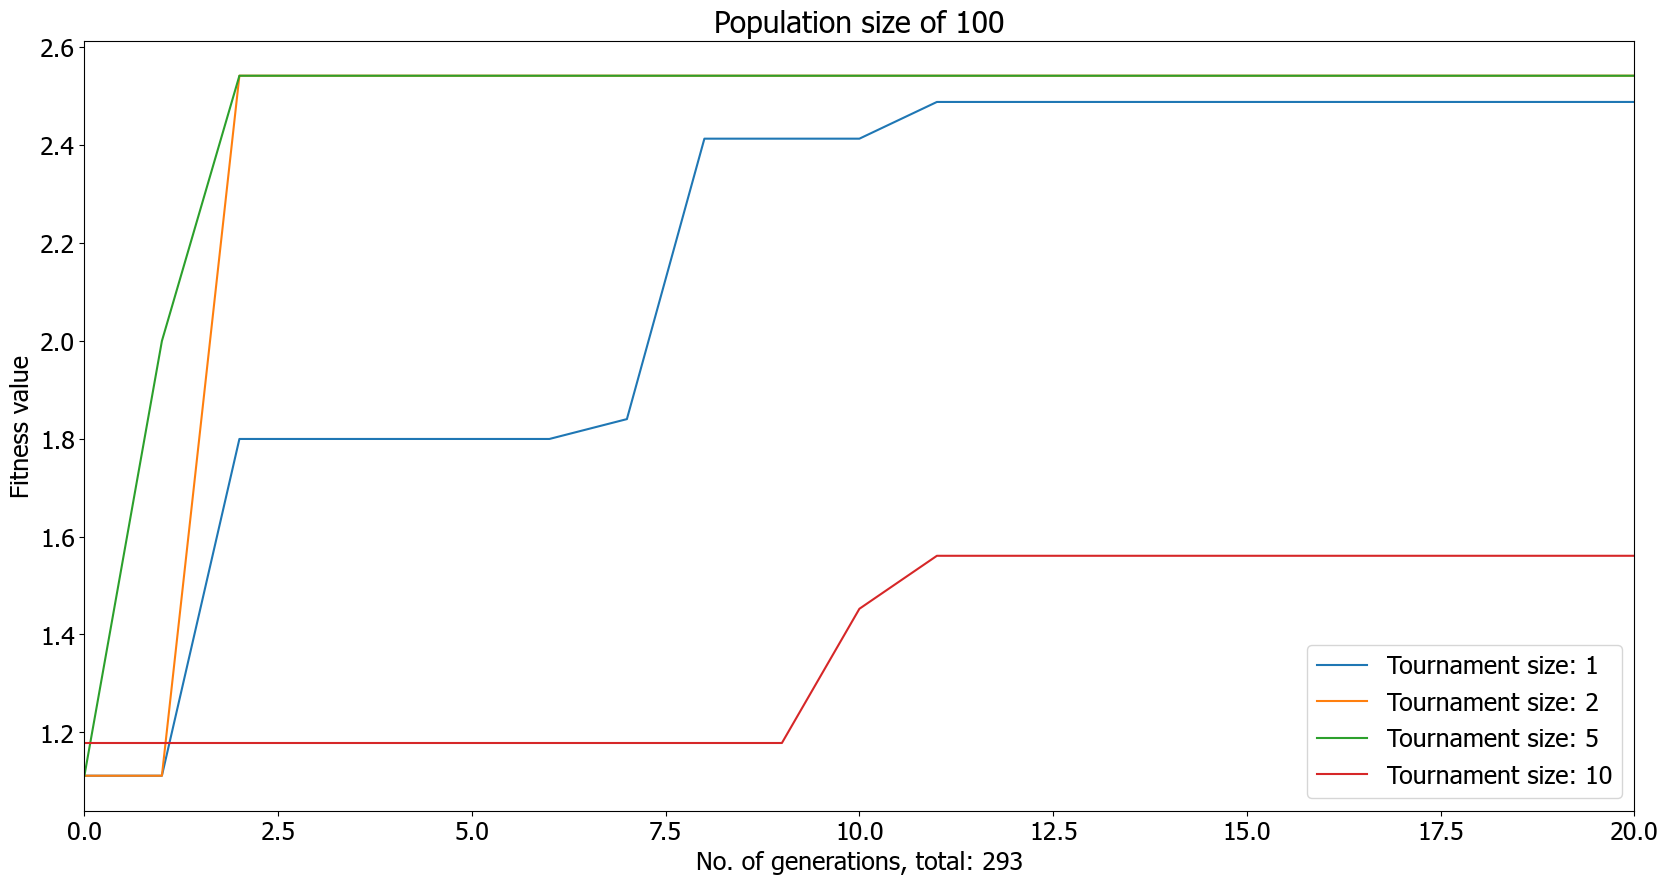

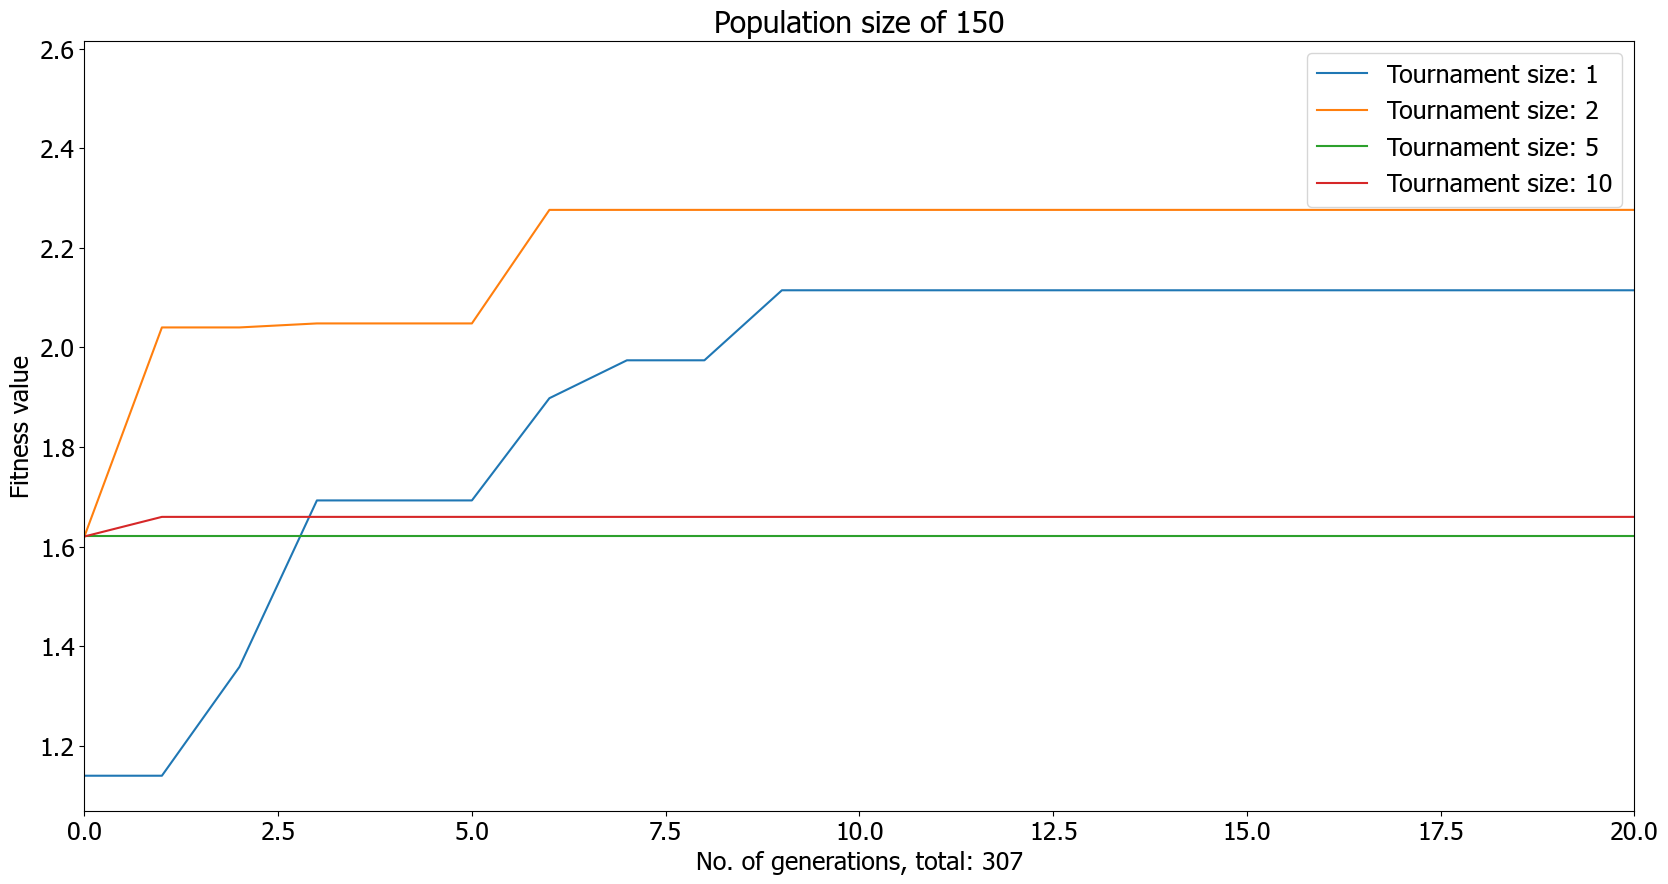

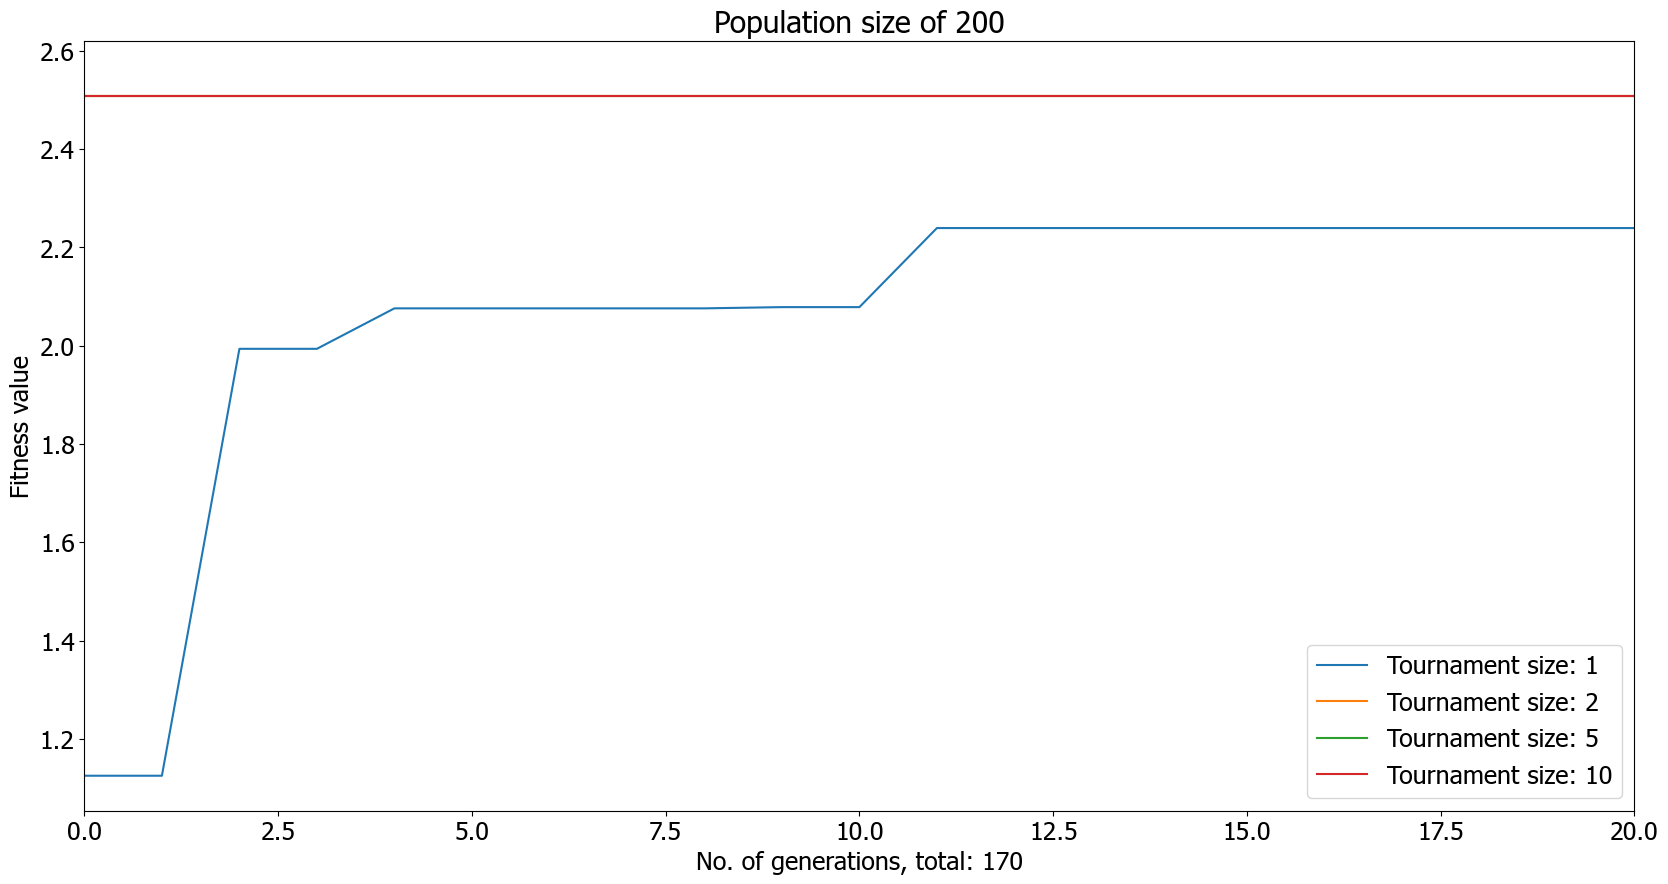

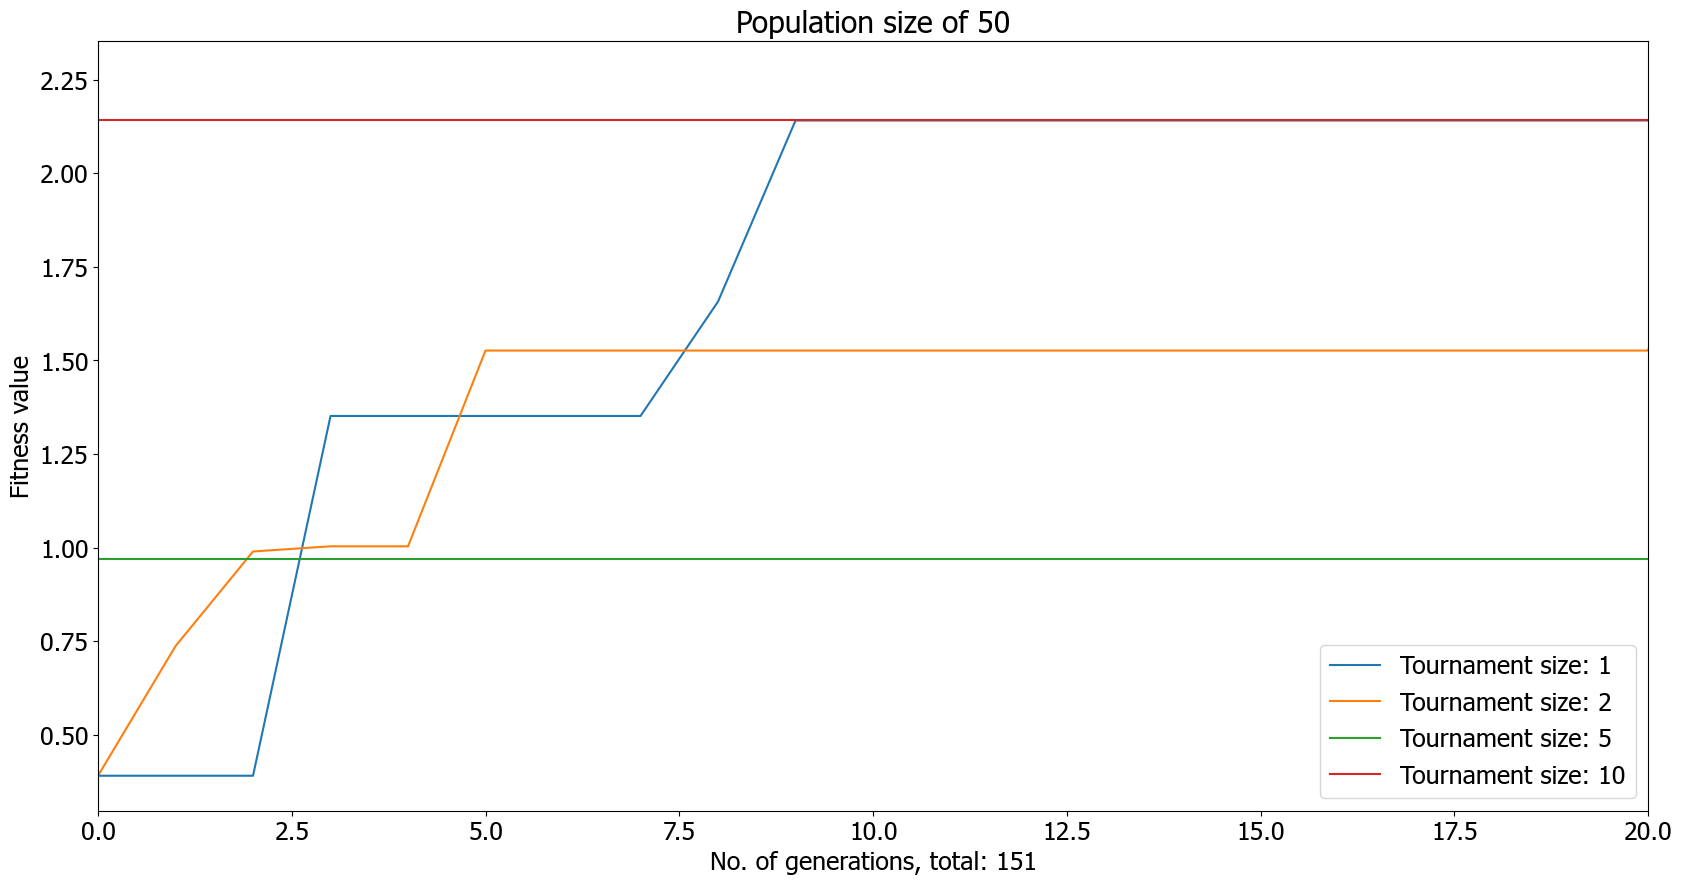

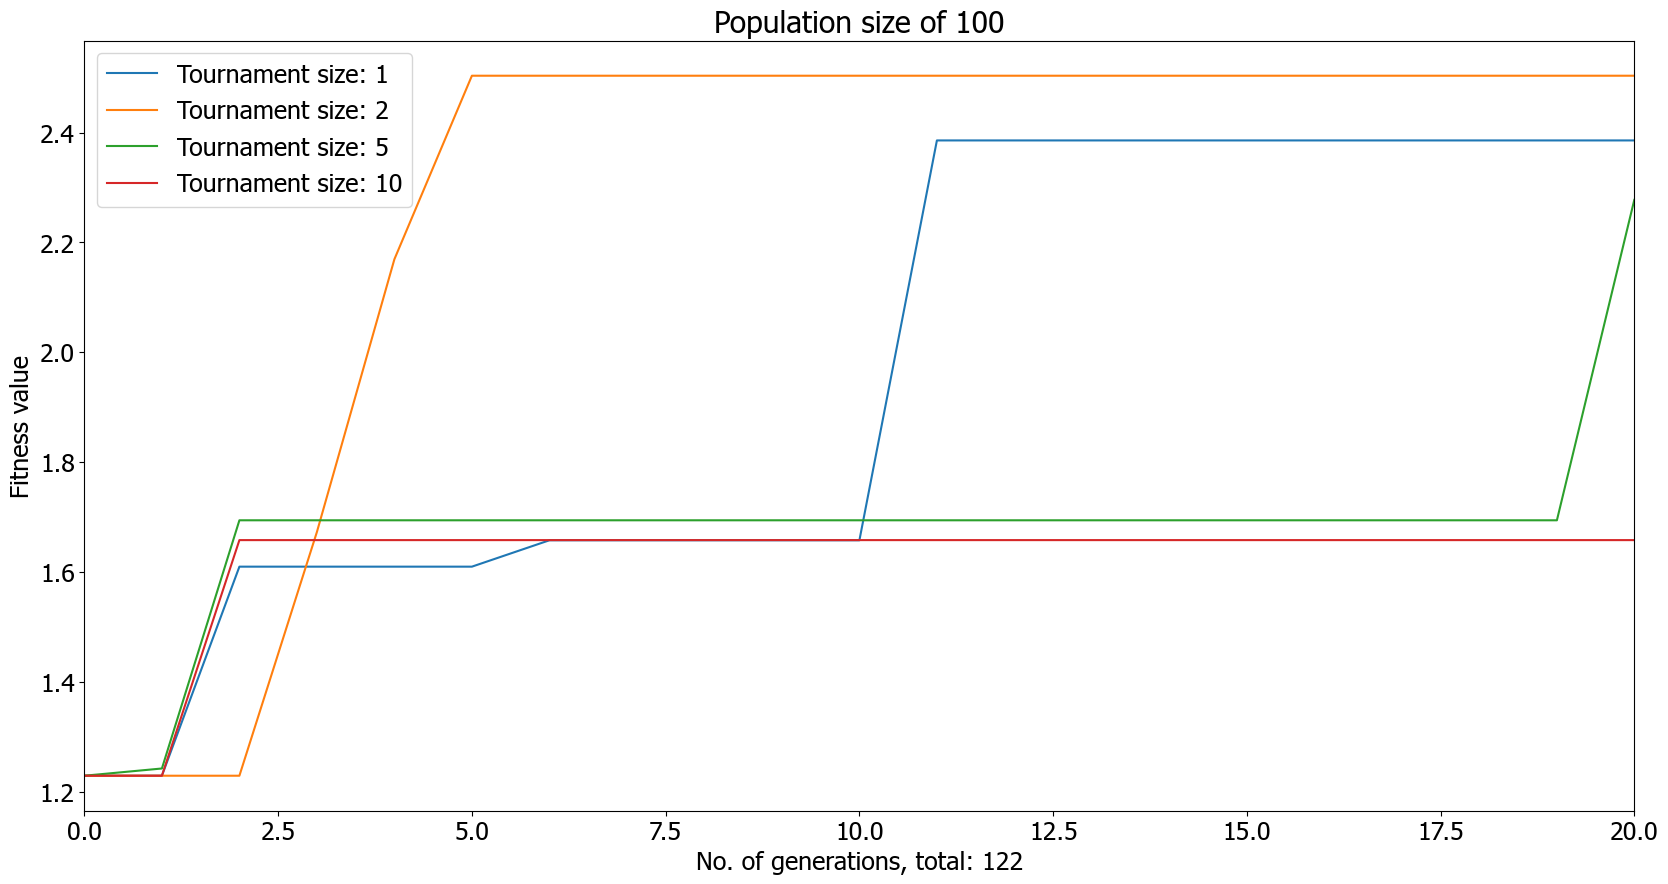

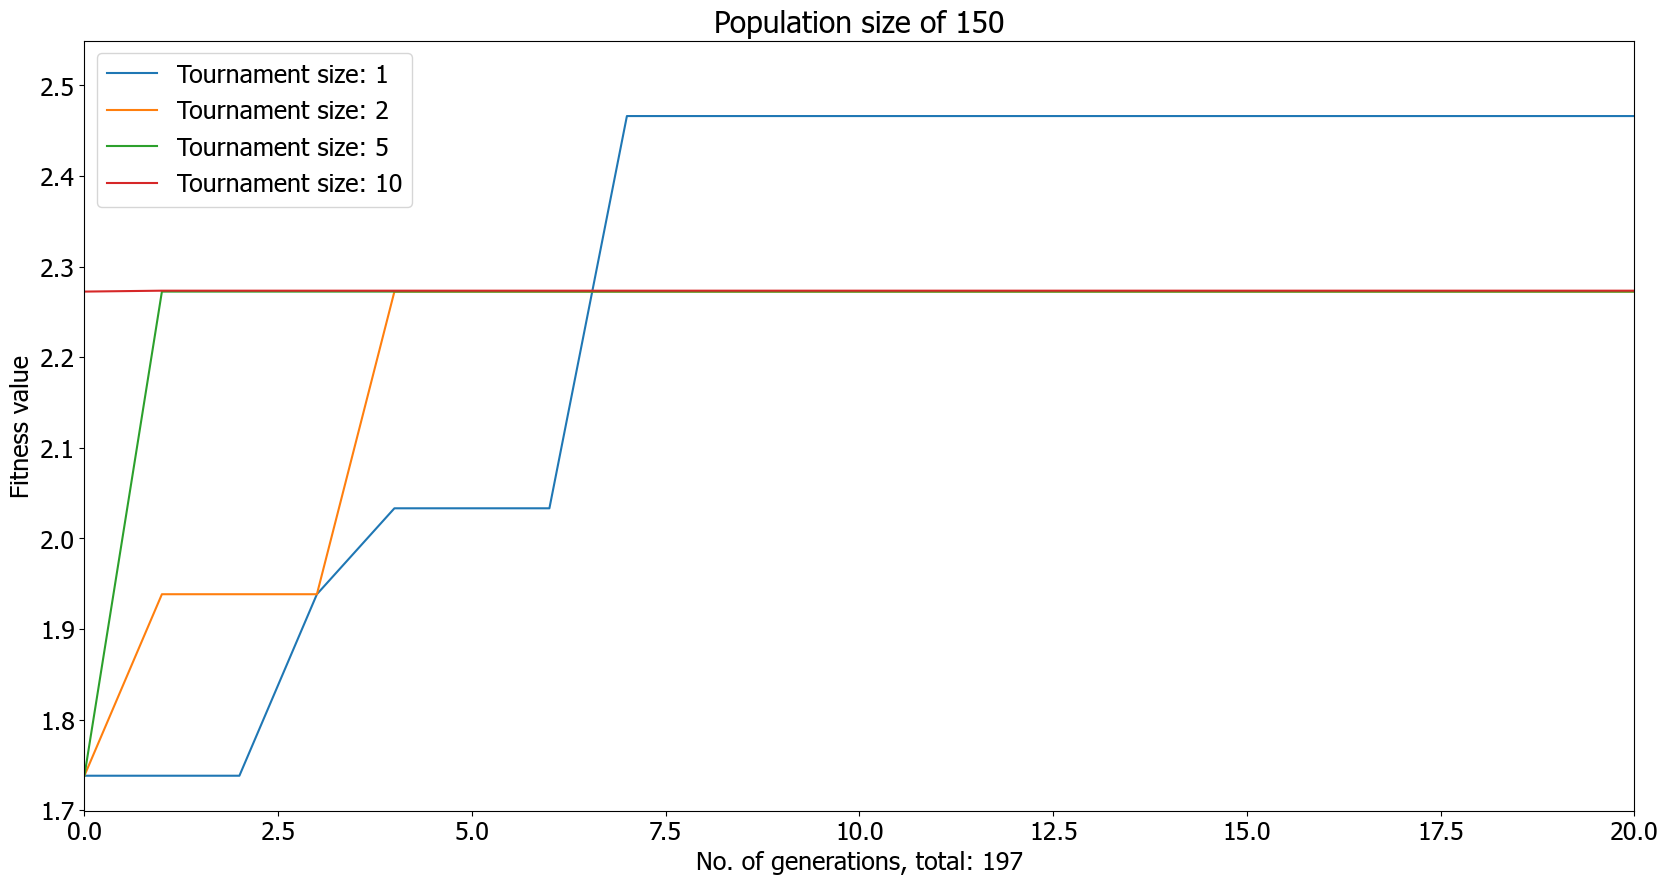

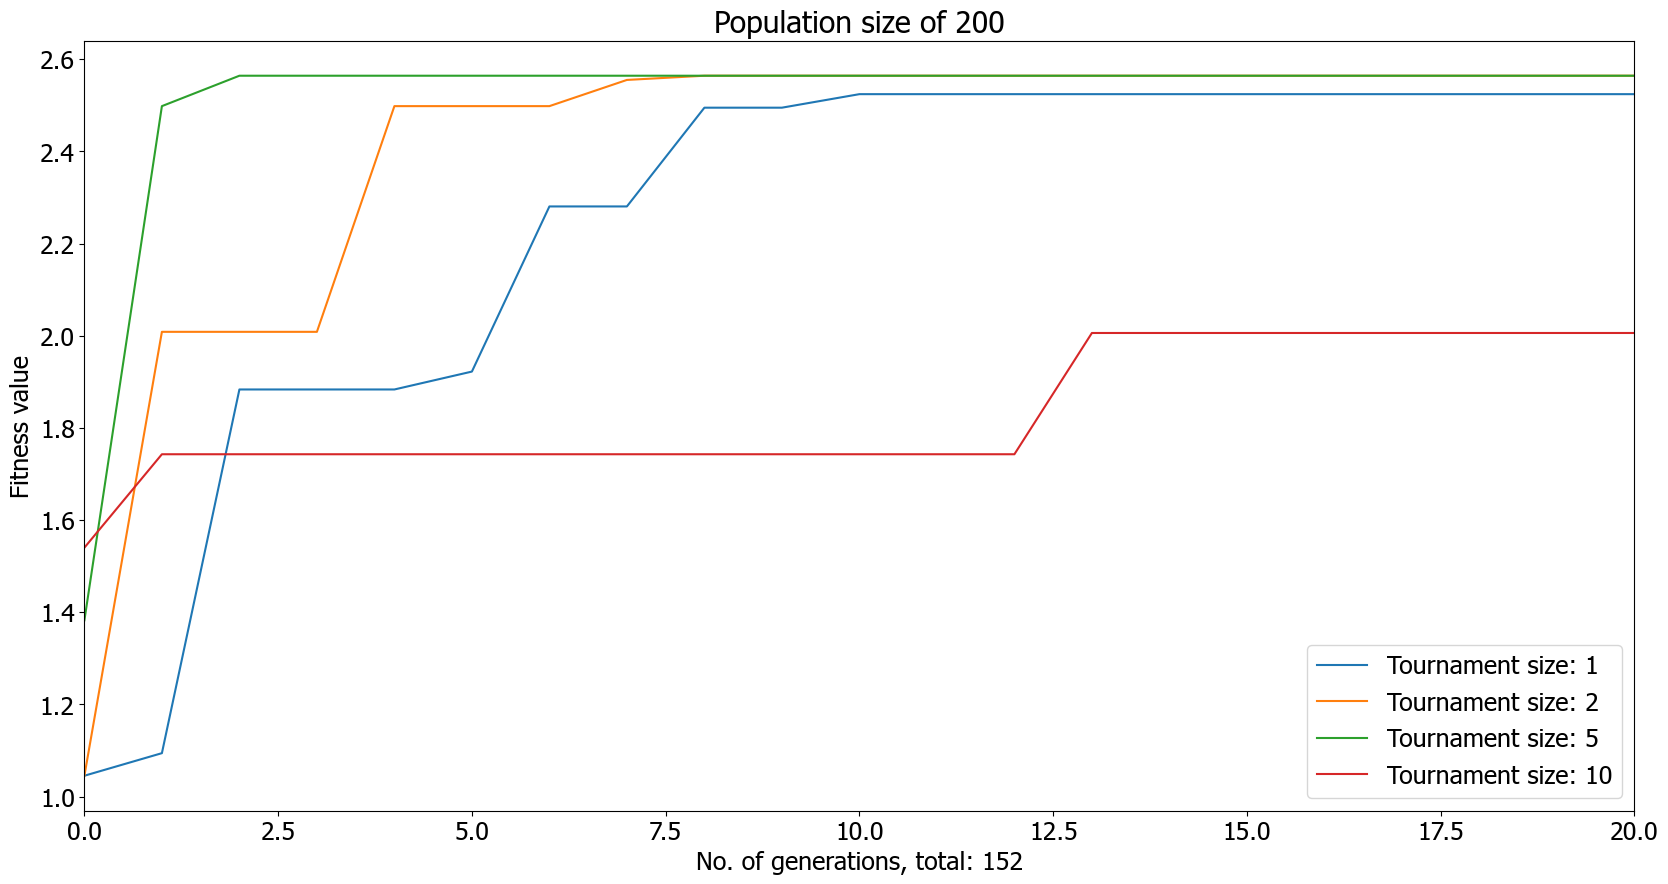

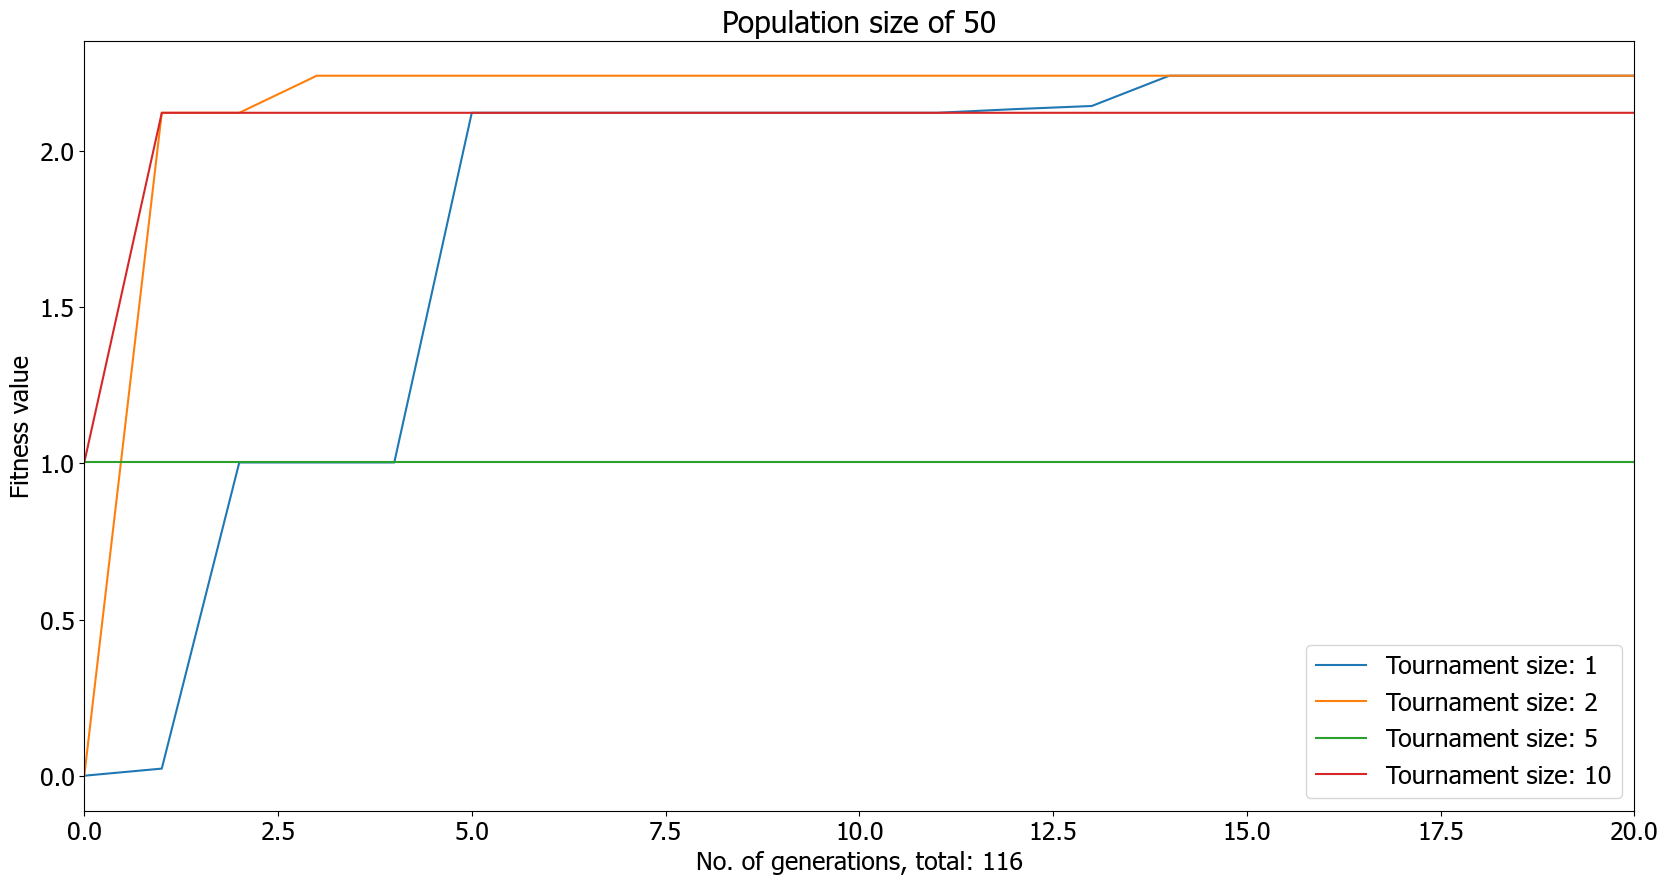

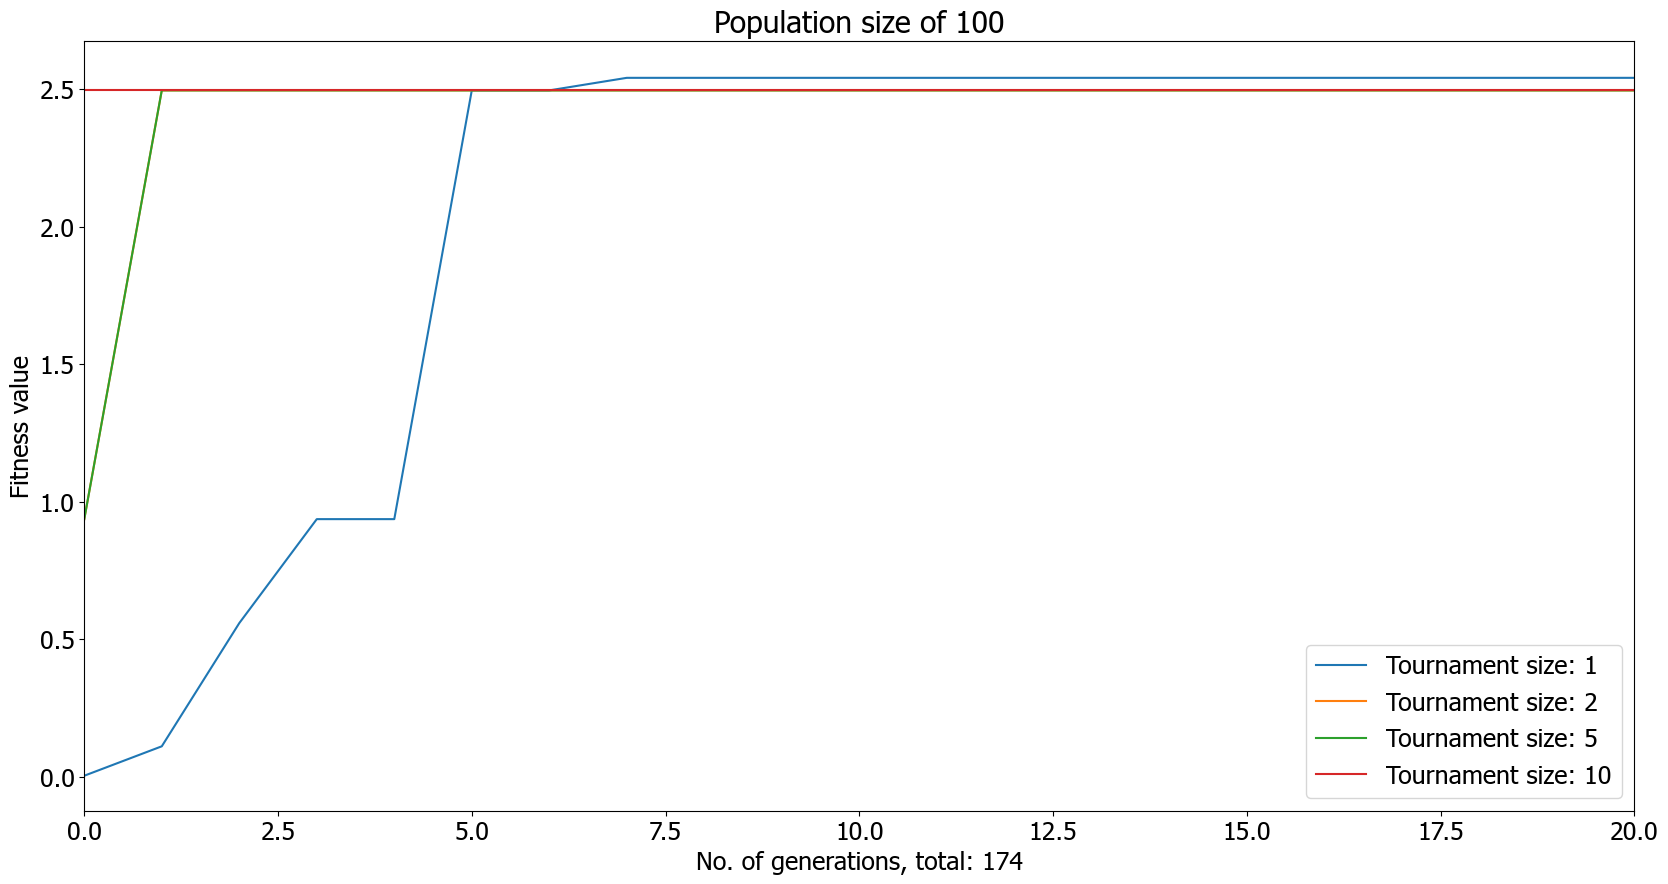

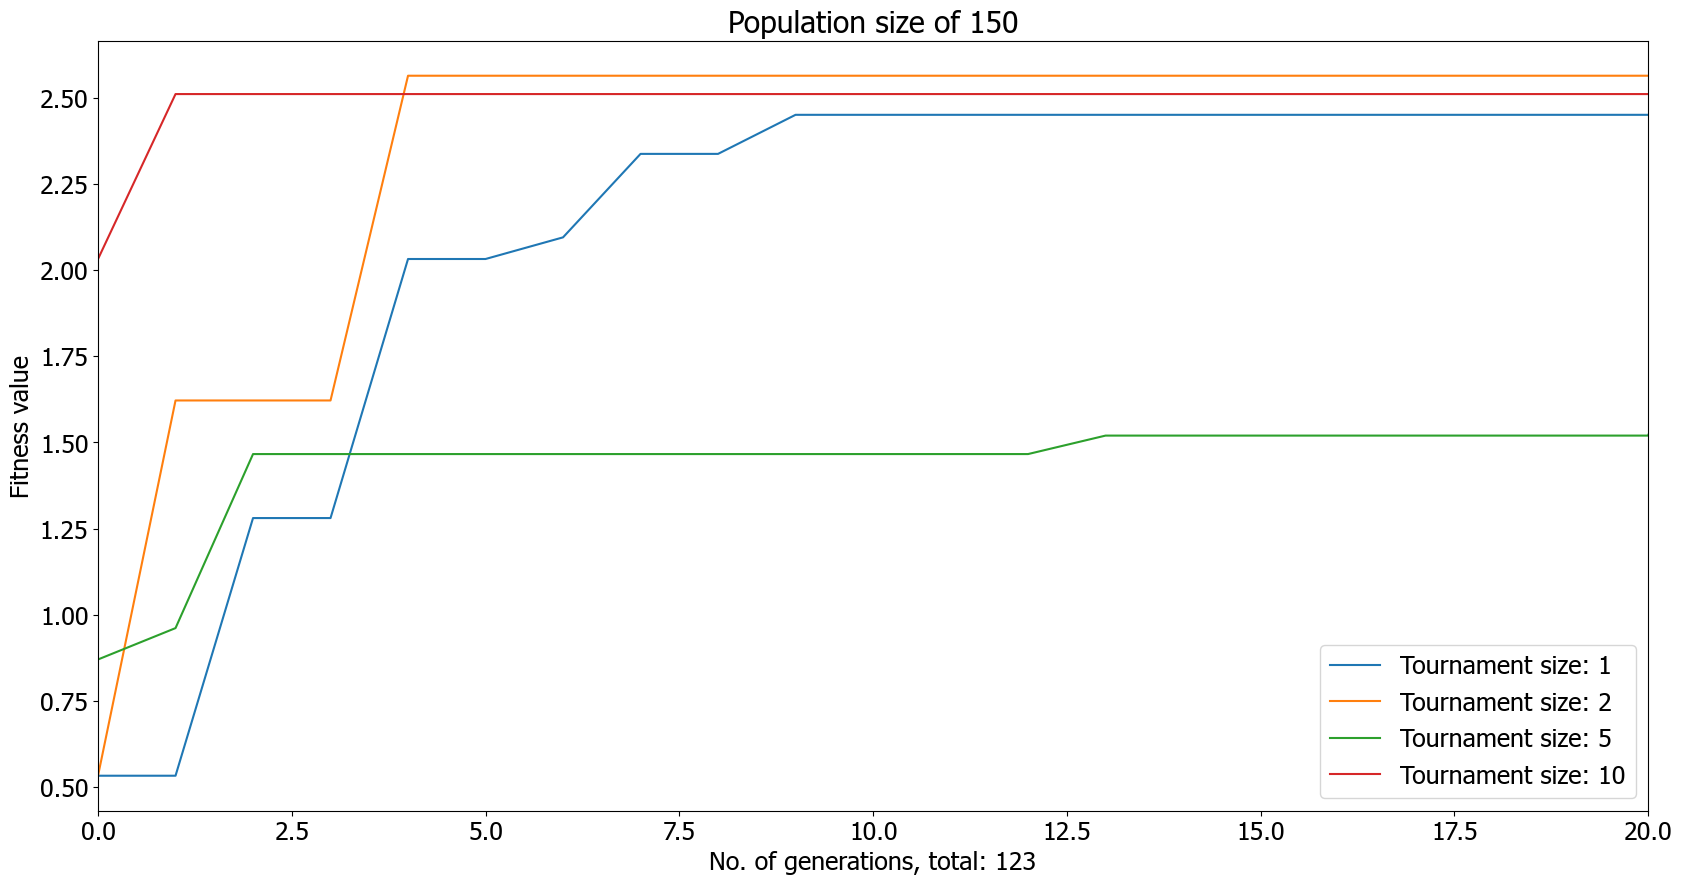

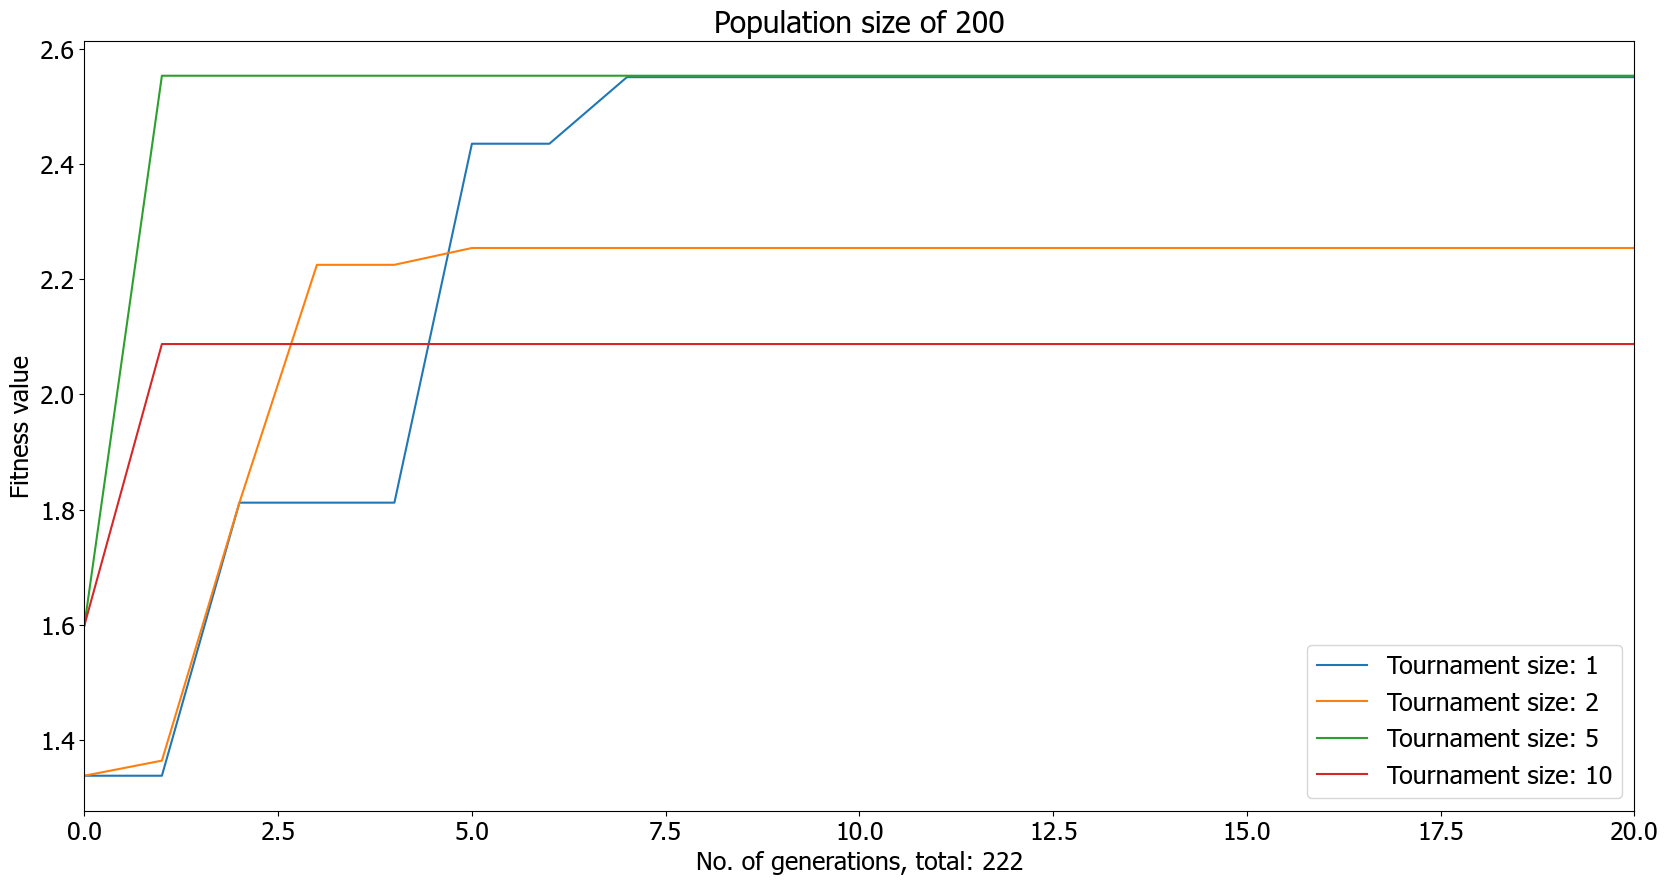

In [19]:
for dim in range(2, 6):
    popsize_influence(dim)

In [20]:
def tournament_size_influence(dims=None):
    plt.rcParams["figure.figsize"] = (20,10)
    plt.rcParams.update({'font.size': 18, 'font.family': 'Tahoma'})

    for tournament_size in [1, 2, 5, 10]:
        results = {}
        iters = []
        for popsize in range(50, 250, 50):
            if not dims:
                population = generate_population(popsize)
            else:
                population = generate_population(popsize, dims)
            if not dims:
                res = evolve(population, popsize, tournament_size, change_dim=True)
            else:
                res = evolve(population, popsize, tournament_size)   
            results[str(popsize)] = res
            iters.append(len(res))

        for popsize, res in results.items():
            plt.plot(res, label=f"Population size: {popsize}")
        plt.title(f"Tournament size of {tournament_size}")
        plt.xlabel(f"No. of generations, total: {max(iters)}")
        plt.ylabel("Fitness value")
        plt.legend()
        plt.xlim(0, 20)
        plt.show()

##### Note: (x-axis is limited to be seen better)

### Population of mixed dimensions with change of dimensions in mutation

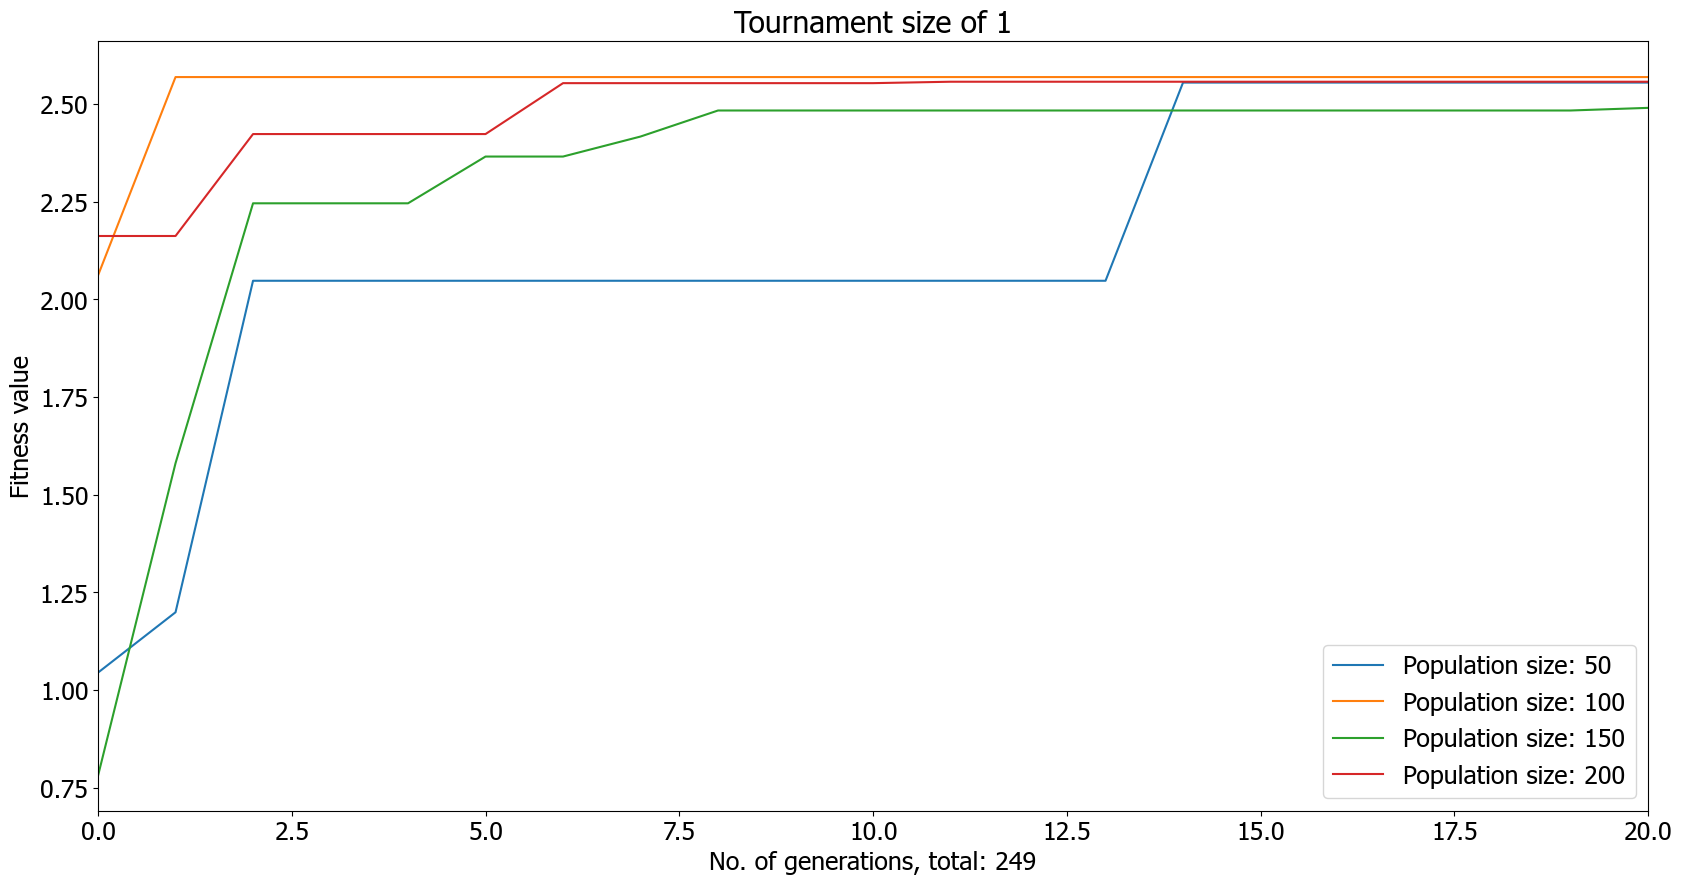

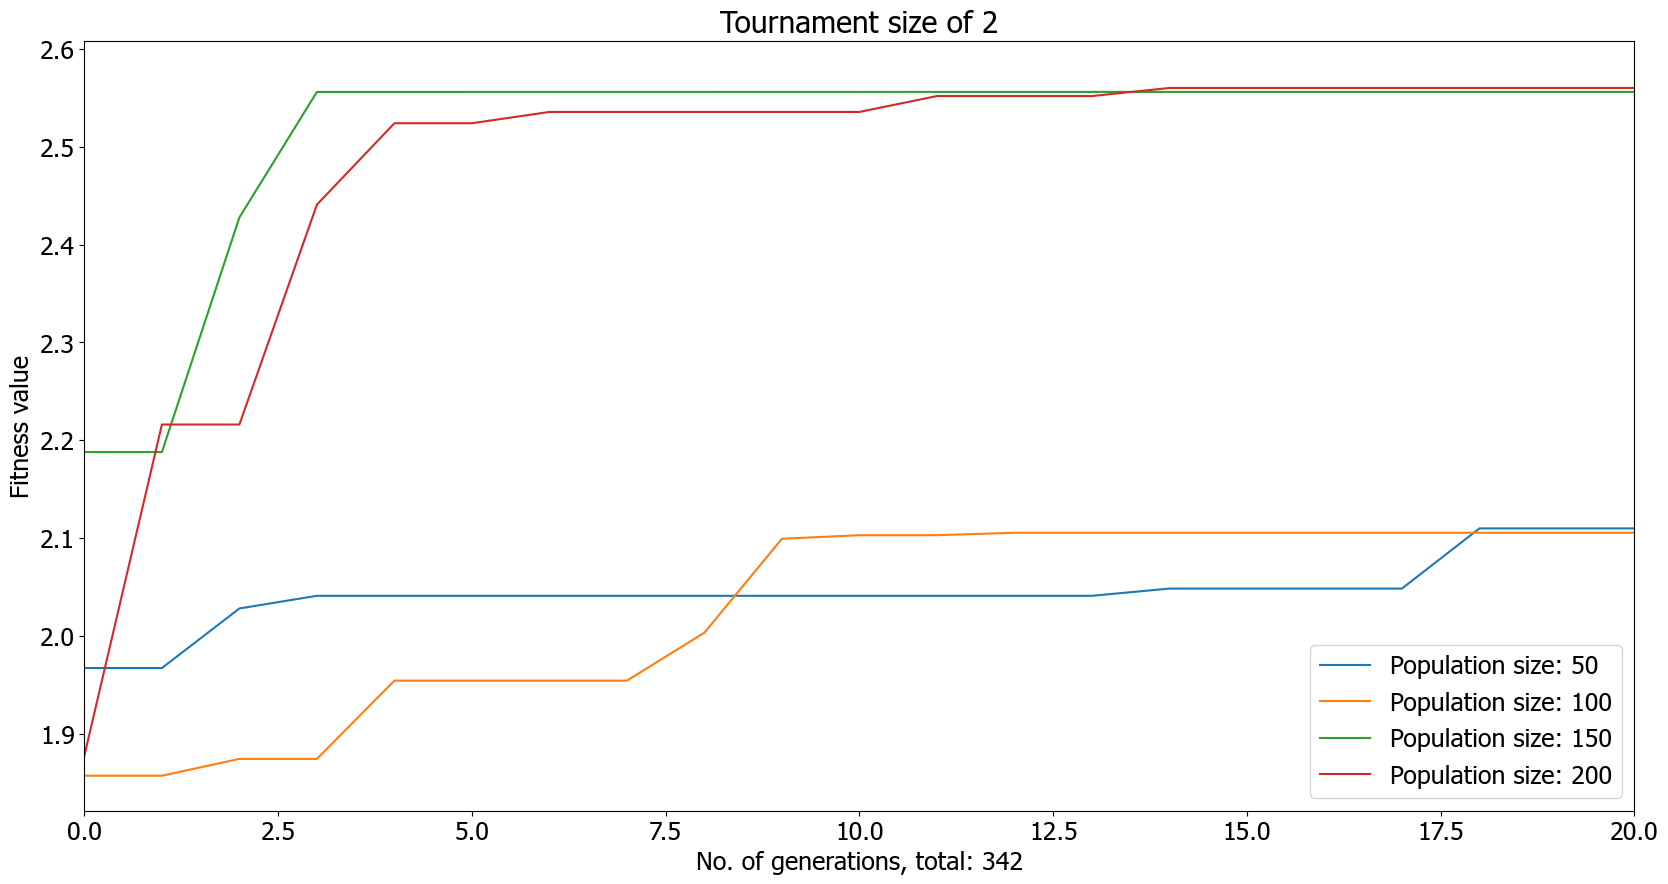

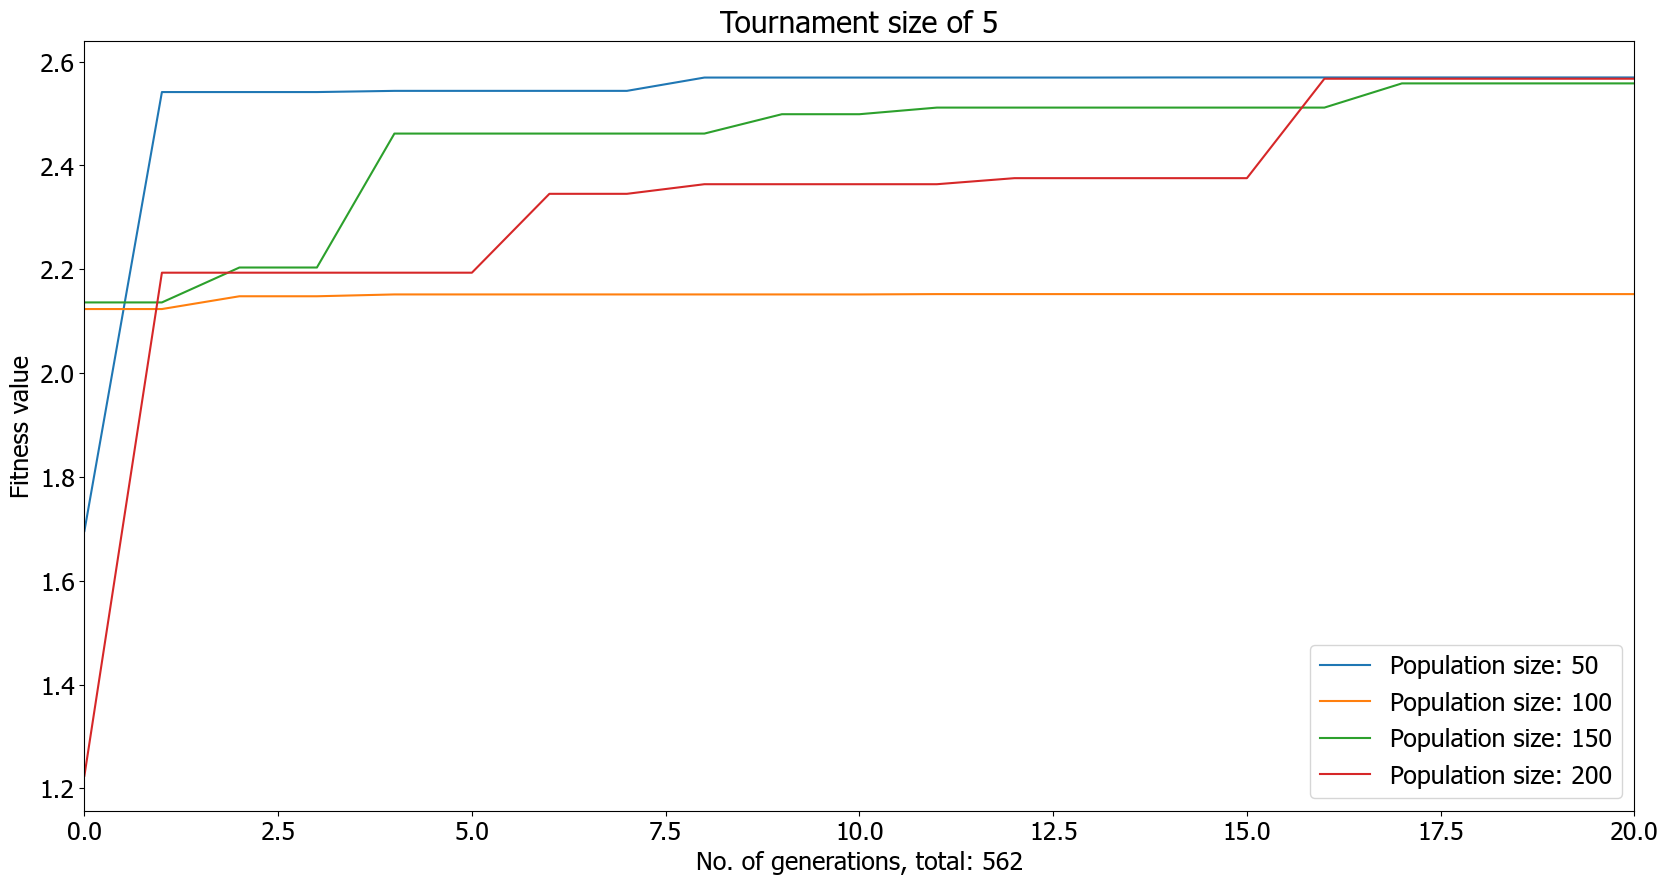

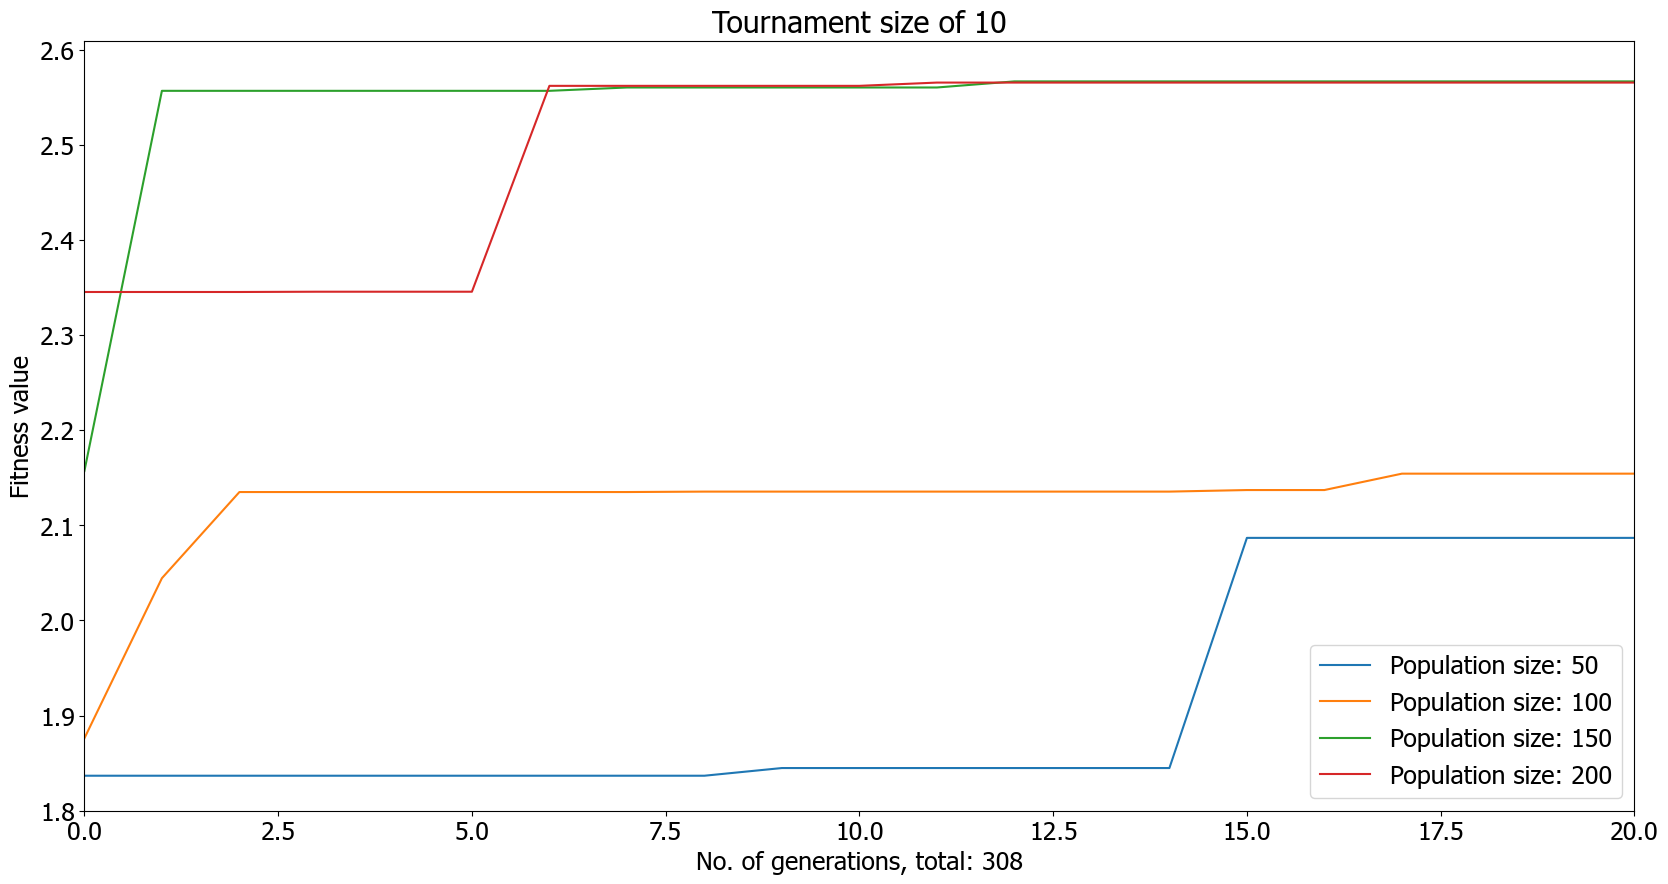

In [21]:
tournament_size_influence()

### Population of single dimension without change of dimensions in mutation

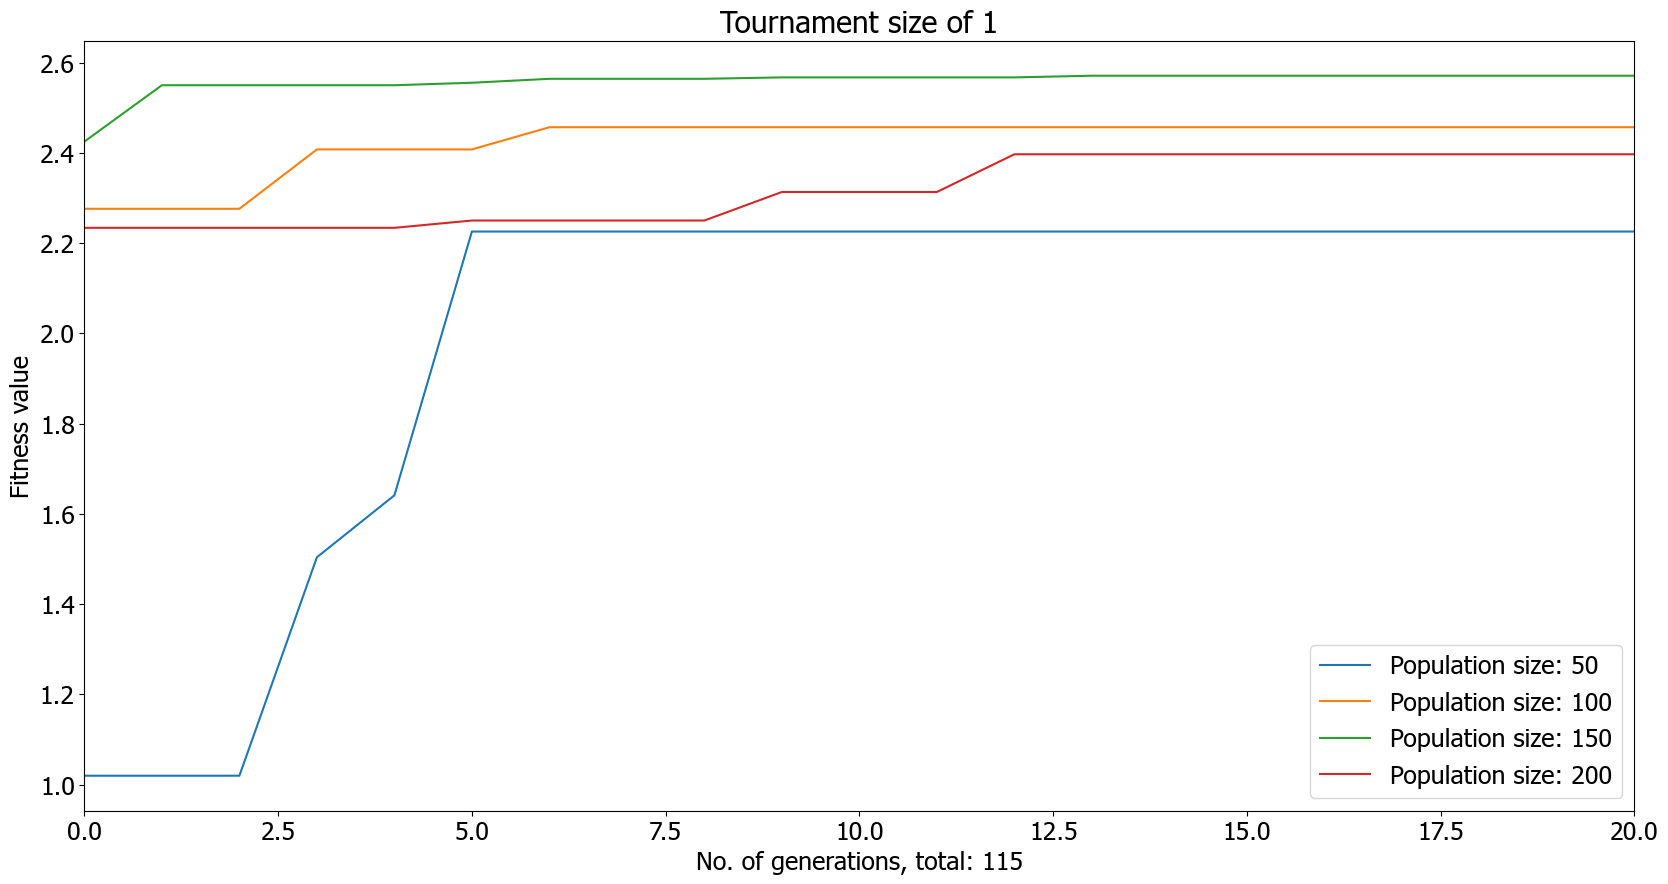

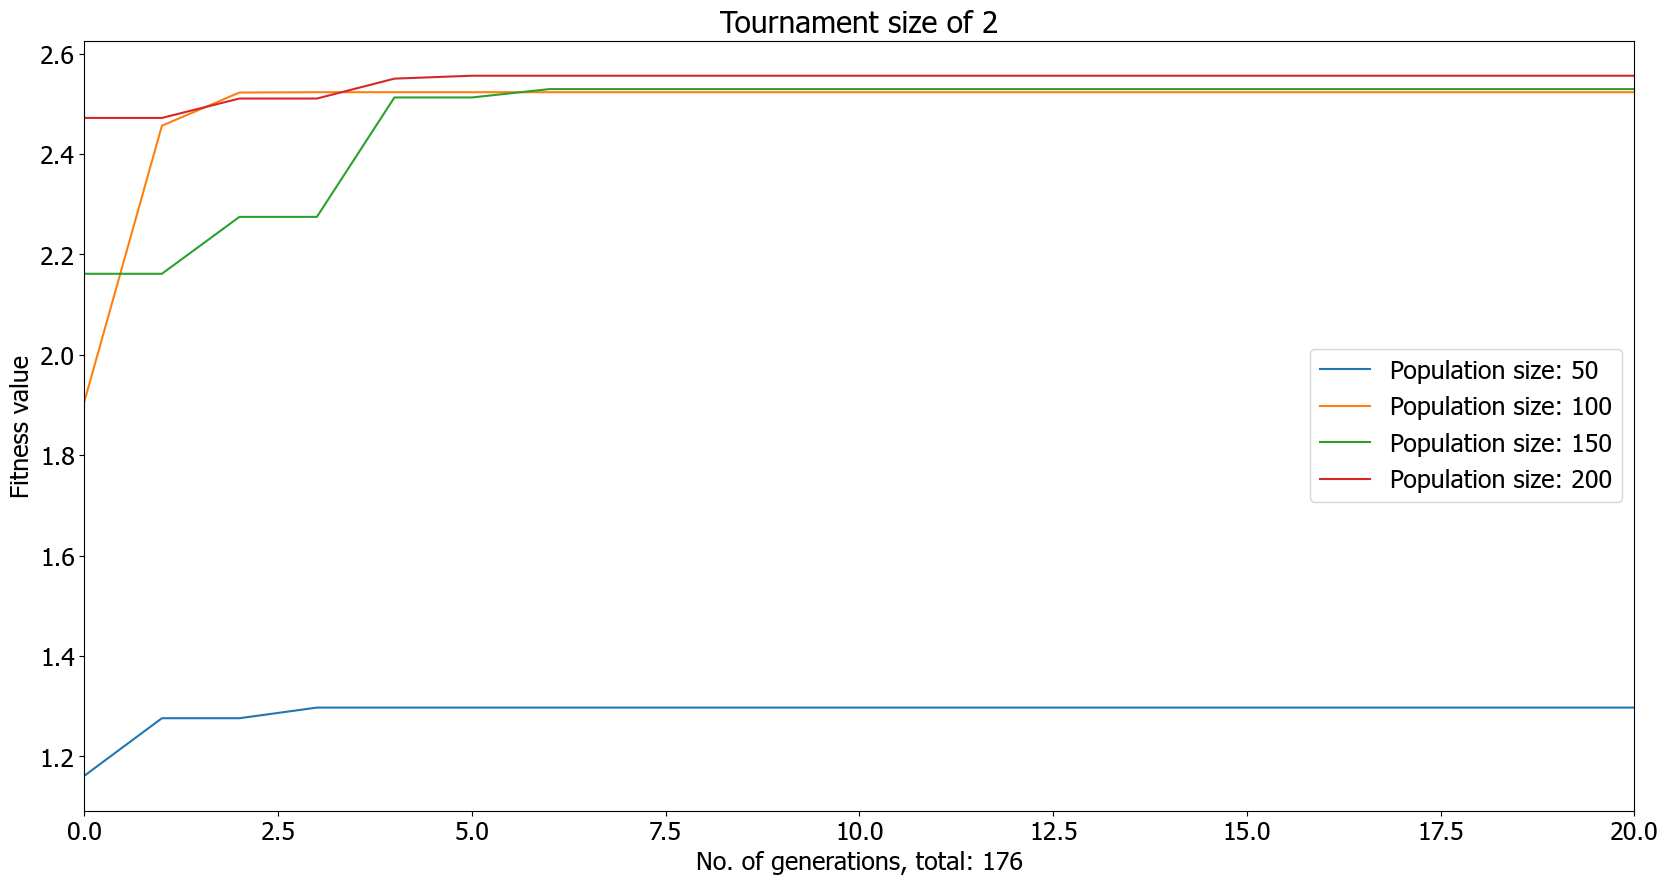

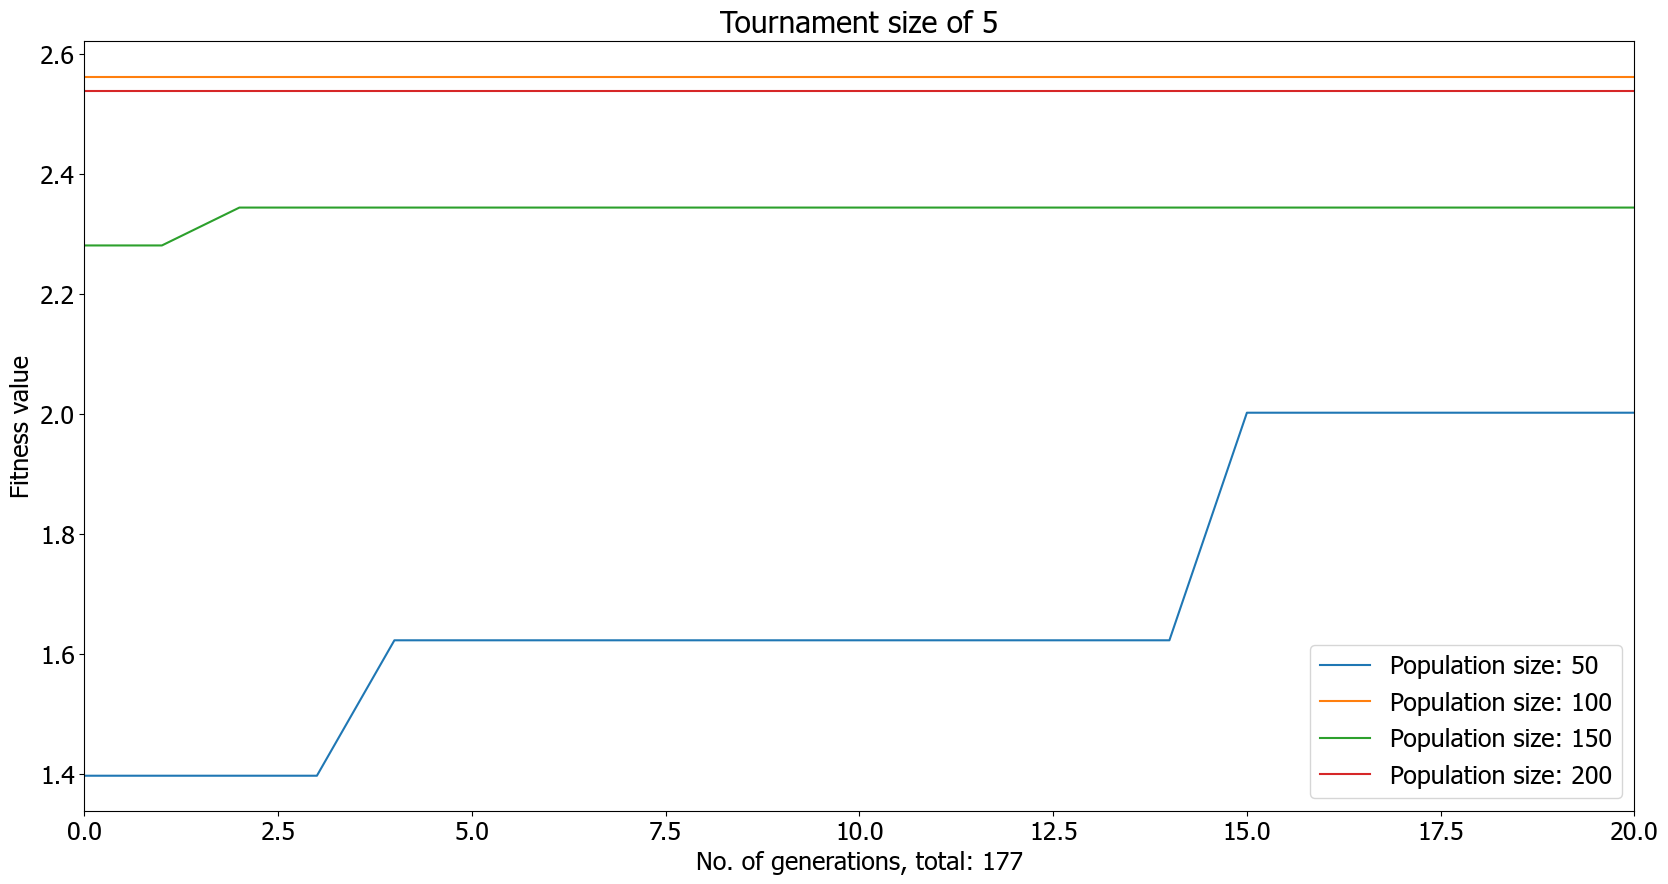

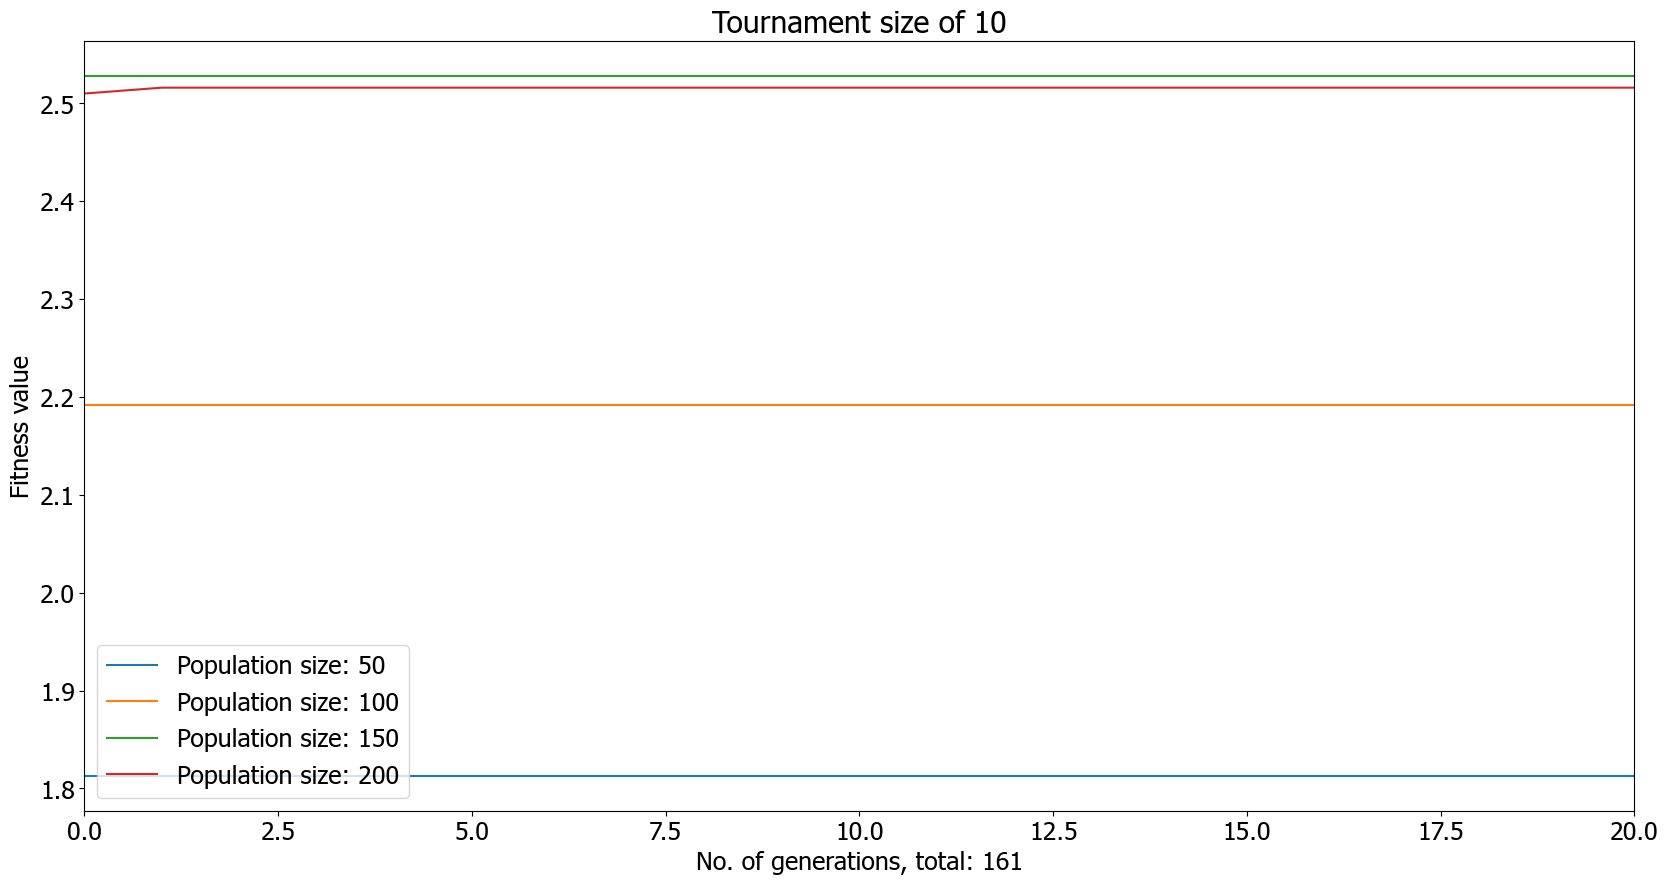

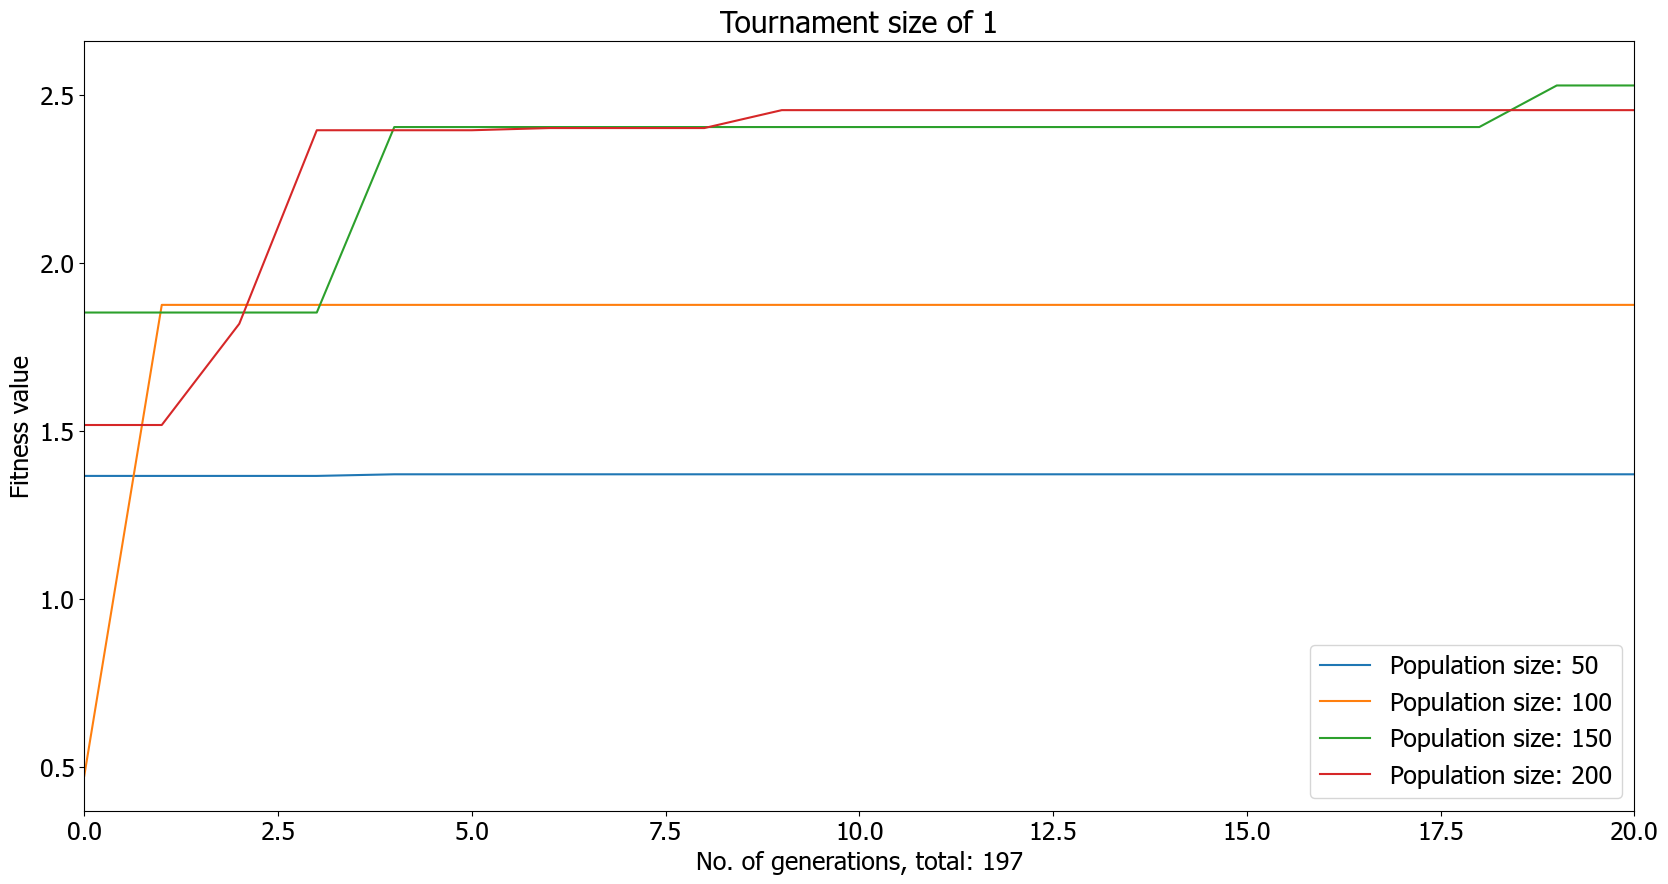

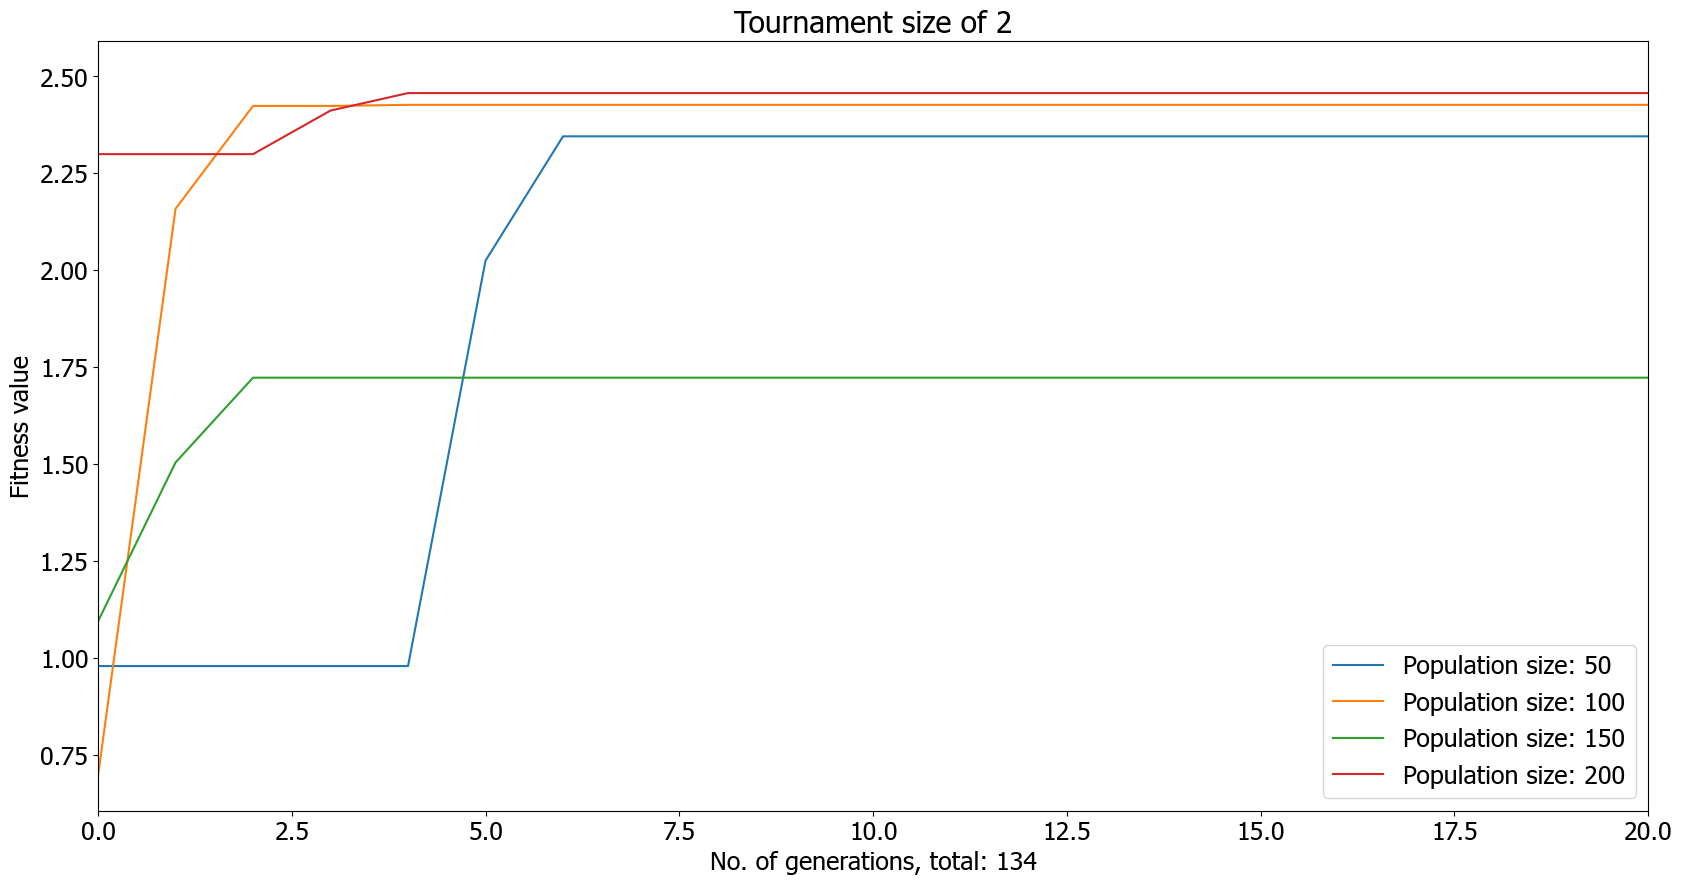

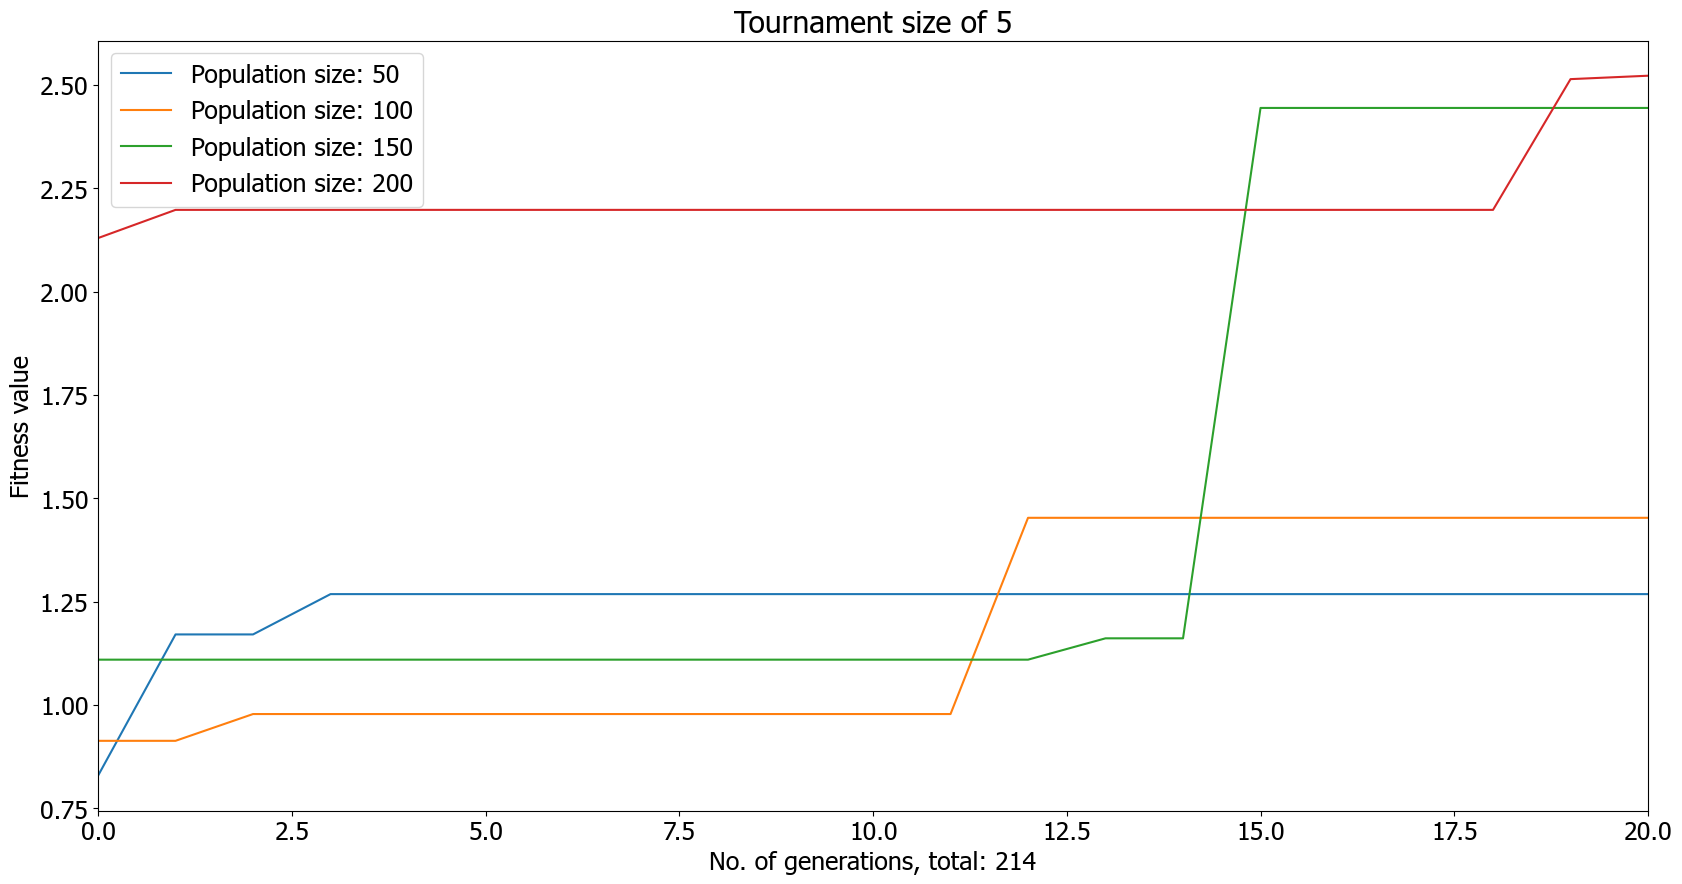

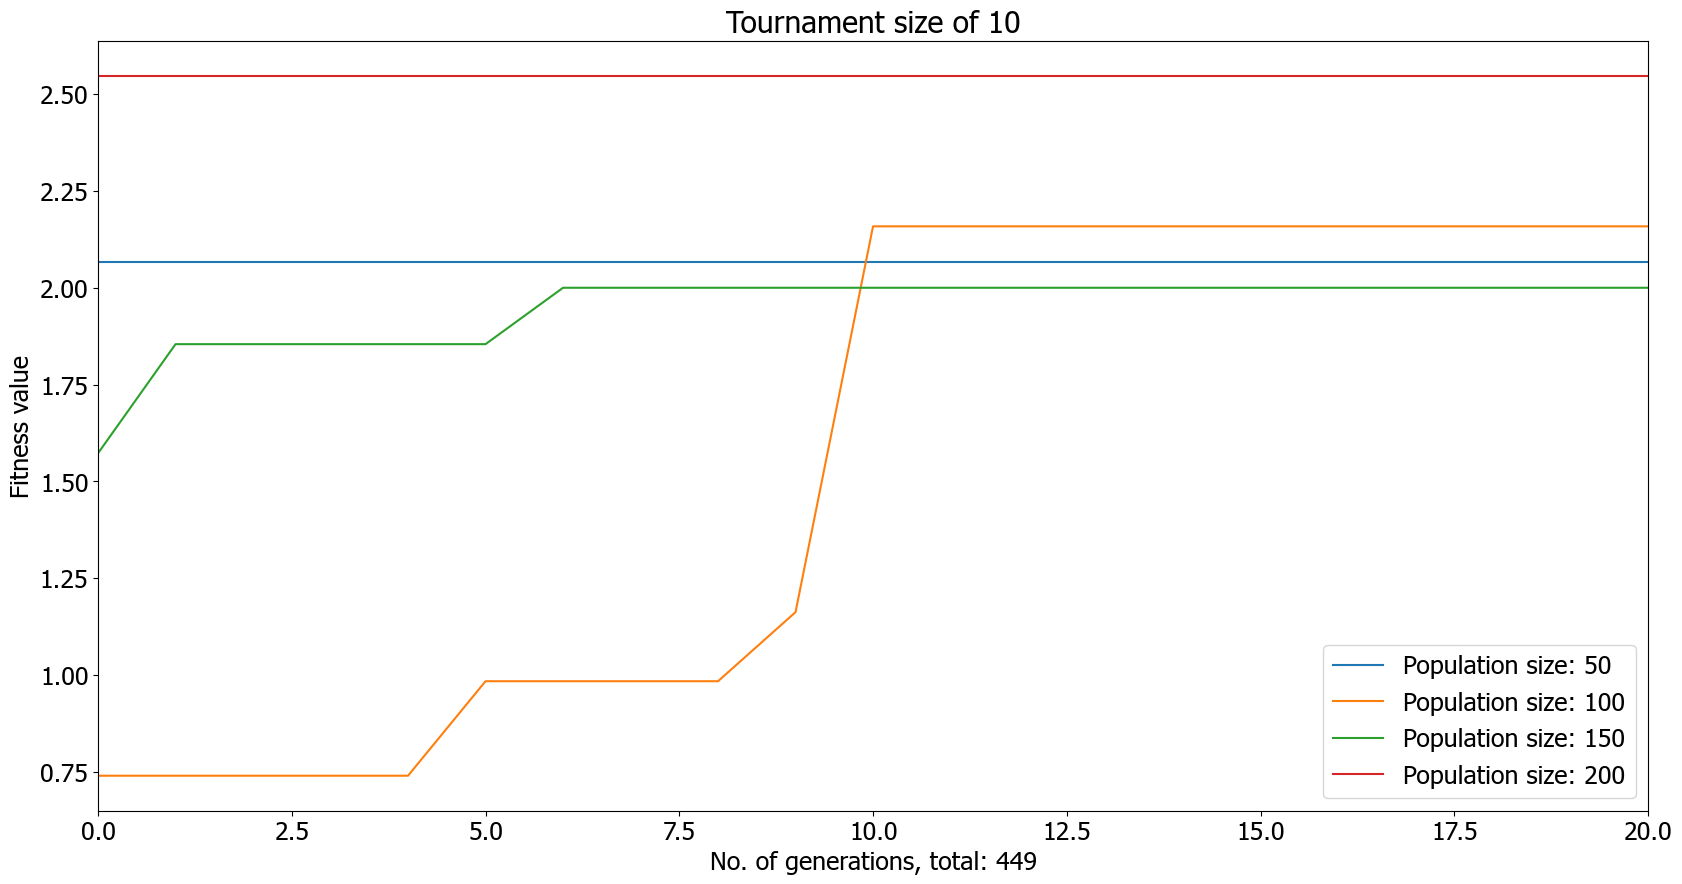

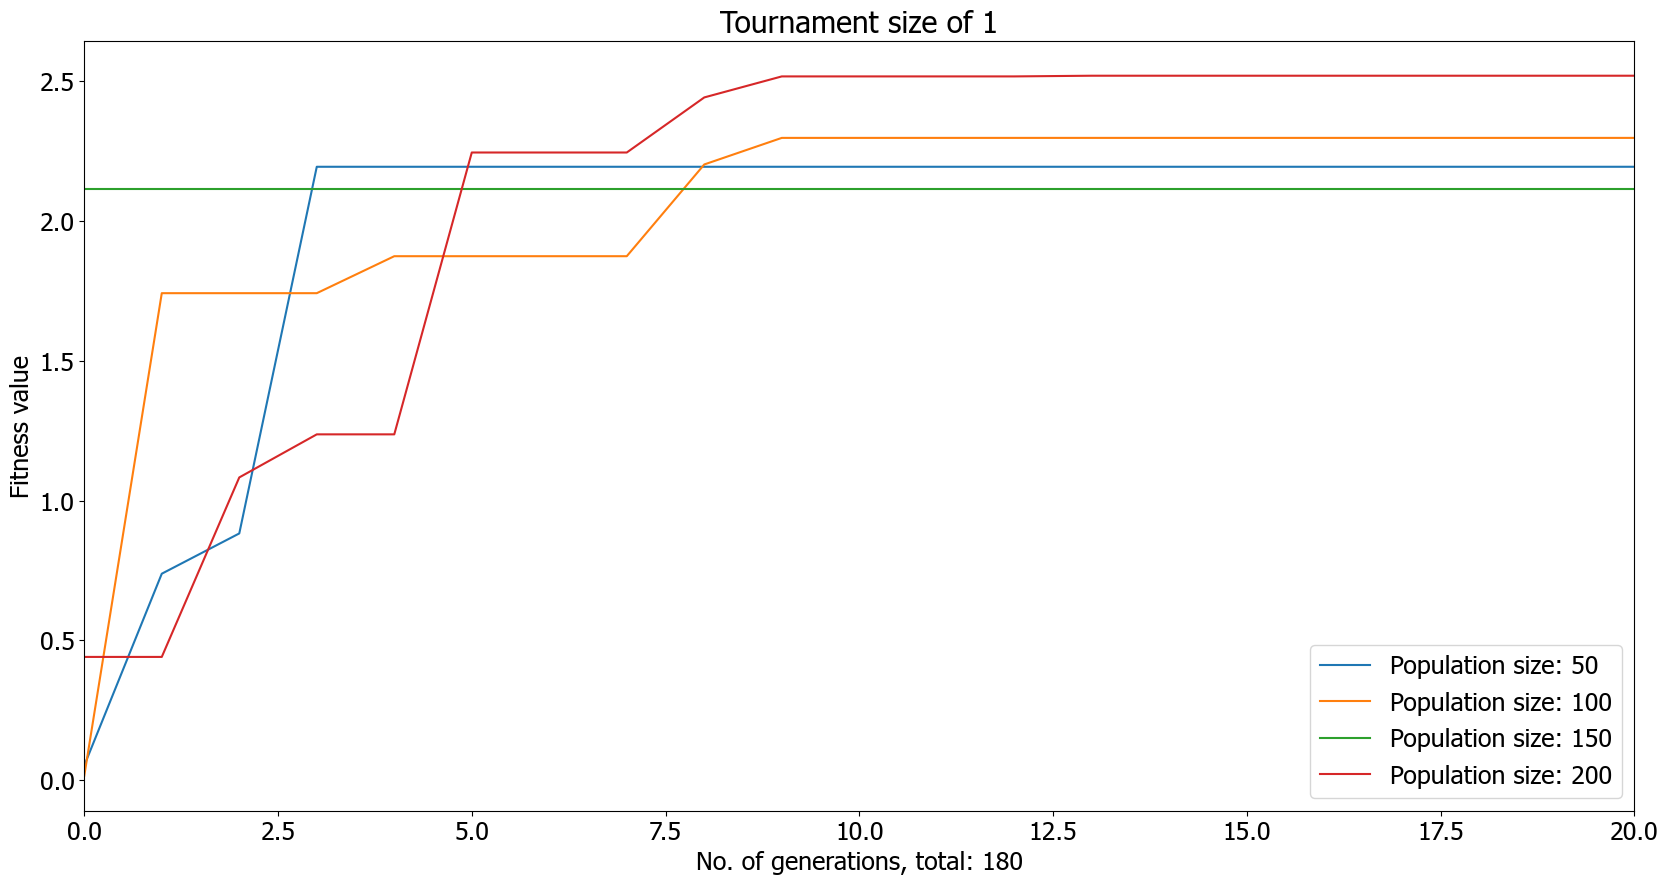

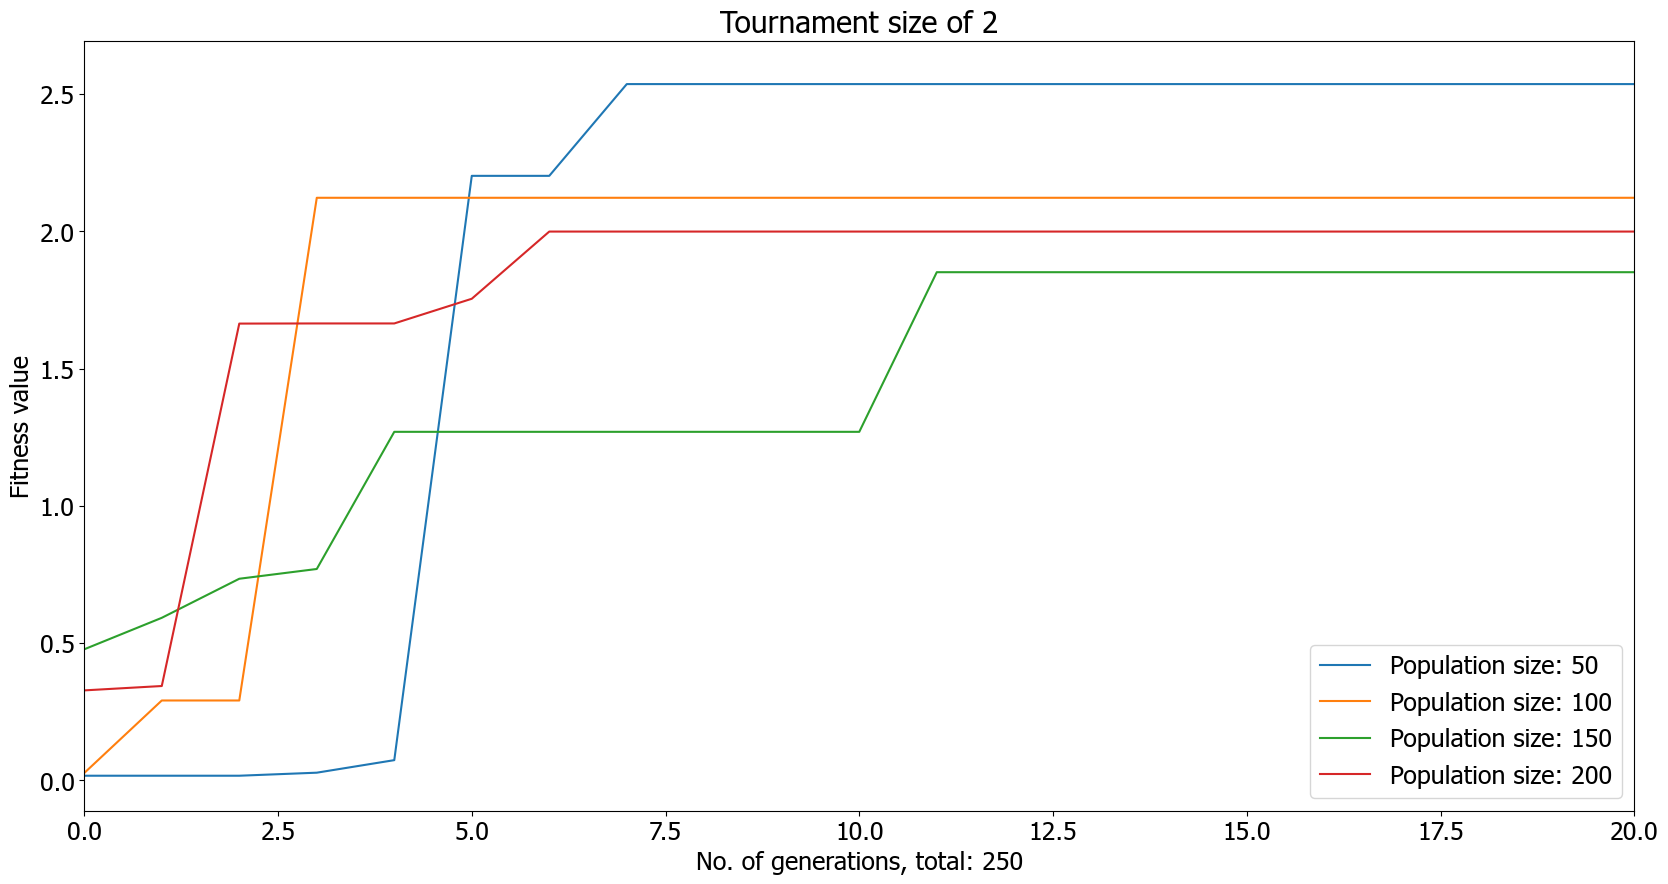

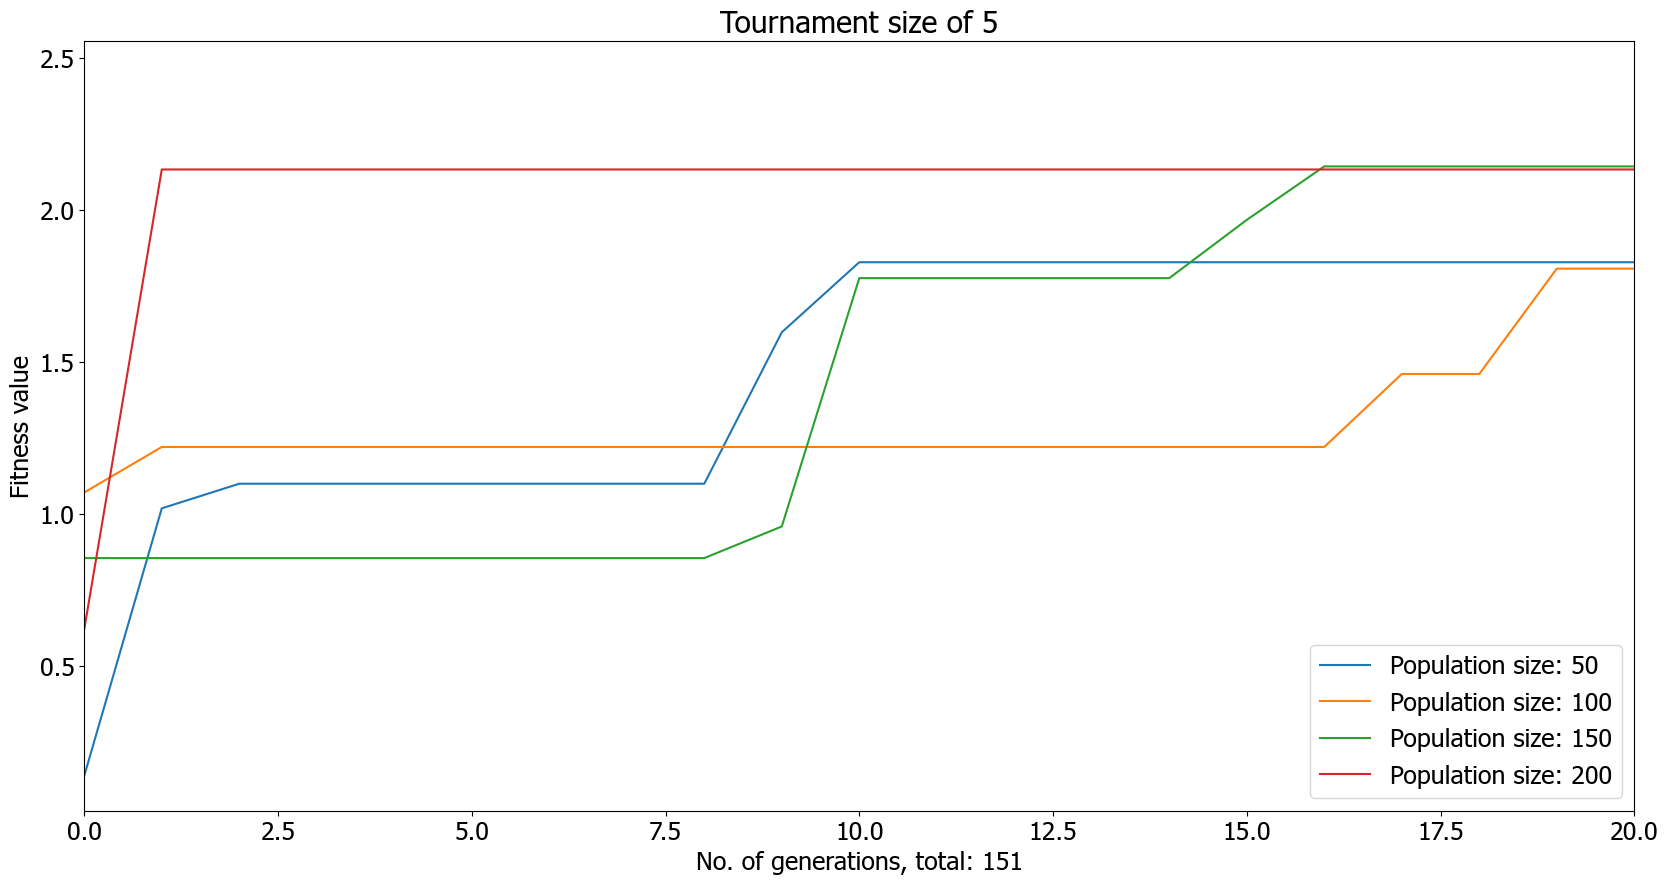

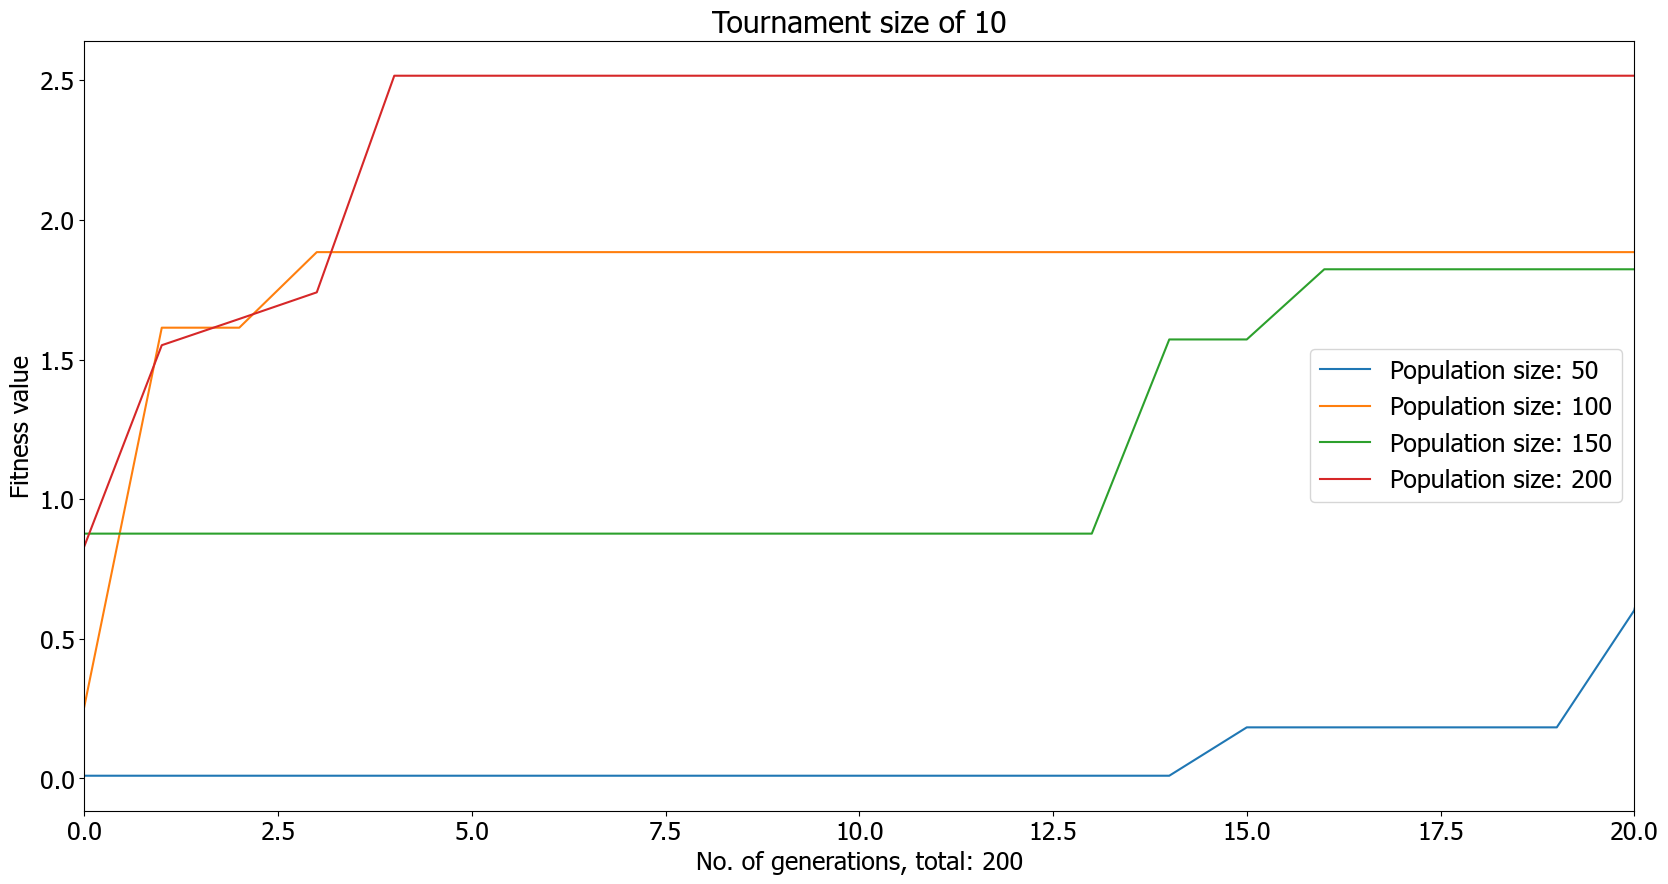

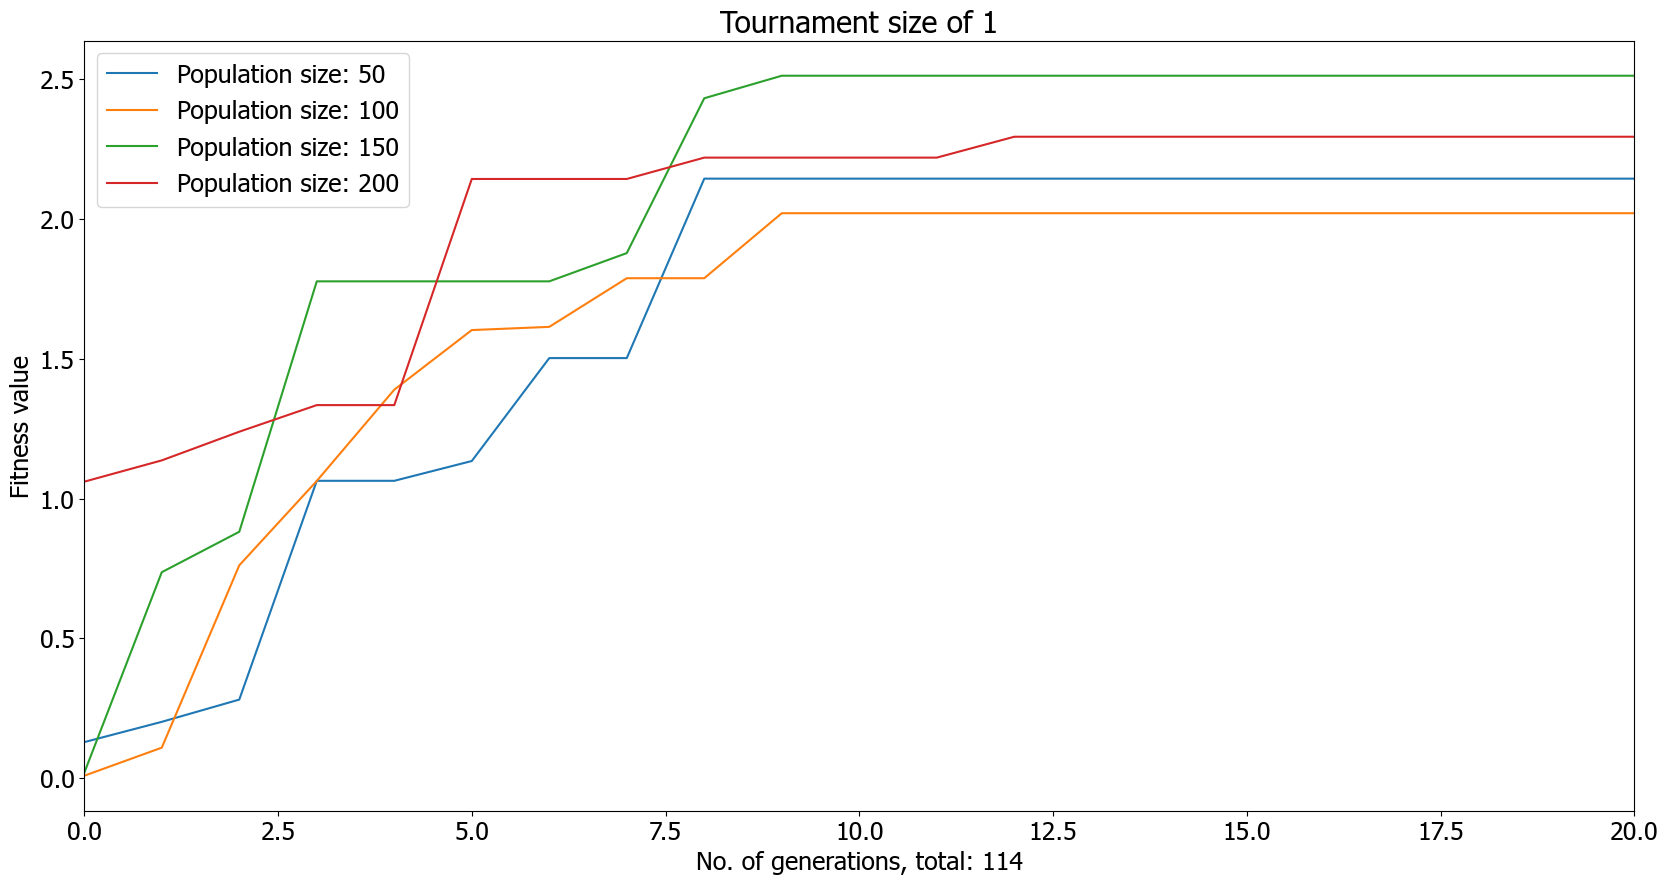

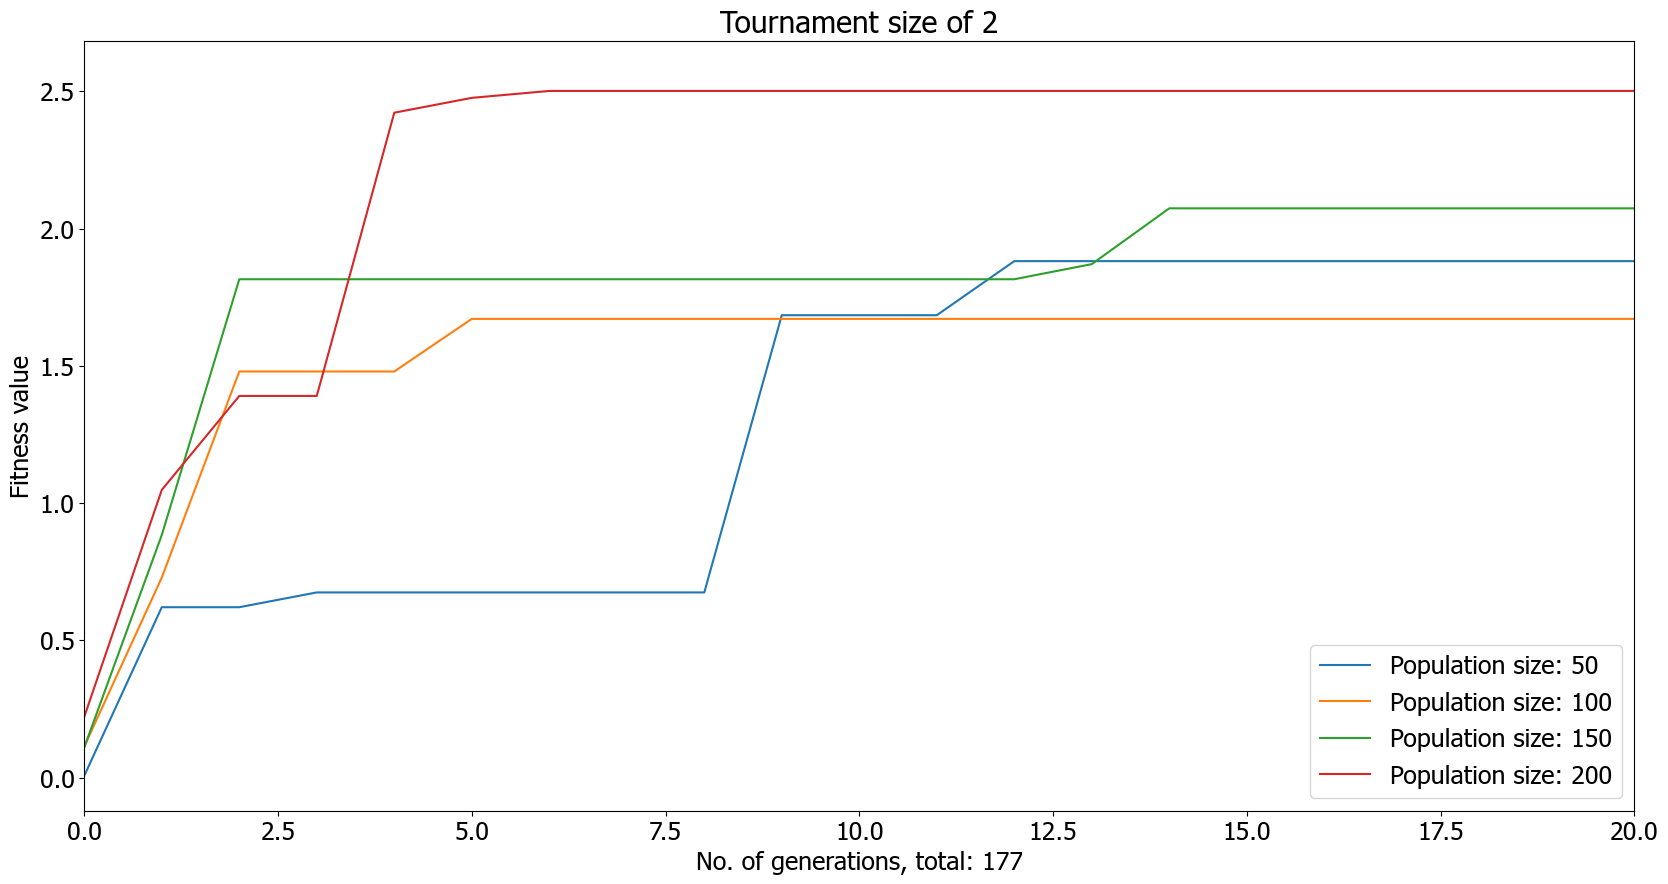

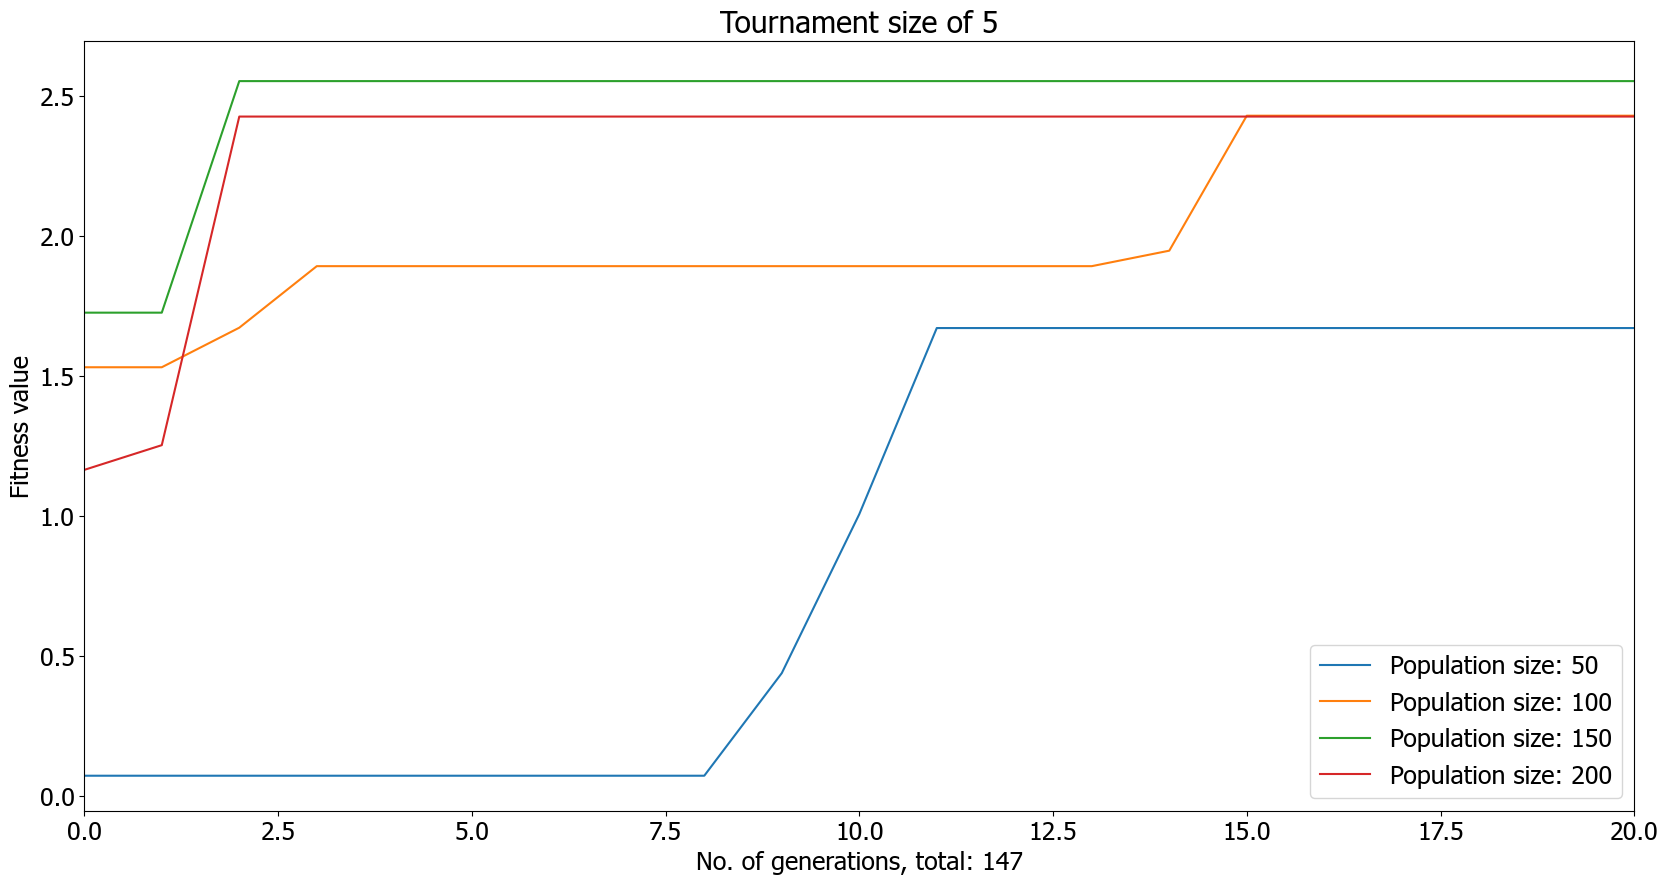

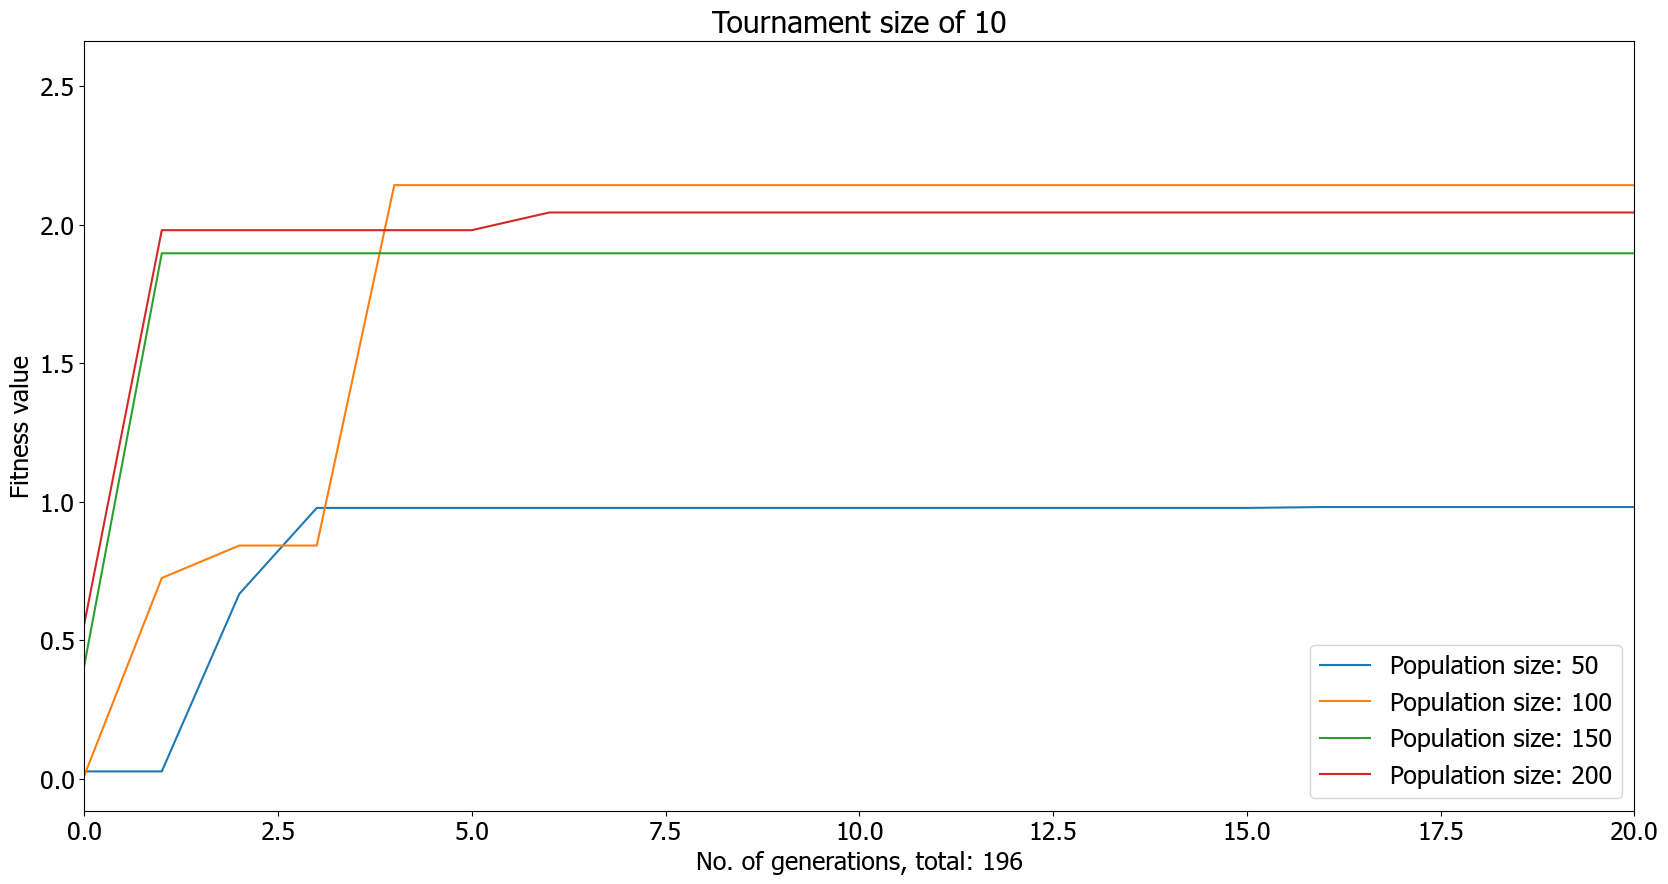

In [22]:
for dim in range(2, 6):
    tournament_size_influence(dim)